## Code used for processing the energy consumption data from the experiments with parallel mini-batching in MOA


In [104]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import time
from IPython.display import display
from collections import Counter
import os
import re
import math
import random
pd.set_option('display.max_rows', 300)
pd.options.display.float_format = '{:,.2f}'.format

In [105]:
PATH_TO_RESULTS = '/Users/reginaldoluisdeluna/Documents/Ufscar/comparison-xue3m-minibatching/results/'

In [106]:
def filter_by_substring_algorithm(df, string):
    aux = df[df['algorithm'].str.contains(string, regex=False)]
    ret = aux
    if string == 'OB':
        ret = aux[~aux.algorithm.str.contains("Adwin|ASHT")]
    elif string == 'OzaBag':
        ret = aux[(aux.algorithm.str.contains(string)) & (~aux.algorithm.str.contains("Adwin|ASHT"))]
    return ret

***

# MOA logs

In [107]:
def parse_MOA(fname):
    global header_printed
    columns = []
    wanted = ['learning evaluation instances', 'Wall Time (Actual Time)', 'Avg Delay (ms)', 'outRate (inst/s)']
    pstr = ''
    spname = fname.split('/')[-1].split('-')
    spline = []
    for s in spname[1:]:
        pstr += s + ','
    with open (fname) as file:
        for line in file:
            if 'learning evaluation instances' in line:
                spline = line.split(',')
                for s in spline:
                    if s in wanted:
                        columns.append(spline.index(s))
            else:
                spline = line.split(',')
        for c in columns:
            pstr += spline[c] + ','
        if len(columns) == 2:
            pstr += '1,'
        if not header_printed:
            head = 'dataset,algorithm,ensemble_size,cores,batch_size,inc_rate,instances,time,delay,out_rate'
            pstr = f"{head}\n{pstr}"
            header_printed = True
        return (pstr[:-1])

In [171]:
def read_MOA(folder, out_file):
    directory = os.fsencode(folder)
    global header_printed

    with open(out_file, "w+") as output:
        for file in os.listdir(directory):
            filename = os.fsdecode(file)
            if filename.startswith("term-"): 
                output.write(f"{parse_MOA(f'{os.fsdecode(directory)}/{filename}')}\n")
    fname = os.fsdecode(out_file)
    df = pd.read_csv(fname)
    df['inc_rate'].astype('int64')
    return df[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'instances', 'time', 'delay', 'out_rate']] 

## Energy Data

In [172]:
def load_Wmeas(filename):
    return pd.read_csv(filename, header=None, names=['date', 'time', 'measure'])

In [173]:
def exper_order_to_dict(filename, d):
    with open(filename) as forder:
        got_timestamp = False
        dataset = algorithm = Esize = cores = Bsize = ''
        dnow=None
        for line in forder:
            if not got_timestamp:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
                if dnow:
                    dnow['finish'] = date_time_obj - datetime.timedelta(seconds=1)
            elif ':' not in line:
                spline = line.split('/')[-1].strip().split('-')
                #print(spline)
                if len(spline) == 6:
                    dataset,algorithm,Esize,cores,Bsize,rate = spline
                else:
                    dataset,algorithm,Esize,cores,Bsize,rate = *spline,1
                if algorithm not in d:
                    d[algorithm] = {}
#                 if method not in d[algorithm]:
#                     d[algorithm][method] = {}
                if dataset not in d[algorithm]:
                    d[algorithm][dataset] = {}
                if Esize not in d[algorithm][dataset]:
                    d[algorithm][dataset][Esize] = {}
                if cores not in d[algorithm][dataset][Esize]:
                    d[algorithm][dataset][Esize][cores] = {}
                if Bsize not in d[algorithm][dataset][Esize][cores]:
                    d[algorithm][dataset][Esize][cores][Bsize] = {}
                if rate not in d[algorithm][dataset][Esize][cores][Bsize]:
                    d[algorithm][dataset][Esize][cores][Bsize][rate] = {'start': date_time_obj, 'finish': ''}
                    dnow = d[algorithm][dataset][Esize][cores][Bsize][rate]
                got_timestamp = False
            else:
                spline = [i.strip() for i in line.split(' ')]
                sdate,stime = spline
                date_time_obj = datetime.datetime.strptime(f'{sdate} {stime}', '%d/%m/%y %H:%M:%S')
                got_timestamp = True
    return d

In [174]:
def populate_dict(d, df):
    df['datetime'] = df['date'] + ' ' + df['time']
    for k, v in d.items():
        for k1, v1 in v.items():
            for k2, v2 in v1.items():
                for k3, v3 in v2.items():
                    for k4, v4 in v3.items():
                        for k5, v5 in v4.items():
                            if 'seconds' not in v5:
                                st = v5['start']
                                ed = v5['finish']
                                v5['seconds'] = (ed - st).seconds
                                new_df = df[(df.datetime <= f'{ed.strftime("%d/%m/%y")} {ed.strftime("%X")}')
                                          & (df.datetime >= f'{st.strftime("%d/%m/%y")} {st.strftime("%X")}')]
                                v5['avg_measure'] = new_df['measure'].mean()
                                v5['sum_measure'] = new_df['measure'].sum()
                                v5['avg_times_seconds'] = v5['avg_measure'] * v5['seconds']
    return d

In [175]:
def append_dict_to_df(d, ensemble_size=False):
    dappend = {'algorithm': [], 'dataset': [], 'ensemble_size': [], 'cores': [], 
               'batch_size': [], 'duration': [], 'inc_rate': [], 'avg_measure': [], 'sum_measure': [], 'avg_times_seconds': []}
    for kalg,valg in d.items():
        for kds,vds in valg.items():
            for kens,vens in vds.items():
                for kcore,vcore in vens.items():
                    for kmbs,vmbs in vcore.items():
                        for krate,vrate in vmbs.items():
                            dappend['algorithm'].append(kalg)
                            dappend['dataset'].append(kds)
                            dappend['ensemble_size'].append(kens)
                            dappend['cores'].append(kcore)
                            dappend['batch_size'].append(kmbs)
                            dappend['duration'].append(vrate['seconds'])
                            dappend['inc_rate'].append(krate)
                            for key in ['avg_measure', 'sum_measure','avg_times_seconds']:
                                dappend[key].append(vrate[key])
    adf = pd.DataFrame(data=dappend)
    adf = adf.sort_values(['algorithm','dataset']).astype({'inc_rate': 'int64', 
                                                           'cores': 'int64',
                                                           'batch_size': 'int64'})
    if ensemble_size:
        return adf[['algorithm', 'dataset', 'ensemble_size', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]
    return adf[['algorithm', 'dataset', 'inc_rate', 'cores', 'batch_size',
               'duration', 'avg_measure', 'sum_measure']]

# Parse SSH logs

In [176]:
def parse_SSH(fname):
    fname = os.fsdecode(fname)
    read_ssh = False
    alg = ''
    dataset = ''
    rate = ''
    d = {'algorithm': [], 'dataset': [], 'batch_size': [], 'inc_rate': [], 'prod_rate': [], 'tt_inst_prod': []}
    with open (fname, "r") as file:
        for line in file:
            if not read_ssh:
                if 'ssh-' in line:
                    read_ssh = True
#                     print(line)
                    spline = line.split('-')
                    if "MAX" in line:
                        if len(spline[1:]) == 3:
                            dataset, alg, rate = spline[1:]
                            bsize = 500
                        else:
                            dataset, alg, bsize, rate = spline[1:]
                    else:
                        dataset, alg, rate = spline[1:]
                        bsize = 1
                    d['algorithm'].append(alg)
                    d['dataset'].append(dataset)
                    d['inc_rate'].append(rate.strip())
                    d['batch_size'].append(bsize)
            else:
                if 'Total instances Producer' in line:
                    tt_inst = float(line.split(': ')[1])
                    d['tt_inst_prod'].append(tt_inst)
                elif 'Producer Rate' in line:
                    prod_rate = float(line.split(': ')[1])
                    d['prod_rate'].append(prod_rate)
                    read_ssh = False
    return pd.DataFrame.from_dict(d).astype({'inc_rate': 'int64'})

# Showing and preparing for charts

In [177]:
def filter_fields(df):
    wanted = ['algorithm', 'dataset', 'batch_size', 'cores', 'out_rate', 'instances', 'delay', 'joules', 'JPI']
    return df[[
        l for l in df.columns if any([w in l for w in wanted])
    ]]

In [178]:
def rename_columns_by_rate(df):
    if df is not None:
        rate = df.PERC.iloc[0]
        return df.rename(columns={"out_rate": f"out_rate_{rate}", "instances": f"instances_{rate}", 
                                  "delay": f"delay_{rate}", "joules": f"joules_{rate}", 
                                  "JPI": f"JPI_{rate}", "tput": f"tput_{rate}"})
    return None


In [179]:
def show_graph_JPI_delay(df, ax, mJPI, mDel, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    global twin
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B250', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = 5
    for i in range(versions):
        try:
            adf = df.iloc[i]
            values_j = [adf.JPI_10, adf.JPI_50, adf.JPI_90]
            if bar:
                lns_l += ax.bar(x - ((1 - i) * width), values_j, width, label=f'JPI-{alg_order[i]}')            
            else:
                lns_l += ax.plot(x, values_j, label=f'JPI-{alg_order[i]}')
        except IndexError:
            return None

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax_r = ax.twinx()
    twin = ax_r
    if log_y:
        ax.set_yscale('log')
        ax_r.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
#         ax.set_xlabel('Rate')
    if ylabels:
        ax.set_ylabel(ds)
#         ax.set_ylabel('JPI')
#         ax_r.set_ylabel('delay')
    if last:
        ax.set_ymargin(2)
    for i in range(versions): 
        adf = df.iloc[i]
        values_d = [ x/1000 for x in [adf.delay_10, adf.delay_50, adf.delay_90]]
        if bar:
            linfo = f'k{line_format[i]}'
            lns_l += ax_r.plot(x, values_d, color='black', linestyle=line_format[i], label=f'delay-{alg_order[i]}')
        else:
            lns_l += ax_r.plot(x, values_d, linfo, label=f'delay-{alg_order[i]}')
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if hide:
        ax_r.set_yticklabels([])
    if share_y == 'row':
        ax.set_ylim(top=mJPI)
        ax_r.set_ylim(top=mDel/1000)

In [180]:
def aux_graphNx1(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    #display(df)
#     print(f'aux {bar}')
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     fig.suptitle(f'JPI and delay for {ds}', fontsize=18, y=1)
#     get max value from delay for all rates on all algorithms for this dataset
    mLstJPI = []
    mLstDel = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstJPI.append(rtDF.JPI.max())
            mLstDel.append(rtDF.delay.max())
        mJPI = max(mLstJPI)*1.05
        mDel = max(mLstDel)*1.05
    else:
        mJPI = mDel = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
#         if alg == 'L' and ds == 'kyoto_binary':
#             display(dsalgdf)
        for rt in rates:
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)

        if 'Ada' in alg:
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            show_graph_JPI_delay(showdf, axis[id_ds][algs.index(alg)], mJPI, mDel, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [181]:
def gen_graph(df, bars=False, share_y='row', log_y=False, norm=False, arch='Vostro', tput=False):
    ps = f'{arch}\nbars: {bars}\nshare_y: {share_y}\nlog_y: {log_y} '
    #datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm', 'kyoto_binary']
    datasets = ['elecNormNew','covtypeNorm', 'GMSC']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True
        dsdf = df[df.dataset == ds]
        aux_graphNx1(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines_1, labels_1 = axis[0][0].get_legend_handles_labels()
    lines_2, labels_2 = twin.get_legend_handles_labels()
    lines = lines_1 + lines_2
    labels = labels_1 + labels_2
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-4x1-JPI-delay'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()

# MAIN

- Create a separate dataframe for each "set of results" (MOA logs, ssh-log, exper_order and Wmeasure)
- Join/merge all dataframes together
- generate charts

In [192]:
def read_data_create_final_dataframe(freq, DEBUG=False):
    d = {}
    global header_printed
    header_printed = False
    moaDF = read_MOA(f"{PATH_TO_RESULTS}/socket/{freq}/{freq}", f"{PATH_TO_RESULTS}/socket/{freq}/{freq}/inst-and-delay.csv")
    moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
    measureDF = load_Wmeas(f'{PATH_TO_RESULTS}/socket/{freq}/{freq}/Wm-{freq}.log')
    d = exper_order_to_dict(f'{PATH_TO_RESULTS}/socket/{freq}/{freq}/exper_order-freq-max-{freq}-freq-min-{freq}.log', d)
    d = populate_dict(d, measureDF)
    mdf = append_dict_to_df(d)
    sshDF = parse_SSH(f'{PATH_TO_RESULTS}/socket/{freq}/{freq}/ssh-log')
    sshDF['batch_size'] = sshDF['batch_size'].astype(int)
    if DEBUG:
        print(f'moaDF: {len(moaDF)}    mdf: {len(mdf)}     sshDF: {len(sshDF)}')
    #join dfs
    finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
    finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
    finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
    finaldf['JPI'] = finaldf['joules'] / finaldf['instances']
    # Add PERC column to identify if it used 90, 50 or 10% max rate
    # Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
    # We use the **PERC**entage column for that
    tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
    tdf['PERC'] = 0
    if DEBUG:
        tdf.to_csv(f"{PATH_TO_RESULTS}/socket/tdf.csv")
    masks = {'90':[], '50': [], '10': []}
    for k, v in zip(masks.keys(), [0, 1, 2]):
        for i in range(len(tdf)):
            masks[k].append(i % 3 == v)
    tdf.loc[masks['90'],'PERC'] = '90'
    tdf.loc[masks['50'],'PERC'] = '50'
    tdf.loc[masks['10'],'PERC'] = '10'
    tdf['tput'] = tdf['instances']/tdf['time']
    return tdf

In [204]:
freqs = ['800', '1000', '1200']
dataframes = []
for f in freqs:
    dataframes.append(read_data_create_final_dataframe(f, True))

Series([], Name: measure, dtype: float64)
Series([], Name: measure, dtype: float64)
Series([], Name: measure, dtype: float64)
13126   3.50
13127   3.50
13128   3.50
13129   3.50
13130   4.10
13131   3.80
13132   3.80
13133   3.90
13134   3.90
13135   4.50
13136   4.50
13137   3.80
13138   3.70
13139   3.70
13140   3.70
13141   3.70
13142   3.80
13143   3.80
13144   3.90
13145   3.90
13146   3.70
13147   3.70
13148   4.20
13149   3.80
13150   3.80
13151   3.70
13152   3.70
13153   4.20
13154   4.20
13155   3.90
13156   3.90
13157   3.70
13158   3.70
13159   3.70
13160   4.00
13161   4.00
13162   3.70
13163   3.70
13164   3.90
13165   3.90
13166   4.00
13167   3.90
13168   3.90
13169   3.70
13170   3.70
13171   4.00
13172   4.00
13173   3.90
13174   3.90
13175   3.70
13176   3.70
13177   3.70
13178   4.00
13179   4.00
13180   3.70
13181   3.70
13182   3.70
13183   3.70
13184   4.20
13185   4.00
13186   4.00
13187   3.70
13188   3.70
13189   3.90
13190   3.90
13191   4.00
13192   4.00
131

1542   3.50
1543   3.50
1544   3.40
1545   3.40
1546   3.40
1547   3.40
1548   3.50
1549   3.60
1550   3.60
1551   3.40
1552   3.40
1553   3.40
1554   3.40
1555   3.40
1556   3.40
1557   3.40
1558   3.40
1559   3.40
1560   3.70
1561   3.70
1562   3.40
1563   3.40
1564   3.40
1565   3.40
1566   3.80
1567   3.60
1568   3.60
1569   3.70
1570   3.70
1571   3.60
1572   3.60
1573   3.70
1574   3.70
1575   3.60
1576   3.60
1577   3.60
1578   3.70
1579   3.70
1580   4.00
1581   4.00
1582   3.70
1583   4.00
1584   4.00
1585   4.70
1586   4.70
1587   4.90
1588   4.90
1589   3.80
1590   3.80
1591   4.90
1592   4.90
1593   5.50
1594   6.50
1595   6.50
1596   5.70
1597   5.70
1598   3.70
1599   3.70
1600   5.20
1601   5.20
1602   3.70
1603   3.70
1604   3.70
1605   4.80
1606   4.80
1607   3.70
1608   3.70
1609   3.80
1610   3.80
1611   4.10
1612   3.60
1613   3.60
1614   4.80
1615   4.80
1616   3.80
1617   3.80
1618   3.80
1619   3.80
1620   3.70
1621   3.60
1622   3.60
1623   4.40
1624   4.40
1625

Series([], Name: measure, dtype: float64)
Series([], Name: measure, dtype: float64)
Series([], Name: measure, dtype: float64)
3050   4.70
3051   3.70
3052   3.70
3053   3.70
3054   3.70
3055   3.70
3056   3.70
3057   3.70
3058   3.70
3059   3.70
3060   3.70
3061   3.70
3062   3.80
3063   3.80
3064   3.70
3065   3.70
3066   3.70
3067   4.70
3068   4.70
3069   3.90
3070   3.90
3071   3.70
3072   3.70
3073   3.70
3074   3.70
3075   3.70
3076   3.70
3077   3.70
3078   3.70
3079   3.70
3080   3.80
3081   3.80
3082   3.70
3083   3.70
3084   3.70
3085   4.40
3086   4.40
3087   3.70
3088   3.70
3089   3.90
3090   3.90
3091   3.70
3092   3.70
3093   3.70
3094   3.70
3095   3.70
3096   3.70
3097   3.70
3098   3.90
3099   3.90
3100   3.90
3101   3.70
3102   3.70
3103   5.40
3104   5.40
3105   3.80
3106   3.80
3107   3.60
3108   3.60
3109   3.70
3110   3.70
3111   3.70
3112   3.80
3113   3.80
3114   3.70
3115   3.70
3116   3.90
3117   3.90
3118   3.70
3119   3.90
3120   3.90
3121   4.30
3122   4.3

Series([], Name: measure, dtype: float64)
moaDF: 273    mdf: 162     sshDF: 487
63    3.70
64    3.70
65    3.70
66    3.70
67    3.70
68    3.70
69    3.70
70    3.70
71    3.70
72    3.70
73    3.70
74    3.90
75    3.90
76    3.70
77    3.70
78    3.70
79    3.70
80    3.70
81    3.70
82    3.70
83    3.70
84    3.70
85    3.90
86    3.90
87    3.70
88    3.70
89    3.70
90    3.70
91    3.70
92    3.70
93    3.70
94    3.80
95    3.80
96    3.70
97    3.70
98    3.70
99    3.70
100   3.70
101   3.70
102   3.70
103   3.70
104   3.70
105   3.90
106   3.70
107   3.70
108   3.70
109   3.70
110   3.70
111   3.70
112   3.70
113   3.70
114   3.70
115   3.70
116   3.70
117   3.70
118   3.70
119   3.70
120   3.70
121   3.70
122   3.70
123   3.70
124   3.70
125   3.90
126   3.70
127   3.70
128   3.70
129   3.70
130   3.70
131   3.90
132   3.70
133   3.70
134   3.70
135   3.70
136   3.70
137   3.70
138   3.70
139   3.70
140   3.70
141   4.00
142   4.00
143   3.70
144   3.70
145   3.70
146   3

27735   3.90
27736   3.70
27737   3.70
27738   3.70
27739   3.70
27740   3.70
27741   5.70
27742   5.70
27743   3.70
27744   3.70
27745   3.70
27746   3.70
27747   3.70
27748   4.10
27749   4.10
27750   3.70
27751   3.70
27752   3.70
27753   3.70
27754   3.80
27755   3.80
27756   3.70
27757   3.70
27758   3.70
27759   3.90
27760   3.90
27761   5.50
27762   5.50
27763   3.70
27764   3.70
27765   3.70
27766   3.70
27767   3.70
27768   4.30
27769   4.30
27770   3.70
27771   3.70
27772   3.70
27773   3.70
27774   3.70
27775   3.70
27776   3.70
27777   3.70
27778   3.70
27779   4.00
27780   4.00
27781   4.70
27782   3.70
27783   3.70
27784   3.70
27785   3.70
27786   3.70
27787   3.70
27788   3.80
27789   3.80
27790   3.70
27791   3.70
27792   3.70
27793   3.70
27794   3.70
27795   3.70
27796   3.70
27797   3.70
27798   3.70
27799   4.00
27800   4.00
27801   4.80
27802   3.70
27803   3.70
27804   3.70
27805   3.70
27806   3.70
27807   3.70
27808   4.30
27809   4.30
27810   3.90
27811   3.70

Name: measure, dtype: float64
2605   4.00
2606   4.00
2607   4.00
2608   4.00
2609   4.00
2610   4.00
2611   4.30
2612   4.00
2613   4.00
2614   4.00
2615   4.00
2616   4.20
2617   4.20
2618   4.00
2619   4.00
2620   3.90
2621   4.10
2622   4.10
2623   4.10
2624   4.10
2625   4.10
2626   4.10
2627   4.30
2628   4.30
2629   4.40
2630   4.30
2631   4.30
2632   4.00
2633   4.00
2634   4.00
2635   4.00
2636   4.00
2637   4.00
2638   4.10
2639   4.10
2640   4.10
2641   4.20
2642   4.20
2643   4.10
2644   4.10
2645   4.00
2646   4.00
2647   4.00
2648   4.00
2649   4.00
2650   4.30
2651   4.30
2652   4.00
2653   4.00
2654   4.00
2655   4.00
2656   4.00
2657   4.70
2658   4.70
2659   4.00
2660   4.00
2661   4.30
2662   4.30
2663   3.90
2664   3.90
2665   4.10
2666   3.70
2667   3.70
2668   4.60
2669   4.80
2670   6.60
2671   6.60
2672   6.30
2673   4.80
2674   4.70
2675   4.70
2676   4.50
2677   4.60
2678   4.60
2679   5.20
2680   5.20
2681   6.20
2682   6.20
2683   4.40
2684   4.40
2685   4.2

25457   3.70
25458   3.70
25459   3.70
25460   3.70
25461   3.70
25462   4.00
25463   4.00
25464   3.70
25465   3.70
25466   3.70
25467   3.70
25468   3.70
25469   3.70
25470   3.70
25471   3.70
25472   3.70
25473   3.70
25474   3.70
25475   3.70
25476   3.70
25477   3.70
25478   3.70
25479   3.70
25480   3.70
25481   3.70
25482   3.90
25483   3.90
25484   3.80
25485   3.70
25486   3.70
25487   3.70
25488   3.70
25489   3.70
25490   3.70
25491   3.70
25492   3.70
25493   4.00
25494   3.70
25495   3.70
25496   3.70
25497   3.70
25498   3.70
25499   3.70
25500   3.70
25501   3.70
25502   3.70
25503   3.70
25504   3.70
25505   3.70
25506   3.70
25507   3.70
25508   3.70
25509   3.70
25510   3.70
25511   3.70
25512   4.00
25513   4.00
25514   3.70
25515   3.70
25516   3.70
25517   3.70
25518   3.70
25519   3.70
25520   3.70
25521   3.70
25522   3.70
25523   3.80
25524   3.80
25525   3.70
25526   3.70
25527   3.70
25528   3.70
25529   3.70
25530   3.70
25531   3.70
25532   3.90
25533   3.90

# rerun airlines




----------------- 800 -----------------


algorithm      dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
2   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
3   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
4   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
5   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
6   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
7   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
8   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
9   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
10  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
11  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
12  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
13  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
14  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
15  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
16  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
17  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
18  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
19  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
20  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
21  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
22  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
23  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
24  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
25  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
26  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
27  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           85        84.86     10,184.00  120.01    362.00         123  ...   
1           85        84.86     10,184.00  120.01    362.00         123  ...   
2           85        84.86     10,184.00  120.01    362.00         123  ...   
3           85        84.86     10,184.00  120.01    362.00         123  ...   
4           85        84.86     10,184.00  120.01    362.00         123  ...   
5           85        84.86     10,184.00  120.01    362.00         123  ...   
6           17        15.00      1,800.00  120.01  1,785.00         124  ...   
7           17        15.00      1,800.00  120.01  1,785.00         124  ...   
8           17        15.00      1,800.00  120.01  1,785.00         124  ...   
9           17        15.00      1,800.00  120.01  1,785.00         124  ...   
10          17        15.00      1,800.00  120.01  1,785.00         124  ...   
11          17        15.00      1,800.00  120.01  1,785.00         124  ...   
12         102        99.99     11,980.00  119.81  3,103.00         125  ...   
13         102        99.99     11,980.00  119.81  3,103.00         125  ...   
14         102        99.99     11,980.00  119.81  3,103.00         125  ...   
15         102        99.99     11,980.00  119.81  3,103.00         125  ...   
16          20        20.01      2,400.00  119.96 14,294.00         124  ...   
17          20        20.01      2,400.00  119.96 14,294.00         124  ...   
18          20        20.01      2,400.00  119.96 14,294.00         124  ...   
19          20        20.01      2,400.00  119.96 14,294.00         124  ...   
20          99        94.99     11,381.00  119.81 13,273.00         125  ...   
21          99        94.99     11,381.00  119.81 13,273.00       

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  elecNormNew      4          50         294   
1   LBagExecutorMAXChunk  elecNormNew      4          50         294   
2   LBagExecutorMAXChunk  elecNormNew      4          50         294   
3   LBagExecutorMAXChunk  elecNormNew      4          50         294   
4   LBagExecutorMAXChunk  elecNormNew      4          50         294   
5   LBagExecutorMAXChunk  elecNormNew      4          50         294   
6   LBagExecutorMAXChunk  elecNormNew      4          50         294   
7   LBagExecutorMAXChunk  elecNormNew      4          50         294   
8   LBagExecutorMAXChunk  elecNormNew      4          50         294   
9   LBagExecutorMAXChunk  elecNormNew      4          50         163   
10  LBagExecutorMAXChunk  elecNormNew      4          50         163   
11  LBagExecutorMAXChunk  elecNormNew      4          50         163   
12  LBagExecutorMAXChunk  elecNormNew      4          50         163   
13  LBagExecutorMAXChunk  elecNormNew      4          50         163   
14  LBagExecutorMAXChunk  elecNormNew      4          50         163   
15  LBagExecutorMAXChunk  elecNormNew      4          50         163   
16  LBagExecutorMAXChunk  elecNormNew      4          50         163   
17  LBagExecutorMAXChunk  elecNormNew      4          50         163   
18  LBagExecutorMAXChunk  elecNormNew      4          50          32   
19  LBagExecutorMAXChunk  elecNormNew      4          50          32   
20  LBagExecutorMAXChunk  elecNormNew      4          50          32   
21  LBagExecutorMAXChunk  elecNormNew      4          50          32   
22  LBagExecutorMAXChunk  elecNormNew      4          50          32   
23  LBagExecutorMAXChunk  elecNormNew      4          50          32   
24  LBagExecutorMAXChunk  elecNormNew      4          50          32   
25  LBagExecutorMAXChunk  elecNormNew      4          50          32   
26  LBagExecutorMAXChunk  elecNormNew      4          50          32   
27  LBagExecutorMAXChunk  elecNormNew      4         500         168   
28  LBagExecutorMAXChunk  elecNormNew      4         500         168   
29  LBagExecutorMAXChunk  elecNormNew      4         500         168   
30  LBagExecutorMAXChunk  elecNormNew      4         500         168   
31  LBagExecutorMAXChunk  elecNormNew      4         500          33   
32  LBagExecutorMAXChunk  elecNormNew      4         500          33   
33  LBagExecutorMAXChunk  elecNormNew      4         500          33   
34  LBagExecutorMAXChunk  elecNormNew      4         500          33   
35  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
36  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
37  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
38  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
39  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
40  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
41  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
42  LBagExecutorMAXChunk  elecNormNew      4        2000          30   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        289.74     34,742.00  119.91    108.00         126  ...    108.00   
1        289.74     34,742.00  119.91    108.00         126  ...    182.00   
2        289.74     34,742.00  119.91    108.00         126  ...    876.00   
3        289.74     34,742.00  119.91    108.00         126  ...    108.00   
4        289.74     34,742.00  119.91    108.00         126  ...    182.00   
5        289.74     34,742.00  119.91    108.00         126  ...    876.00   
6        289.74     34,742.00  119.91    108.00         126  ...    108.00   
7        289.74     34,742.00  119.91    108.00         126  ...    182.00   
8        289.74     34,742.00  119.91    108.00         126  ...    876.00   
9        159.90     19,168.00  119.87    182.00         125  ...  

algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
5   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
6   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
7   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
8   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
9   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
10  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
11  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
12  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
13  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
14  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
15  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
16  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
17  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
18  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
19  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           55        54.96      6,600.00  120.10    557.00         125  ...   
1           55        54.96      6,600.00  120.10    557.00         125  ...   
2           55        54.96      6,600.00  120.10    557.00         125  ...   
3           55        54.96      6,600.00  120.10    557.00         125  ...   
4           56        55.00      6,600.00  119.99  5,618.00         125  ...   
5           56        55.00      6,600.00  119.99  5,618.00         125  ...   
6           56        55.00      6,600.00  119.99  5,618.00         125  ...   
7           56        55.00      6,600.00  119.99  5,618.00         125  ...   
8           11        10.00      1,200.00  119.95 25,640.00         125  ...   
9           11        10.00      1,200.00  119.95 25,640.00         125  ...   
10          11        10.00      1,200.00  119.95 25,640.00         125  ...   
11          11        10.00      1,200.00  119.95 25,640.00         125  ...   
12          54        48.66      6,000.00  123.30 25,432.00         129  ...   
13          54        48.66      6,000.00  123.30 25,432.00         129  ...   
14          54        48.66      6,000.00  123.30 25,432.00         129  ...   
15          54        48.66      6,000.00  123.30 25,432.00         129  ...   
16          10        10.00      1,200.00  119.94 74,642.00         134  ...   
17          10        10.00      1,200.00  119.94 74,642.00         134  ...   
18          10        10.00      1,200.00  119.94 74,642.00         134  ...   
19          10        10.00      1,200.00  119.94 74,642.00         134  ...   

    delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0     307.00       124         4.15     1,036.40      99.84     12,000.00   
1   2,651.00       123         4.34     1,076.70       9.99      1,200.00   
2     307.00       124         4.15     1,036.40      99.84     12,000.00   
3   2,651.00       123         4.34     1,076.70       9.99      1,200.00   
4   3,384.00       125         4.51     1,135.50      99.84     12,000.00   
5   5,618.00       125         4.16     1,047.10      54.91      6,600.00   
6   3,384.00       125         4.51     1,135.50      99.84     12,000.00   
7   5,618.00       125         4.16     1,047.10      54.91      6,600.00   
8   3,384.00       1

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
1   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
2   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
3   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
4   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
5   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
6   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
7   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
8   OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
9   OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
10  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
11  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
12  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
13  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
14  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
15  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
16  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
17  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
18  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
19  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
20  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
21  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
22  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
23  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
24  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
25  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
26  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
27  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
28  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
29  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
30  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
31  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
32  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
33  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
34  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
35  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
36  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
37  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
38  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
39  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
40  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
41  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
42  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        404.17     45,312.00  112.11     73.00         118  ...     45.00   
1        404.17     45,312.00  112.11     73.00         118  ...     73.00   
2        404.17     45,312.00  112.11     73.00         118  ...     45.00   
3        404.17     45,312.00  112.11     73.00         118  ...     73.00   
4         79.99      9,584.00  119.81    326.00         125  ...     45.00   
5         79.99      9,584.00  119.81    326.00         125  ...     73.00   

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
1   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
2   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
3   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
4   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
5   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
6   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
7   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
8   OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
9   OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
10  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
11  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
12  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
13  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
14  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
15  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
16  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
17  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
18  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
19  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
20  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
21  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
22  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
23  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        439.45     45,312.00  103.11     65.00         109  ...     40.00   
1        439.45     45,312.00  103.11     65.00         109  ...     65.00   
2        439.45     45,312.00  103.11     65.00         109  ...     40.00   
3        439.45     45,312.00  103.11     65.00         109  ...     65.00   
4         85.00     10,200.00  120.00    309.00         126  ...     40.00   
5         85.00     10,200.00  120.00    309.00         126  ...     65.00   
6         85.00     10,200.00  120.00    309.00         126  ...     40.00   
7         85.00     10,200.00  120.00    309.00         126  ...     65.00   
8        468.78     45,312.00   96.66    663.00         103  ...    413.00   
9        468.78     45,312.00   96.66    663.00         103  ...    663.00   
10       468.78     45,312.00   96.66    663.00         103  ...    413.00   
11       468.78     45,312.00   96.66    663.00         103  ...    663.00   
12        89.99     10,782.00  119.82  2,953.00         125  ...    413.00   
13        89.99     10,782.00  119.82  2,953.00         125  ...    663.00   
14        89.99     10,782.00  119.82  2,953.00         125  ...    413.00   
15        89.99     10,782.00  119.82  2,953.00         125  ...    663.00   
16       409.32     45,312.00  110.70  2,945.00         117  ...  1,988.00   
17       409.32     45,312.00  110.70  2,945.00         117  ...  2,945.00   
18       409.32     45,312.00  110.70  2,945.00         117  ...  1,988.00   
19       409.32     45,312.00  110.70  2,945.00         117  ...  2,945.00   
20        79.87      9,585.00  120.00 13,127.00         125  ...  1,988.00   
21        79.87      9,585.00  120.00 13,127.00         125  ...  2,945.00   
22        79.87      9,585.00  120.00 13,127.00         125  ...  1,988.00   
23        79.87      9,585.00  120.00 13,127.00         125  ...  2,945.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0         62         4.01       505.70    

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
1   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
2   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
3   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
4   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
5   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
6   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
7   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
8   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
9   OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
10  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
11  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
12  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
13  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
14  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
15  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
16  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
17  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
18  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
19  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
20  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
21  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
22  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
23  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
24  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
25  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
26  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
27  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
28  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
29  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
30  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
31  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
32  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
33  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
34  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
35  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
36  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
37  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
38  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
39  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
40  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
41  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
42  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
43  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
44  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
45  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
46  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        857.81     45,312.00   52.82     38.00          59  ...     38.00   
1        857.81     45,312.00   52.82     38.00          59  ...     57.00   
2        857.81     45,312.00   52.82     38.00          59  ...    277.00   
3        857.81     45,312.00   52.82     38.00          59  ...     38.00   
4        857.81     45,312.00   52.82     38.00          59  ...     57.00

algorithm      dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
2   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
3   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
4   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
5   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
6   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
7   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
8   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
9   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
10  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
11  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
12  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
13  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
14  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
15  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
16  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
17  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
18  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
19  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
20  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
21  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
22  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
23  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          143       139.86     16,772.00  119.92    259.00         124  ...   
1          143       139.86     16,772.00  119.92    259.00         124  ...   
2           15        14.99      1,800.00  120.08  1,827.00         124  ...   
3           15        14.99      1,800.00  120.08  1,827.00         124  ...   
4          104        99.99     11,980.00  119.81  3,451.00         125  ...   
5          104        99.99     11,980.00  119.81  3,451.00         125  ...   
6          104        99.99     11,980.00  119.81  3,451.00         125  ...   
7          104        99.99     11,980.00  119.81  3,451.00         125  ...   
8          104        99.99     11,980.00  119.81  3,451.00         125  ...   
9          104        99.99     11,980.00  119.81  3,451.00         125  ...   
10          11        10.00      1,200.00  119.94 26,279.00         125  ...   
11          11        10.00      1,200.00  119.94 26,279.00         125  ...   
12          11        10.00      1,200.00  119.94 26,279.00         125  ...   
13          11        10.00      1,200.00  119.94 26,279.00         125  ...   
14          11        10.00      1,200.00  119.94 26,279.00         125  ...   
15          11        10.00      1,200.00  119.94 26,279.00         125  ...   
16         132       124.64     14,934.00  119.81 11,182.00         127  ...   
17         132       124.64     14,934.00  119.81 11,182.00         127  ...   
18         132       124.64     14,934.00  119.81 11,182.00         127  ...   
19         132       124.64     14,934.00  119.81 11,182.00         127  ...   
20          14        10.00      1,200.00  119.95 69,780.00         138  ...   
21          14        10.00      1,200.00  119.95 69,780.00         138  ...   
22          14        10.00      1,200.00  119.95 69,780.00         138  ...   
23          14        10.00      1,200.00  119.95 69,780.00         138  ...   

    delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0     396.00       125         3.92       988.90    

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
1   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
2   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
3   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
4   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
5   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
6   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
7   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
8   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
9   LBagExecutorMAXChunk  covtypeNorm      4          50          38   
10  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
11  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
12  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
13  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
14  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
15  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
16  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
17  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
18  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
19  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
20  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
21  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
22  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
23  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
24  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
25  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
26  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
27  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
28  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
29  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
30  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
31  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
32  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
33  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
34  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
35  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
36  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
37  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
38  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
39  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
40  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
41  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
42  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
43  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
44  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
45  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
46  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         64.93      7,800.00  120.13    530.00         125  ...    530.00   
1         64.93      7,800.00  120.13    530.00         125  ...    863.00   
2         64.93      7,800.00  120.13    530.00         125  ...  5,206.00   
3         64.93      7,800.00  120.13    530.00         125  ...    530.00   
4         64.93      7,800.00  120.13    530.00         125  ...    863.00   
5         64.93      7,800.00  120.13    530.00         125  ...  5,206.00   
6         64

algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
5   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
6   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
7   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
8   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
9   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
10  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
11  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
12  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
13  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
14  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
15  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
16  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
17  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
18  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
19  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
20  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
21  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
22  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
23  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
24  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
25  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
26  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
27  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
28  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
29  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
30  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
31  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
32  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
33  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
34  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
35  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
36  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
37  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
38  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
39  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
40  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
41  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
42  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
43  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
44  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
45  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
46  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
47  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
48  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
49  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
50  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
1   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
2   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
3   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
4   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
5   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
6   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
7   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
8   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
9   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
10  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
11  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
12  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
13  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
14  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
15  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
16  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
17  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
18  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
19  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
20  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
21  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
22  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
23  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
24  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
25  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
26  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
27  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
28  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
29  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
30  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
31  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
32  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
33  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
34  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
35  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
36  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
37  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
38  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
39  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
40  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
41  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
42  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
43  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
44  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
45  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000          40   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         54.91      6,600.00  120.20    610.00         125  ...    926.00   
1         54.91      6,600.00  120.20    610.00         125  ...  5,141.00   
2         54.91      6,600.00  120.20    610.00         125  ...    926.00

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
1   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
2   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
3   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
4   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
5   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
6   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
7   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
8   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
9   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
10  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
11  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
12  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
13  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
14  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
15  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
16  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           8   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         34.96      4,200.00  120.14    843.00         125  ...    518.00   
1         34.96      4,200.00  120.14    843.00         125  ...    843.00   
2         34.96      4,200.00  120.14    843.00         125  ...    518.00   
3         34.96      4,200.00  120.14    843.00         125  ...    843.00   
4          5.00        600.00  120.04  5,142.00         126  ...    518.00   
5          5.00        600.00  120.04  5,142.00         126  ...    843.00   
6          5.00        600.00  120.04  5,142.00         126  ...    518.00   
7          5.00        600.00  120.04  5,142.00         126  ...    843.00   
8         45.01      5,400.00  119.98  6,542.00         126  ...  4,188.00   
9         45.01      5,400.00  119.98  6,542.00         126  ...  6,542.00   
10        45.01      5,400.00  119.98  6,542.00         126  ...  4,188.00   
11        45.01      5,400.00  119.98  6,542.00         126  ...  6,542.00   
12         5.00        600.00  119.93 45,496.00         126  ...  4,188.00   
13         5.00        600.00  119.93 45,496.00         126  ...  6,542.00   
14         5.00        600.00  119.93 45,496.00         126  ...  4,188.00   
15         5.00        600.00  119.93 45,496.00         126  ...  6,542.00   
16         5.00        600.00  119.94 63,009.00         129  ... 20,167.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        126         3.85       977.90      64.91      7,800.00    462.00   
1        125         3.91       984.10      34.95      4,200.00    469.17   
2        126         3.85       977.90      64.91      7,800.00    462.00   
3        125         3.91       984.10      34.95      4,200.00    469.17   
4        126         3.85       977.90      64.91      7,800.00    462.00   
5        125         3.91       984.10      34.95      4,200.00    469.17   
6        126         3.85       977.90      64.91      7,800.00    462.00   
7        125         3.91       984.10      34.95      4,200.00    469.17   
8        126         4.25     1,079.80      79.87      9,600.00    510.47   
9        126         4.08     1,036.60      44.94      5,400.00    489.64   
10       126         4.25     1,079.80      79.87      9,600.00    510.47   
11       126         4.08     1,036.60      44.94      5,400.00    489.64   
12       126         4.25     1,079.80      79.87      9,600.00    510.47   
13       126         4.08     1,036.60      44.94      5,400.00    489.64   
14       126         4.25     1,079.80      79.87      9

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
1   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
2   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
3   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
4   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
5   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
6   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
7   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
8   OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
9   OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
10  OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
11  OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
12  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
13  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
14  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
15  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
16  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
17  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
18  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
19  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
20  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
21  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
22  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
23  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         64.91      7,800.00  120.17    525.00         126  ...    813.00   
1         64.91      7,800.00  120.17    525.00         126  ...  5,120.00   
2         64.91      7,800.00  120.17    525.00         126  ...    813.00   
3         64.91      7,800.00  120.17    525.00         126  ...  5,120.00   
4          5.00        600.00  120.02  5,120.00         125  ...    813.00   
5          5.00        600.00  120.02  5,120.00         125  ...  5,120.00   
6          5.00        600.00  120.02  5,120.00         125  ...    813.00   
7          5.00        600.00  120.02  5,120.00         125  ...  5,120.00   
8         65.01      7,800.00  119.99  4,790.00         126  ...  8,036.00   
9         65.01      7,800.00  119.99  4,790.00         126  ... 45,547.00   
10        65.01      7,800.00  119.99  4,790.00         126  ...  8,036.00   
11        65.01      7,800.00  119.99  4,790.00         126  ... 45,547.00   
12         5.00        600.00  119.93 45,547.00         125  ...  8,036.00   
13         5.00        600.00  119.93 45,547.00         125  ... 45,547.00   
14         5.00        600.00  119.93 45,547.00         125  ...  8,036.00   
15         5.00        600.00  119.93 45,547.00         125  ... 45,547.00   
16        89.99     10,782.00  119.81 14,592.00         127  ... 24,135.00   
17        89.99     10,782.00  119.81 14,592.00         127  ... 65,425.00   
18        89.99     10,782.00  119.81 14,592.00         127  ... 24,135.00   
19        89.99     10,782.00  119.81 14,592.00         127  ... 65,425.00   
20        10.01      1,200.00  119.94 65,425.00         131  ... 24,135.00   
21        10.01      1,200.00  119.94 65,425.00         131  ... 65,425.00   
22        10.01      1,200.00  119.94 65,425.00         131  ... 24,135.00   
23        10.01      1,200.00  119.94 65,425.00         131  ... 65,425.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        126         3.80       965.20      34.96      4,200.00    456.39   
1        125         3.94       992.00       4.99        600.

algorithm dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
49  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
50  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
51  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
52  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
53  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
54  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
55  AdaptiveRandomForestExecutorMAXChunk    GMSC      4

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
1   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
2   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
3   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
4   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
5   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
6   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
7   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
8   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
9   LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
10  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
11  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
12  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
13  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
14  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
15  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
16  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
17  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
18  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
19  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
20  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
21  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
22  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
23  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
24  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
25  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
26  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
27  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
28  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
29  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
30  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
31  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
32  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
33  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
34  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
35  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
36  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
37  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
38  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
39  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
40  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
41  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
42  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
43  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
44  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
45  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
46  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
47  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
48  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
49  LBagExecuto

algorithm dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          171       169.86     20,366.00  119.90    187.00         124  ...   
1          171       169.86     20,366.00  119.90    187.00         124  ...   
2           19        15.00      1,800.00  120.01  1,775.00         123  ...   
3           19        15.00      1,800.00  120.01  1,775.00         123  ...   
4          171       169.98     20,366.00  119.81  2,015.00         124  ...   
5          171       169.98     20,366.00  119.81  2,015.00         124  ...   
6          171       169.98     20,366.00  119.81  2,015.00         124  ...   
7          171       169.98     20,366.00  119.81  2,015.00         124  ...   
8           19        15.01      1,800.00  119.95 17,600.00         125  ...   
9           19        15.01      1,800.00  119.95 17,600.00         125  ...   
10          19        15.01      1,800.00  119.95 17,600.00         125  ...   
11          19        15.01      1,800.00  119.95 17,600.00         125  ...   
12         162       159.99     19,168.00  119.81  8,609.00         125 

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
1   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
2   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
3   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
4   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
5   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
6   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
7   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
8   OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
9   OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
10  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
11  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
12  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
13  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
14  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
15  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
16  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
17  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
18  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
19  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
20  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
21  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
22  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
23  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
24  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
25  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
26  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
27  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
28  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
29  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
30  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
31  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
32  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
33  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
34  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
35  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
36  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
37  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
38  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
39  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
40  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
41  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
42  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        614.10     73,677.00  119.98     48.00         126  ...     29.00   
1        614.10     73,677.00  119.98     48.00         126  ...     48.00   
2        614.10     73,677.00  119.98     48.00         126  ...     29.00   
3        614.10     73,677.00  119.98     48.00         126  ...     48.00   
4        119.98     14,376.00  119.82    215.00         125  ...     29.00   
5        119.98     14,376.00  119.82    215.00         125  ...     48.00   
6        119.98     14,376.00  119.82    215.00         125  ...     29.00   
7        119.98     14,376.00  119.82    215.00         125  ...     48.00   
8        963.13    115,414.00  119.83    338.00         125  ..

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
1   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
2   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
3   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
4   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
5   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
6   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
7   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
8   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
9   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
10  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
11  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
12  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
13  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
14  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
15  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
16  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
17  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
18  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
19  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
20  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
21  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
22  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
23  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
24  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
25  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
26  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
27  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
28  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
29  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
30  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
31  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
32  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
33  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
34  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
35  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
36  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
37  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
38  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
39  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
40  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
41  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
42  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
43  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
44  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
45  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
46  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
47  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
48  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
49  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
50  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
51  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
52  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
53  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
54  Oz

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk    GMSC      4          50         522   
1   OzaBagExecutorMAXChunk    GMSC      4          50         522   
2   OzaBagExecutorMAXChunk    GMSC      4          50         522   
3   OzaBagExecutorMAXChunk    GMSC      4          50         522   
4   OzaBagExecutorMAXChunk    GMSC      4          50         104   
5   OzaBagExecutorMAXChunk    GMSC      4          50         104   
6   OzaBagExecutorMAXChunk    GMSC      4          50         104   
7   OzaBagExecutorMAXChunk    GMSC      4          50         104   
8   OzaBagExecutorMAXChunk    GMSC      4         500         551   
9   OzaBagExecutorMAXChunk    GMSC      4         500         551   
10  OzaBagExecutorMAXChunk    GMSC      4         500         551   
11  OzaBagExecutorMAXChunk    GMSC      4         500         551   
12  OzaBagExecutorMAXChunk    GMSC      4         500         110   
13  OzaBagExecutorMAXChunk    GMSC      4         500         110   
14  OzaBagExecutorMAXChunk    GMSC      4         500         110   
15  OzaBagExecutorMAXChunk    GMSC      4         500         110   
16  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
17  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
18  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
19  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
20  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
21  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
22  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
23  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
24  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
25  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
26  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
27  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
28  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
29  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
30  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
31  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
32  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
33  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
34  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
35  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
36  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
37  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
38  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
39  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
40  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
41  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
42  OzaBagExecutorMAXChunk    GMSC      4        2000         108   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        519.45     62,296.00  119.93     54.00         125  ...     33.00   
1        519.45     62,296.00  119.93     54.00         125  ...     54.00   
2        519.45     62,296.00  119.93     54.00         125  ...     33.00   
3        519.45     62,296.00  119.93     54.00         125  ...     54.00   
4         99.98     11,980.00  119.82    219.00         126  ...     33.00   
5         99.98     11,980.00  119.82    219.00         126  ...     54.00   
6         99.98     11,980.00  119.82    219.00         126  ...     33.00   
7         99.98     11,980.00  119.82    219.00         126  ...     54.00   
8        549.50     65,890.00  119.91    532.00         125  ...    330.00   
9        549.50     65,890.00  119.91    532.00         125  ...    532.00   
10       549.50     65,890.00  119.91    532.00         125  ...    330.00   
11       549.50     65,890.00  119.91    532

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


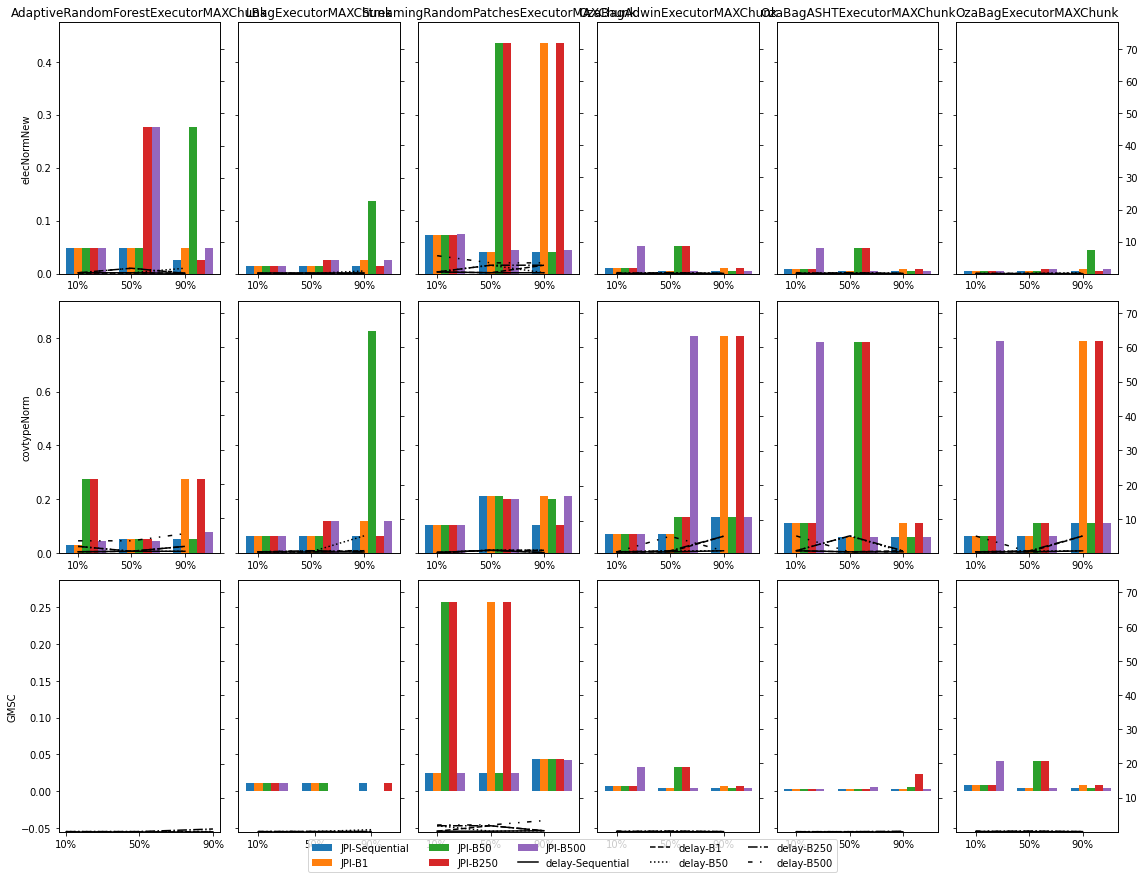




----------------- 1000 -----------------


algorithm      dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          19        15.00      1,800.00  120.01  1,786.00         123  ...   
1          19        15.01      1,800.00  119.96 18,269.00         124  ...   
2          19        15.01      1,800.00  119.95 76,649.00         141  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    179.00       124         4.12     1,029.40     174.67     20,965.00   
1  2,018.00       125         4.17     1,050.90     174.67     20,965.00   
2  8,056.00       125         4.10     1,032.30     174.67     20,965.00   

  joules_90  JPI_90  PERC  tput_90  
0    493.61    0.02    90   174.88  
1    499.76    0.02    90   174.94  
2    490.90    0.02    90   174.70  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  LBagExecutorMAXChunk  elecNormNew      4          50          31   
1  LBagExecutorMAXChunk  elecNormNew      4         500          31   
2  LBagExecutorMAXChunk  elecNormNew      4        2000          31   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        30.00      3,600.00  120.00    876.00         126  ...    109.00   
1        30.01      3,600.00  119.97  9,158.00         126  ...  1,192.00   
2        30.01      3,600.00  119.97 35,801.00         127  ...  4,753.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         4.03     1,022.90     284.36     34,143.00    482.95   
1       125         3.97     1,001.50     284.36     34,143.00    476.43   
2       127         3.97     1,017.00     284.39     34,143.00    476.20   

   JPI_90  PERC  tput_90  
0    0.01    90   284.71  
1    0.01    90   284.81  
2    0.01    90   282.54  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           4        19.99      2,400.00  120.09  1,382.00         125  ...   
1           4        20.01      2,400.00  119.96 14,320.00         125  ...   
2           4        20.01      2,400.00  119.96 54,993.00         126  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    734.00       124         4.27     1,066.80      39.94      4,800.00   
1  7,425.00       124         3.94       985.30      39.94      4,800.00   
2 29,240.00       126         3.98     1,011.50      39.94      4,800.00   

  joules_90  JPI_90  PERC  tput_90  
0    512.43    0.11    90    39.97  
1    472.89    0.10    90    40.00  
2    477.81    0.10    90    40.01  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          79   
1  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          79   
2  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        74.88      8,986.00  120.01    330.00         125  ...     48.00   
1        74.88      8,986.00  120.00  3,567.00         126  ...    493.00   
2        74.88      8,986.00  120.00 13,821.00         126  ...  1,993.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        69         3.99       558.20     712.52     45,312.00    253.00   
1        68         3.74       516.30     712.51     45,312.00    237.22   
2        68         3.73       514.60     712.50     45,312.00    236.45   

   JPI_90  PERC  tput_90  
0    0.01    90   714.09  
1    0.01    90   714.62  
2    0.01    90   708.93  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          41   
1  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          41   
2  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          41   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        40.00      4,800.00  120.00    632.00         125  ...     50.00   
1        40.01      4,800.00  119.99  6,411.00         126  ...    775.00   
2        40.01      4,800.00  119.98 24,383.00         126  ...  3,193.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         3.89       981.40     374.07     44,925.00    467.03   
1       126         4.09     1,039.10     374.08     44,925.00    490.53   
2       125         3.73       938.90     374.11     44,925.00    446.72   

   JPI_90  PERC  tput_90  
0    0.01    90   374.62  
1    0.01    90   374.67  
2    0.01    90   374.69  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  elecNormNew      4          50          92   
1  OzaBagExecutorMAXChunk  elecNormNew      4         500          92   
2  OzaBagExecutorMAXChunk  elecNormNew      4        2000          92   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        89.99     10,782.00  119.82    286.00         126  ...     40.00   
1        89.99     10,782.00  119.81  2,947.00         126  ...    389.00   
2        89.99     10,782.00  119.81 11,682.00         126  ...  1,655.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        60         3.98       485.30     830.06     45,312.00    216.45   
1        60         3.74       456.50     829.91     45,312.00    203.60   
2        59         3.73       447.00     830.21     45,312.00    202.62   

   JPI_90  PERC  tput_90  
0    0.00    90   832.73  
1    0.00    90   832.77  
2    0.00    90   824.21  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          12        10.00      1,200.00  120.04  2,627.00         124  ...   
1          12        10.00      1,200.00  119.94 26,232.00         125  ...   
2          12        10.00      1,200.00  119.94 71,651.00         136  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    316.00       124         4.00       999.50     109.81     13,178.00   
1  3,213.00       125         3.84       966.90     109.81     13,178.00   
2 13,173.00       126         3.88       986.30     109.81     13,178.00   

  joules_90  JPI_90  PERC  tput_90  
0    479.05    0.04    90   109.98  
1    459.72    0.03    90   109.99  
2    465.25    0.04    90   109.99  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
1  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
2  LBagExecutorMAXChunk  covtypeNorm      4        2000           7   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.01  5,183.00         126  ...    545.00   
1         5.00        600.00  119.94 47,589.00         126  ...  5,279.00   
2         5.00        600.00  119.94 65,191.00         130  ... 22,060.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         3.88       986.20      64.90      7,800.00    466.50   
1       127         3.87       989.60      64.90      7,800.00    463.88   
2       132         3.98     1,057.40      64.90      7,800.00    477.01   

   JPI_90  PERC  tput_90  
0    0.06    90    64.92  
1    0.06    90    65.00  
2    0.06    90    65.00  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           4        19.97      2,400.00  120.20  1,519.00         125  ...   
1           4        20.01      2,400.00  119.95 16,125.00         126  ...   
2           4          NaN           NaN     NaN       NaN         618  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    872.00       125         3.87       975.50      39.95      4,800.00   
1  8,792.00       125         4.04     1,018.40      39.94      4,800.00   
2 34,001.00       128         3.72       960.70      39.95      4,800.00   

  joules_90  JPI_90  PERC  tput_90  
0    465.35    0.10    90    39.93  
1    484.86    0.10    90    40.01  
2    446.74    0.09    90    40.01  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
1  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
2  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000           6   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.06  5,235.00         125  ...    571.00   
1         5.00        600.00  119.94 46,542.00         126  ...  6,160.00   
2         5.00        600.00  119.94 63,390.00         128  ... 21,764.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         3.93       999.00      54.91      6,600.00    472.48   
1       125         4.19     1,055.30      54.92      6,600.00    502.74   
2       127         3.72       952.40      54.92      6,600.00    446.40   

   JPI_90  PERC  tput_90  
0    0.07    90    54.94  
1    0.08    90    54.14  
2    0.07    90    55.00  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
1  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           6   
2  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           6   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.04  5,143.00         125  ...    547.00   
1         5.00        600.00  119.94 45,524.00         126  ...  5,138.00   
2         5.00        600.00  119.94 63,144.00         128  ... 19,913.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         4.23     1,066.30      59.91      7,200.00    508.49   
1       125         4.18     1,054.10      59.91      7,200.00    501.95   
2       128         3.72       960.30      59.91      7,200.00    446.65   

   JPI_90  PERC  tput_90  
0    0.07    90    59.91  
1    0.07    90    60.00  
2    0.06    90    60.00  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
1  OzaBagExecutorMAXChunk  covtypeNorm      4         500           9   
2  OzaBagExecutorMAXChunk  covtypeNorm      4        2000           9   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.02  5,121.00         125  ...    430.00   
1         5.00        600.00  119.93 45,555.00         126  ...  4,223.00   
2         5.00        600.00  119.93 63,174.00         129  ... 16,186.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         4.25     1,070.70      84.86     10,183.00    509.04   
1       125         4.32     1,088.50      84.86     10,200.00    518.34   
2       127         3.70        14.80      84.86     10,200.00    454.55   

   JPI_90  PERC  tput_90  
0    0.05    90    84.99  
1    0.05    90    84.87  
2    0.05    90    81.40  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
3  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          32        30.00      3,600.00  120.00    870.00         140  ...   
1          32        30.00      3,600.00  120.00    870.00         140  ...   
2          32        30.01      3,600.00  119.97  9,074.00         125  ...   
3          32        30.01      3,600.00  119.97 35,813.00         126  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    105.00       124         4.29     1,073.00     289.37     34,742.00   
1    870.00       140         3.82     1,076.30      29.96      3,600.00   
2  1,213.00       124         4.36     1,091.20     289.39     34,742.00   
3  4,796.00       124         4.22     1,055.30     289.40     34,742.00   

  joules_90  JPI_90  PERC  tput_90  
0    514.62    0.01    90   289.75  
1    458.01    0.13    90    30.00  
2    523.19    0.02    90   289.84  
3    505.96    0.01    90   289.85  

[4 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
1  LBagExecutorMAXChunk    GMSC      4         500          41        40.01   
2  LBagExecutorMAXChunk    GMSC      4        2000          41        40.01   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0      4,800.00  120.02    650.00         125  ...     86.00       125   
1      4,800.00  119.98  6,721.00         126  ...    927.00       126   
2      4,800.00  119.98 25,312.00         126  ...  3,724.00       126   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.11     1,034.50     369.15     44,326.00    492.26    0.01    90   
1         4.10     1,041.10     369.15     44,326.00    491.40    0.01    90   
2         3.90       990.30     369.17     44,326.00    468.09    0.01    90   

   tput_90  
0   369.65  
1   369.73  
2   366.48  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
2  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          14        10.00      1,200.00  120.03  2,598.00         124  ...   
1          14        10.00      1,200.00  119.94 25,462.00         124  ...   
2          14        10.00      1,200.00  119.95 68,421.00         132  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    197.00       123         3.97       984.80      69.89      8,400.00   
1  2,580.00       125         3.95       996.40     124.79     14,975.00   
2 10,794.00       125         4.03     1,015.50     124.79     15,000.00   

  joules_90  JPI_90  PERC  tput_90  
0    475.79    0.03    90   124.98  
1    473.74    0.03    90   124.99  
2    483.60    0.03    90   124.79  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         110   
1  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         110   
2  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         110   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       109.99     13,178.00  119.82    235.00         126  ...     32.00   
1       109.82     13,179.00  120.01  2,432.00         125  ...    338.00   
2       109.82     13,179.00  120.01  9,624.00         125  ...  1,372.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         3.96       996.70     991.30    119,002.00    474.22   
1       126         4.12     1,047.60     991.42    119,002.00    494.58   
2       126         3.99     1,012.60     991.44    119,002.00    477.75   

   JPI_90  PERC  tput_90  
0    0.00    90   992.51  
1    0.00    90   992.38  
2    0.00    90   993.02  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk    GMSC      4          50         153   
1  OzaBagASHTExecutorMAXChunk    GMSC      4         500         153   
2  OzaBagASHTExecutorMAXChunk    GMSC      4        2000         153   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       149.97     17,970.00  119.82    147.00         126  ...     24.00   
1       149.98     17,970.00  119.81  1,793.00         125  ...    246.00   
2       149.97     17,970.00  119.82  7,321.00         126  ...  1,039.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       115         4.02       933.60   1,372.71    150,000.00    439.14   
1       115         4.10       950.10   1,372.85    150,000.00    447.02   
2       114         3.99       917.80   1,372.70    150,000.00    436.62   

   JPI_90  PERC  tput_90  
0    0.00    90 1,374.55  
1    0.00    90 1,374.18  
2    0.00    90 1,370.91  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  OzaBagExecutorMAXChunk    GMSC      4          50         109       104.83   
1  OzaBagExecutorMAXChunk    GMSC      4         500         109       105.00   
2  OzaBagExecutorMAXChunk    GMSC      4        2000         109       105.00   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0     12,580.00  120.01    248.00         126  ...     32.00       126   
1     12,600.00  120.00  2,544.00         126  ...    330.00       126   
2     12,600.00  120.00 10,054.00         126  ...  1,367.00       125   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.12     1,046.80     981.39    117,806.00    494.10    0.00    90   
1         4.01     1,017.70     981.54    117,806.00    480.15    0.00    90   
2         4.02     1,014.20     981.56    117,806.00    482.26    0.00    90   

   tput_90  
0   982.62  
1   983.06  
2   983.13  

[3 rows x 46 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


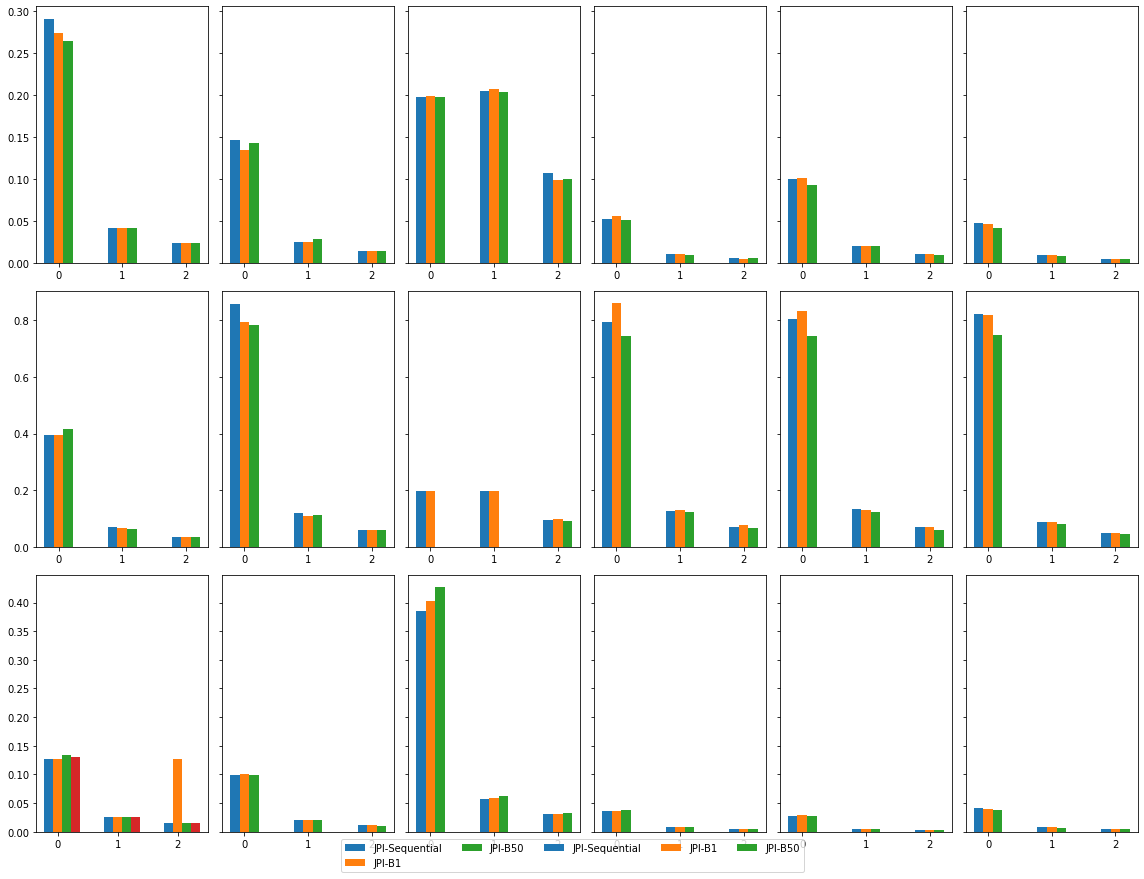

In [205]:
for f,df in zip(freqs, dataframes):
    print(f'\n\n\n----------------- {f} -----------------')
#     gen_graph(df, bars=True, share_y=False, arch=f.title())
#     gen_graph(df, bars=True, share_y=False, log_y=True, arch=arch.title())
    #print(df)
    gen_graph(df, bars=True, arch=f)




----------------- 800 -----------------


algorithm      dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
2   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
3   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
4   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
5   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
6   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
7   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
8   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
9   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
10  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
11  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
12  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
13  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
14  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
15  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
16  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
17  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
18  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
19  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
20  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
21  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
22  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
23  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
24  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
25  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
26  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
27  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           85        84.86     10,184.00  120.01    362.00         123  ...   
1           85        84.86     10,184.00  120.01    362.00         123  ...   
2           85        84.86     10,184.00  120.01    362.00         123  ...   
3           85        84.86     10,184.00  120.01    362.00         123  ...   
4           85        84.86     10,184.00  120.01    362.00         123  ...   
5           85        84.86     10,184.00  120.01    362.00         123  ...   
6           17        15.00      1,800.00  120.01  1,785.00         124  ...   
7           17        15.00      1,800.00  120.01  1,785.00         124  ...   
8           17        15.00      1,800.00  120.01  1,785.00         124  ...   
9           17        15.00      1,800.00  120.01  1,785.00         124  ...   
10          17        15.00      1,800.00  120.01  1,785.00         124  ...   
11          17        15.00      1,800.00  120.01  1,785.00         124  ...   
12         102        99.99     11,980.00  119.81  3,103.00         125  ...   
13         102        99.99     11,980.00  119.81  3,103.00         125  ...   
14         102        99.99     11,980.00  119.81  3,103.00         125  ...   
15         102        99.99     11,980.00  119.81  3,103.00         125  ...   
16          20        20.01      2,400.00  119.96 14,294.00         124  ...   
17          20        20.01      2,400.00  119.96 14,294.00         124  ...   
18          20        20.01      2,400.00  119.96 14,294.00         124  ...   
19          20        20.01      2,400.00  119.96 14,294.00         124  ...   
20          99        94.99     11,381.00  119.81 13,273.00         125  ...   
21          99        94.99     11,381.00  119.81 13,273.00       

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  elecNormNew      4          50         294   
1   LBagExecutorMAXChunk  elecNormNew      4          50         294   
2   LBagExecutorMAXChunk  elecNormNew      4          50         294   
3   LBagExecutorMAXChunk  elecNormNew      4          50         294   
4   LBagExecutorMAXChunk  elecNormNew      4          50         294   
5   LBagExecutorMAXChunk  elecNormNew      4          50         294   
6   LBagExecutorMAXChunk  elecNormNew      4          50         294   
7   LBagExecutorMAXChunk  elecNormNew      4          50         294   
8   LBagExecutorMAXChunk  elecNormNew      4          50         294   
9   LBagExecutorMAXChunk  elecNormNew      4          50         163   
10  LBagExecutorMAXChunk  elecNormNew      4          50         163   
11  LBagExecutorMAXChunk  elecNormNew      4          50         163   
12  LBagExecutorMAXChunk  elecNormNew      4          50         163   
13  LBagExecutorMAXChunk  elecNormNew      4          50         163   
14  LBagExecutorMAXChunk  elecNormNew      4          50         163   
15  LBagExecutorMAXChunk  elecNormNew      4          50         163   
16  LBagExecutorMAXChunk  elecNormNew      4          50         163   
17  LBagExecutorMAXChunk  elecNormNew      4          50         163   
18  LBagExecutorMAXChunk  elecNormNew      4          50          32   
19  LBagExecutorMAXChunk  elecNormNew      4          50          32   
20  LBagExecutorMAXChunk  elecNormNew      4          50          32   
21  LBagExecutorMAXChunk  elecNormNew      4          50          32   
22  LBagExecutorMAXChunk  elecNormNew      4          50          32   
23  LBagExecutorMAXChunk  elecNormNew      4          50          32   
24  LBagExecutorMAXChunk  elecNormNew      4          50          32   
25  LBagExecutorMAXChunk  elecNormNew      4          50          32   
26  LBagExecutorMAXChunk  elecNormNew      4          50          32   
27  LBagExecutorMAXChunk  elecNormNew      4         500         168   
28  LBagExecutorMAXChunk  elecNormNew      4         500         168   
29  LBagExecutorMAXChunk  elecNormNew      4         500         168   
30  LBagExecutorMAXChunk  elecNormNew      4         500         168   
31  LBagExecutorMAXChunk  elecNormNew      4         500          33   
32  LBagExecutorMAXChunk  elecNormNew      4         500          33   
33  LBagExecutorMAXChunk  elecNormNew      4         500          33   
34  LBagExecutorMAXChunk  elecNormNew      4         500          33   
35  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
36  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
37  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
38  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
39  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
40  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
41  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
42  LBagExecutorMAXChunk  elecNormNew      4        2000          30   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        289.74     34,742.00  119.91    108.00         126  ...    108.00   
1        289.74     34,742.00  119.91    108.00         126  ...    182.00   
2        289.74     34,742.00  119.91    108.00         126  ...    876.00   
3        289.74     34,742.00  119.91    108.00         126  ...    108.00   
4        289.74     34,742.00  119.91    108.00         126  ...    182.00   
5        289.74     34,742.00  119.91    108.00         126  ...    876.00   
6        289.74     34,742.00  119.91    108.00         126  ...    108.00   
7        289.74     34,742.00  119.91    108.00         126  ...    182.00   
8        289.74     34,742.00  119.91    108.00         126  ...    876.00   
9        159.90     19,168.00  119.87    182.00         125  ...  

algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
5   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
6   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
7   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
8   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
9   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
10  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
11  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
12  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
13  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
14  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
15  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
16  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
17  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
18  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
19  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           55        54.96      6,600.00  120.10    557.00         125  ...   
1           55        54.96      6,600.00  120.10    557.00         125  ...   
2           55        54.96      6,600.00  120.10    557.00         125  ...   
3           55        54.96      6,600.00  120.10    557.00         125  ...   
4           56        55.00      6,600.00  119.99  5,618.00         125  ...   
5           56        55.00      6,600.00  119.99  5,618.00         125  ...   
6           56        55.00      6,600.00  119.99  5,618.00         125  ...   
7           56        55.00      6,600.00  119.99  5,618.00         125  ...   
8           11        10.00      1,200.00  119.95 25,640.00         125  ...   
9           11        10.00      1,200.00  119.95 25,640.00         125  ...   
10          11        10.00      1,200.00  119.95 25,640.00         125  ...   
11          11        10.00      1,200.00  119.95 25,640.00         125  ...   
12          54        48.66      6,000.00  123.30 25,432.00         129  ...   
13          54        48.66      6,000.00  123.30 25,432.00         129  ...   
14          54        48.66      6,000.00  123.30 25,432.00         129  ...   
15          54        48.66      6,000.00  123.30 25,432.00         129  ...   
16          10        10.00      1,200.00  119.94 74,642.00         134  ...   
17          10        10.00      1,200.00  119.94 74,642.00         134  ...   
18          10        10.00      1,200.00  119.94 74,642.00         134  ...   
19          10        10.00      1,200.00  119.94 74,642.00         134  ...   

    delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0     307.00       124         4.15     1,036.40      99.84     12,000.00   
1   2,651.00       123         4.34     1,076.70       9.99      1,200.00   
2     307.00       124         4.15     1,036.40      99.84     12,000.00   
3   2,651.00       123         4.34     1,076.70       9.99      1,200.00   
4   3,384.00       125         4.51     1,135.50      99.84     12,000.00   
5   5,618.00       125         4.16     1,047.10      54.91      6,600.00   
6   3,384.00       125         4.51     1,135.50      99.84     12,000.00   
7   5,618.00       125         4.16     1,047.10      54.91      6,600.00   
8   3,384.00       1

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
1   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
2   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
3   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
4   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
5   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
6   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
7   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
8   OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
9   OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
10  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
11  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
12  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
13  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
14  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
15  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
16  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
17  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
18  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
19  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
20  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
21  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
22  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
23  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
24  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
25  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
26  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
27  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
28  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
29  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
30  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
31  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
32  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
33  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
34  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
35  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
36  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
37  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
38  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
39  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
40  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
41  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
42  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        404.17     45,312.00  112.11     73.00         118  ...     45.00   
1        404.17     45,312.00  112.11     73.00         118  ...     73.00   
2        404.17     45,312.00  112.11     73.00         118  ...     45.00   
3        404.17     45,312.00  112.11     73.00         118  ...     73.00   
4         79.99      9,584.00  119.81    326.00         125  ...     45.00   
5         79.99      9,584.00  119.81    326.00         125  ...     73.00   

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
1   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
2   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
3   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
4   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
5   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
6   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
7   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
8   OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
9   OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
10  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
11  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
12  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
13  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
14  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
15  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
16  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
17  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
18  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
19  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
20  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
21  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
22  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
23  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        439.45     45,312.00  103.11     65.00         109  ...     40.00   
1        439.45     45,312.00  103.11     65.00         109  ...     65.00   
2        439.45     45,312.00  103.11     65.00         109  ...     40.00   
3        439.45     45,312.00  103.11     65.00         109  ...     65.00   
4         85.00     10,200.00  120.00    309.00         126  ...     40.00   
5         85.00     10,200.00  120.00    309.00         126  ...     65.00   
6         85.00     10,200.00  120.00    309.00         126  ...     40.00   
7         85.00     10,200.00  120.00    309.00         126  ...     65.00   
8        468.78     45,312.00   96.66    663.00         103  ...    413.00   
9        468.78     45,312.00   96.66    663.00         103  ...    663.00   
10       468.78     45,312.00   96.66    663.00         103  ...    413.00   
11       468.78     45,312.00   96.66    663.00         103  ...    663.00   
12        89.99     10,782.00  119.82  2,953.00         125  ...    413.00   
13        89.99     10,782.00  119.82  2,953.00         125  ...    663.00   
14        89.99     10,782.00  119.82  2,953.00         125  ...    413.00   
15        89.99     10,782.00  119.82  2,953.00         125  ...    663.00   
16       409.32     45,312.00  110.70  2,945.00         117  ...  1,988.00   
17       409.32     45,312.00  110.70  2,945.00         117  ...  2,945.00   
18       409.32     45,312.00  110.70  2,945.00         117  ...  1,988.00   
19       409.32     45,312.00  110.70  2,945.00         117  ...  2,945.00   
20        79.87      9,585.00  120.00 13,127.00         125  ...  1,988.00   
21        79.87      9,585.00  120.00 13,127.00         125  ...  2,945.00   
22        79.87      9,585.00  120.00 13,127.00         125  ...  1,988.00   
23        79.87      9,585.00  120.00 13,127.00         125  ...  2,945.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0         62         4.01       505.70    

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
1   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
2   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
3   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
4   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
5   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
6   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
7   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
8   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
9   OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
10  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
11  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
12  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
13  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
14  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
15  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
16  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
17  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
18  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
19  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
20  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
21  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
22  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
23  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
24  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
25  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
26  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
27  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
28  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
29  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
30  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
31  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
32  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
33  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
34  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
35  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
36  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
37  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
38  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
39  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
40  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
41  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
42  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
43  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
44  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
45  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
46  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        857.81     45,312.00   52.82     38.00          59  ...     38.00   
1        857.81     45,312.00   52.82     38.00          59  ...     57.00   
2        857.81     45,312.00   52.82     38.00          59  ...    277.00   
3        857.81     45,312.00   52.82     38.00          59  ...     38.00   
4        857.81     45,312.00   52.82     38.00          59  ...     57.00

algorithm      dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
2   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
3   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
4   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
5   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
6   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
7   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
8   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
9   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
10  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
11  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
12  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
13  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
14  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
15  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
16  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
17  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
18  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
19  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
20  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
21  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
22  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
23  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          143       139.86     16,772.00  119.92    259.00         124  ...   
1          143       139.86     16,772.00  119.92    259.00         124  ...   
2           15        14.99      1,800.00  120.08  1,827.00         124  ...   
3           15        14.99      1,800.00  120.08  1,827.00         124  ...   
4          104        99.99     11,980.00  119.81  3,451.00         125  ...   
5          104        99.99     11,980.00  119.81  3,451.00         125  ...   
6          104        99.99     11,980.00  119.81  3,451.00         125  ...   
7          104        99.99     11,980.00  119.81  3,451.00         125  ...   
8          104        99.99     11,980.00  119.81  3,451.00         125  ...   
9          104        99.99     11,980.00  119.81  3,451.00         125  ...   
10          11        10.00      1,200.00  119.94 26,279.00         125  ...   
11          11        10.00      1,200.00  119.94 26,279.00         125  ...   
12          11        10.00      1,200.00  119.94 26,279.00         125  ...   
13          11        10.00      1,200.00  119.94 26,279.00         125  ...   
14          11        10.00      1,200.00  119.94 26,279.00         125  ...   
15          11        10.00      1,200.00  119.94 26,279.00         125  ...   
16         132       124.64     14,934.00  119.81 11,182.00         127  ...   
17         132       124.64     14,934.00  119.81 11,182.00         127  ...   
18         132       124.64     14,934.00  119.81 11,182.00         127  ...   
19         132       124.64     14,934.00  119.81 11,182.00         127  ...   
20          14        10.00      1,200.00  119.95 69,780.00         138  ...   
21          14        10.00      1,200.00  119.95 69,780.00         138  ...   
22          14        10.00      1,200.00  119.95 69,780.00         138  ...   
23          14        10.00      1,200.00  119.95 69,780.00         138  ...   

    delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0     396.00       125         3.92       988.90    

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
1   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
2   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
3   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
4   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
5   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
6   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
7   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
8   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
9   LBagExecutorMAXChunk  covtypeNorm      4          50          38   
10  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
11  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
12  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
13  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
14  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
15  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
16  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
17  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
18  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
19  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
20  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
21  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
22  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
23  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
24  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
25  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
26  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
27  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
28  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
29  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
30  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
31  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
32  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
33  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
34  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
35  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
36  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
37  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
38  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
39  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
40  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
41  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
42  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
43  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
44  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
45  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
46  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         64.93      7,800.00  120.13    530.00         125  ...    530.00   
1         64.93      7,800.00  120.13    530.00         125  ...    863.00   
2         64.93      7,800.00  120.13    530.00         125  ...  5,206.00   
3         64.93      7,800.00  120.13    530.00         125  ...    530.00   
4         64.93      7,800.00  120.13    530.00         125  ...    863.00   
5         64.93      7,800.00  120.13    530.00         125  ...  5,206.00   
6         64

algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
5   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
6   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
7   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
8   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
9   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
10  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
11  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
12  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
13  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
14  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
15  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
16  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
17  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
18  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
19  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
20  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
21  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
22  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
23  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
24  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
25  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
26  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
27  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
28  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
29  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
30  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
31  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
32  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
33  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
34  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
35  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
36  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
37  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
38  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
39  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
40  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
41  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
42  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
43  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
44  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
45  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
46  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
47  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
48  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
49  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
50  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
1   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
2   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
3   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
4   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
5   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
6   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
7   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
8   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
9   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
10  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
11  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
12  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
13  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
14  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
15  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
16  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
17  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
18  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
19  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
20  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
21  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
22  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
23  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
24  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
25  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
26  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
27  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
28  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
29  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
30  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
31  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
32  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
33  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
34  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
35  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
36  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
37  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
38  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
39  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
40  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
41  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
42  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
43  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
44  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
45  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000          40   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         54.91      6,600.00  120.20    610.00         125  ...    926.00   
1         54.91      6,600.00  120.20    610.00         125  ...  5,141.00   
2         54.91      6,600.00  120.20    610.00         125  ...    926.00

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
1   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
2   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
3   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
4   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
5   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
6   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
7   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
8   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
9   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
10  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
11  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
12  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
13  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
14  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
15  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
16  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           8   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         34.96      4,200.00  120.14    843.00         125  ...    518.00   
1         34.96      4,200.00  120.14    843.00         125  ...    843.00   
2         34.96      4,200.00  120.14    843.00         125  ...    518.00   
3         34.96      4,200.00  120.14    843.00         125  ...    843.00   
4          5.00        600.00  120.04  5,142.00         126  ...    518.00   
5          5.00        600.00  120.04  5,142.00         126  ...    843.00   
6          5.00        600.00  120.04  5,142.00         126  ...    518.00   
7          5.00        600.00  120.04  5,142.00         126  ...    843.00   
8         45.01      5,400.00  119.98  6,542.00         126  ...  4,188.00   
9         45.01      5,400.00  119.98  6,542.00         126  ...  6,542.00   
10        45.01      5,400.00  119.98  6,542.00         126  ...  4,188.00   
11        45.01      5,400.00  119.98  6,542.00         126  ...  6,542.00   
12         5.00        600.00  119.93 45,496.00         126  ...  4,188.00   
13         5.00        600.00  119.93 45,496.00         126  ...  6,542.00   
14         5.00        600.00  119.93 45,496.00         126  ...  4,188.00   
15         5.00        600.00  119.93 45,496.00         126  ...  6,542.00   
16         5.00        600.00  119.94 63,009.00         129  ... 20,167.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        126         3.85       977.90      64.91      7,800.00    462.00   
1        125         3.91       984.10      34.95      4,200.00    469.17   
2        126         3.85       977.90      64.91      7,800.00    462.00   
3        125         3.91       984.10      34.95      4,200.00    469.17   
4        126         3.85       977.90      64.91      7,800.00    462.00   
5        125         3.91       984.10      34.95      4,200.00    469.17   
6        126         3.85       977.90      64.91      7,800.00    462.00   
7        125         3.91       984.10      34.95      4,200.00    469.17   
8        126         4.25     1,079.80      79.87      9,600.00    510.47   
9        126         4.08     1,036.60      44.94      5,400.00    489.64   
10       126         4.25     1,079.80      79.87      9,600.00    510.47   
11       126         4.08     1,036.60      44.94      5,400.00    489.64   
12       126         4.25     1,079.80      79.87      9,600.00    510.47   
13       126         4.08     1,036.60      44.94      5,400.00    489.64   
14       126         4.25     1,079.80      79.87      9

algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
1   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
2   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
3   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
4   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
5   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
6   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
7   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
8   OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
9   OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
10  OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
11  OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
12  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
13  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
14  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
15  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
16  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
17  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
18  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
19  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
20  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
21  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
22  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
23  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         64.91      7,800.00  120.17    525.00         126  ...    813.00   
1         64.91      7,800.00  120.17    525.00         126  ...  5,120.00   
2         64.91      7,800.00  120.17    525.00         126  ...    813.00   
3         64.91      7,800.00  120.17    525.00         126  ...  5,120.00   
4          5.00        600.00  120.02  5,120.00         125  ...    813.00   
5          5.00        600.00  120.02  5,120.00         125  ...  5,120.00   
6          5.00        600.00  120.02  5,120.00         125  ...    813.00   
7          5.00        600.00  120.02  5,120.00         125  ...  5,120.00   
8         65.01      7,800.00  119.99  4,790.00         126  ...  8,036.00   
9         65.01      7,800.00  119.99  4,790.00         126  ... 45,547.00   
10        65.01      7,800.00  119.99  4,790.00         126  ...  8,036.00   
11        65.01      7,800.00  119.99  4,790.00         126  ... 45,547.00   
12         5.00        600.00  119.93 45,547.00         125  ...  8,036.00   
13         5.00        600.00  119.93 45,547.00         125  ... 45,547.00   
14         5.00        600.00  119.93 45,547.00         125  ...  8,036.00   
15         5.00        600.00  119.93 45,547.00         125  ... 45,547.00   
16        89.99     10,782.00  119.81 14,592.00         127  ... 24,135.00   
17        89.99     10,782.00  119.81 14,592.00         127  ... 65,425.00   
18        89.99     10,782.00  119.81 14,592.00         127  ... 24,135.00   
19        89.99     10,782.00  119.81 14,592.00         127  ... 65,425.00   
20        10.01      1,200.00  119.94 65,425.00         131  ... 24,135.00   
21        10.01      1,200.00  119.94 65,425.00         131  ... 65,425.00   
22        10.01      1,200.00  119.94 65,425.00         131  ... 24,135.00   
23        10.01      1,200.00  119.94 65,425.00         131  ... 65,425.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        126         3.80       965.20      34.96      4,200.00    456.39   
1        125         3.94       992.00       4.99        600.

algorithm dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
49  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
50  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
51  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
52  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
53  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
54  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
55  AdaptiveRandomForestExecutorMAXChunk    GMSC      4

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
1   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
2   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
3   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
4   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
5   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
6   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
7   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
8   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
9   LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
10  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
11  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
12  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
13  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
14  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
15  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
16  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
17  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
18  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
19  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
20  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
21  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
22  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
23  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
24  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
25  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
26  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
27  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
28  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
29  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
30  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
31  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
32  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
33  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
34  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
35  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
36  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
37  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
38  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
39  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
40  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
41  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
42  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
43  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
44  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
45  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
46  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
47  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
48  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
49  LBagExecuto

algorithm dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          171       169.86     20,366.00  119.90    187.00         124  ...   
1          171       169.86     20,366.00  119.90    187.00         124  ...   
2           19        15.00      1,800.00  120.01  1,775.00         123  ...   
3           19        15.00      1,800.00  120.01  1,775.00         123  ...   
4          171       169.98     20,366.00  119.81  2,015.00         124  ...   
5          171       169.98     20,366.00  119.81  2,015.00         124  ...   
6          171       169.98     20,366.00  119.81  2,015.00         124  ...   
7          171       169.98     20,366.00  119.81  2,015.00         124  ...   
8           19        15.01      1,800.00  119.95 17,600.00         125  ...   
9           19        15.01      1,800.00  119.95 17,600.00         125  ...   
10          19        15.01      1,800.00  119.95 17,600.00         125  ...   
11          19        15.01      1,800.00  119.95 17,600.00         125  ...   
12         162       159.99     19,168.00  119.81  8,609.00         125 

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
1   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
2   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
3   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
4   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
5   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
6   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
7   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
8   OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
9   OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
10  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
11  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
12  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
13  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
14  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
15  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
16  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
17  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
18  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
19  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
20  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
21  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
22  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
23  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
24  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
25  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
26  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
27  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
28  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
29  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
30  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
31  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
32  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
33  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
34  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
35  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
36  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
37  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
38  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
39  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
40  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
41  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
42  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        614.10     73,677.00  119.98     48.00         126  ...     29.00   
1        614.10     73,677.00  119.98     48.00         126  ...     48.00   
2        614.10     73,677.00  119.98     48.00         126  ...     29.00   
3        614.10     73,677.00  119.98     48.00         126  ...     48.00   
4        119.98     14,376.00  119.82    215.00         125  ...     29.00   
5        119.98     14,376.00  119.82    215.00         125  ...     48.00   
6        119.98     14,376.00  119.82    215.00         125  ...     29.00   
7        119.98     14,376.00  119.82    215.00         125  ...     48.00   
8        963.13    115,414.00  119.83    338.00         125  ..

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
1   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
2   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
3   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
4   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
5   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
6   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
7   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
8   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
9   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
10  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
11  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
12  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
13  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
14  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
15  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
16  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
17  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
18  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
19  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
20  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
21  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
22  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
23  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
24  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
25  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
26  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
27  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
28  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
29  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
30  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
31  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
32  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
33  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
34  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
35  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
36  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
37  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
38  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
39  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
40  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
41  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
42  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
43  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
44  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
45  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
46  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
47  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
48  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
49  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
50  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
51  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
52  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
53  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
54  Oz

algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk    GMSC      4          50         522   
1   OzaBagExecutorMAXChunk    GMSC      4          50         522   
2   OzaBagExecutorMAXChunk    GMSC      4          50         522   
3   OzaBagExecutorMAXChunk    GMSC      4          50         522   
4   OzaBagExecutorMAXChunk    GMSC      4          50         104   
5   OzaBagExecutorMAXChunk    GMSC      4          50         104   
6   OzaBagExecutorMAXChunk    GMSC      4          50         104   
7   OzaBagExecutorMAXChunk    GMSC      4          50         104   
8   OzaBagExecutorMAXChunk    GMSC      4         500         551   
9   OzaBagExecutorMAXChunk    GMSC      4         500         551   
10  OzaBagExecutorMAXChunk    GMSC      4         500         551   
11  OzaBagExecutorMAXChunk    GMSC      4         500         551   
12  OzaBagExecutorMAXChunk    GMSC      4         500         110   
13  OzaBagExecutorMAXChunk    GMSC      4         500         110   
14  OzaBagExecutorMAXChunk    GMSC      4         500         110   
15  OzaBagExecutorMAXChunk    GMSC      4         500         110   
16  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
17  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
18  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
19  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
20  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
21  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
22  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
23  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
24  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
25  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
26  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
27  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
28  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
29  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
30  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
31  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
32  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
33  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
34  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
35  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
36  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
37  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
38  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
39  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
40  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
41  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
42  OzaBagExecutorMAXChunk    GMSC      4        2000         108   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        519.45     62,296.00  119.93     54.00         125  ...     33.00   
1        519.45     62,296.00  119.93     54.00         125  ...     54.00   
2        519.45     62,296.00  119.93     54.00         125  ...     33.00   
3        519.45     62,296.00  119.93     54.00         125  ...     54.00   
4         99.98     11,980.00  119.82    219.00         126  ...     33.00   
5         99.98     11,980.00  119.82    219.00         126  ...     54.00   
6         99.98     11,980.00  119.82    219.00         126  ...     33.00   
7         99.98     11,980.00  119.82    219.00         126  ...     54.00   
8        549.50     65,890.00  119.91    532.00         125  ...    330.00   
9        549.50     65,890.00  119.91    532.00         125  ...    532.00   
10       549.50     65,890.00  119.91    532.00         125  ...    330.00   
11       549.50     65,890.00  119.91    532

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


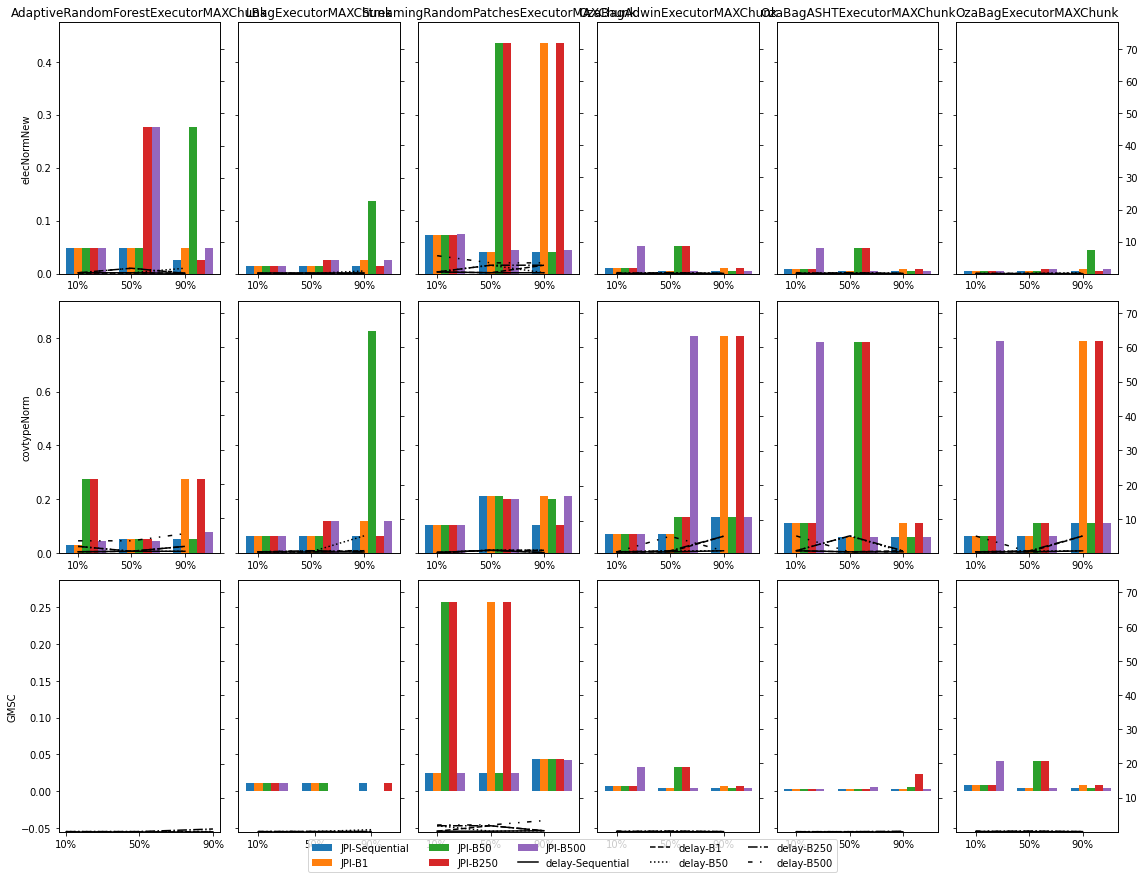




----------------- 1000 -----------------


algorithm      dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          19        15.00      1,800.00  120.01  1,786.00         123  ...   
1          19        15.01      1,800.00  119.96 18,269.00         124  ...   
2          19        15.01      1,800.00  119.95 76,649.00         141  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    179.00       124         4.12     1,029.40     174.67     20,965.00   
1  2,018.00       125         4.17     1,050.90     174.67     20,965.00   
2  8,056.00       125         4.10     1,032.30     174.67     20,965.00   

  joules_90  JPI_90  PERC  tput_90  
0    493.61    0.02    90   174.88  
1    499.76    0.02    90   174.94  
2    490.90    0.02    90   174.70  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  LBagExecutorMAXChunk  elecNormNew      4          50          31   
1  LBagExecutorMAXChunk  elecNormNew      4         500          31   
2  LBagExecutorMAXChunk  elecNormNew      4        2000          31   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        30.00      3,600.00  120.00    876.00         126  ...    109.00   
1        30.01      3,600.00  119.97  9,158.00         126  ...  1,192.00   
2        30.01      3,600.00  119.97 35,801.00         127  ...  4,753.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         4.03     1,022.90     284.36     34,143.00    482.95   
1       125         3.97     1,001.50     284.36     34,143.00    476.43   
2       127         3.97     1,017.00     284.39     34,143.00    476.20   

   JPI_90  PERC  tput_90  
0    0.01    90   284.71  
1    0.01    90   284.81  
2    0.01    90   282.54  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           4        19.99      2,400.00  120.09  1,382.00         125  ...   
1           4        20.01      2,400.00  119.96 14,320.00         125  ...   
2           4        20.01      2,400.00  119.96 54,993.00         126  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    734.00       124         4.27     1,066.80      39.94      4,800.00   
1  7,425.00       124         3.94       985.30      39.94      4,800.00   
2 29,240.00       126         3.98     1,011.50      39.94      4,800.00   

  joules_90  JPI_90  PERC  tput_90  
0    512.43    0.11    90    39.97  
1    472.89    0.10    90    40.00  
2    477.81    0.10    90    40.01  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          79   
1  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          79   
2  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        74.88      8,986.00  120.01    330.00         125  ...     48.00   
1        74.88      8,986.00  120.00  3,567.00         126  ...    493.00   
2        74.88      8,986.00  120.00 13,821.00         126  ...  1,993.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        69         3.99       558.20     712.52     45,312.00    253.00   
1        68         3.74       516.30     712.51     45,312.00    237.22   
2        68         3.73       514.60     712.50     45,312.00    236.45   

   JPI_90  PERC  tput_90  
0    0.01    90   714.09  
1    0.01    90   714.62  
2    0.01    90   708.93  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          41   
1  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          41   
2  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          41   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        40.00      4,800.00  120.00    632.00         125  ...     50.00   
1        40.01      4,800.00  119.99  6,411.00         126  ...    775.00   
2        40.01      4,800.00  119.98 24,383.00         126  ...  3,193.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         3.89       981.40     374.07     44,925.00    467.03   
1       126         4.09     1,039.10     374.08     44,925.00    490.53   
2       125         3.73       938.90     374.11     44,925.00    446.72   

   JPI_90  PERC  tput_90  
0    0.01    90   374.62  
1    0.01    90   374.67  
2    0.01    90   374.69  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  elecNormNew      4          50          92   
1  OzaBagExecutorMAXChunk  elecNormNew      4         500          92   
2  OzaBagExecutorMAXChunk  elecNormNew      4        2000          92   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        89.99     10,782.00  119.82    286.00         126  ...     40.00   
1        89.99     10,782.00  119.81  2,947.00         126  ...    389.00   
2        89.99     10,782.00  119.81 11,682.00         126  ...  1,655.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        60         3.98       485.30     830.06     45,312.00    216.45   
1        60         3.74       456.50     829.91     45,312.00    203.60   
2        59         3.73       447.00     830.21     45,312.00    202.62   

   JPI_90  PERC  tput_90  
0    0.00    90   832.73  
1    0.00    90   832.77  
2    0.00    90   824.21  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          12        10.00      1,200.00  120.04  2,627.00         124  ...   
1          12        10.00      1,200.00  119.94 26,232.00         125  ...   
2          12        10.00      1,200.00  119.94 71,651.00         136  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    316.00       124         4.00       999.50     109.81     13,178.00   
1  3,213.00       125         3.84       966.90     109.81     13,178.00   
2 13,173.00       126         3.88       986.30     109.81     13,178.00   

  joules_90  JPI_90  PERC  tput_90  
0    479.05    0.04    90   109.98  
1    459.72    0.03    90   109.99  
2    465.25    0.04    90   109.99  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
1  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
2  LBagExecutorMAXChunk  covtypeNorm      4        2000           7   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.01  5,183.00         126  ...    545.00   
1         5.00        600.00  119.94 47,589.00         126  ...  5,279.00   
2         5.00        600.00  119.94 65,191.00         130  ... 22,060.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         3.88       986.20      64.90      7,800.00    466.50   
1       127         3.87       989.60      64.90      7,800.00    463.88   
2       132         3.98     1,057.40      64.90      7,800.00    477.01   

   JPI_90  PERC  tput_90  
0    0.06    90    64.92  
1    0.06    90    65.00  
2    0.06    90    65.00  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           4        19.97      2,400.00  120.20  1,519.00         125  ...   
1           4        20.01      2,400.00  119.95 16,125.00         126  ...   
2           4          NaN           NaN     NaN       NaN         618  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    872.00       125         3.87       975.50      39.95      4,800.00   
1  8,792.00       125         4.04     1,018.40      39.94      4,800.00   
2 34,001.00       128         3.72       960.70      39.95      4,800.00   

  joules_90  JPI_90  PERC  tput_90  
0    465.35    0.10    90    39.93  
1    484.86    0.10    90    40.01  
2    446.74    0.09    90    40.01  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
1  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
2  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000           6   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.06  5,235.00         125  ...    571.00   
1         5.00        600.00  119.94 46,542.00         126  ...  6,160.00   
2         5.00        600.00  119.94 63,390.00         128  ... 21,764.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         3.93       999.00      54.91      6,600.00    472.48   
1       125         4.19     1,055.30      54.92      6,600.00    502.74   
2       127         3.72       952.40      54.92      6,600.00    446.40   

   JPI_90  PERC  tput_90  
0    0.07    90    54.94  
1    0.08    90    54.14  
2    0.07    90    55.00  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
1  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           6   
2  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           6   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.04  5,143.00         125  ...    547.00   
1         5.00        600.00  119.94 45,524.00         126  ...  5,138.00   
2         5.00        600.00  119.94 63,144.00         128  ... 19,913.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         4.23     1,066.30      59.91      7,200.00    508.49   
1       125         4.18     1,054.10      59.91      7,200.00    501.95   
2       128         3.72       960.30      59.91      7,200.00    446.65   

   JPI_90  PERC  tput_90  
0    0.07    90    59.91  
1    0.07    90    60.00  
2    0.06    90    60.00  

[3 rows x 46 columns]

algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
1  OzaBagExecutorMAXChunk  covtypeNorm      4         500           9   
2  OzaBagExecutorMAXChunk  covtypeNorm      4        2000           9   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.02  5,121.00         125  ...    430.00   
1         5.00        600.00  119.93 45,555.00         126  ...  4,223.00   
2         5.00        600.00  119.93 63,174.00         129  ... 16,186.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         4.25     1,070.70      84.86     10,183.00    509.04   
1       125         4.32     1,088.50      84.86     10,200.00    518.34   
2       127         3.70        14.80      84.86     10,200.00    454.55   

   JPI_90  PERC  tput_90  
0    0.05    90    84.99  
1    0.05    90    84.87  
2    0.05    90    81.40  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
3  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          32        30.00      3,600.00  120.00    870.00         140  ...   
1          32        30.00      3,600.00  120.00    870.00         140  ...   
2          32        30.01      3,600.00  119.97  9,074.00         125  ...   
3          32        30.01      3,600.00  119.97 35,813.00         126  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    105.00       124         4.29     1,073.00     289.37     34,742.00   
1    870.00       140         3.82     1,076.30      29.96      3,600.00   
2  1,213.00       124         4.36     1,091.20     289.39     34,742.00   
3  4,796.00       124         4.22     1,055.30     289.40     34,742.00   

  joules_90  JPI_90  PERC  tput_90  
0    514.62    0.01    90   289.75  
1    458.01    0.13    90    30.00  
2    523.19    0.02    90   289.84  
3    505.96    0.01    90   289.85  

[4 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
1  LBagExecutorMAXChunk    GMSC      4         500          41        40.01   
2  LBagExecutorMAXChunk    GMSC      4        2000          41        40.01   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0      4,800.00  120.02    650.00         125  ...     86.00       125   
1      4,800.00  119.98  6,721.00         126  ...    927.00       126   
2      4,800.00  119.98 25,312.00         126  ...  3,724.00       126   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.11     1,034.50     369.15     44,326.00    492.26    0.01    90   
1         4.10     1,041.10     369.15     44,326.00    491.40    0.01    90   
2         3.90       990.30     369.17     44,326.00    468.09    0.01    90   

   tput_90  
0   369.65  
1   369.73  
2   366.48  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
2  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          14        10.00      1,200.00  120.03  2,598.00         124  ...   
1          14        10.00      1,200.00  119.94 25,462.00         124  ...   
2          14        10.00      1,200.00  119.95 68,421.00         132  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    197.00       123         3.97       984.80      69.89      8,400.00   
1  2,580.00       125         3.95       996.40     124.79     14,975.00   
2 10,794.00       125         4.03     1,015.50     124.79     15,000.00   

  joules_90  JPI_90  PERC  tput_90  
0    475.79    0.03    90   124.98  
1    473.74    0.03    90   124.99  
2    483.60    0.03    90   124.79  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         110   
1  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         110   
2  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         110   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       109.99     13,178.00  119.82    235.00         126  ...     32.00   
1       109.82     13,179.00  120.01  2,432.00         125  ...    338.00   
2       109.82     13,179.00  120.01  9,624.00         125  ...  1,372.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         3.96       996.70     991.30    119,002.00    474.22   
1       126         4.12     1,047.60     991.42    119,002.00    494.58   
2       126         3.99     1,012.60     991.44    119,002.00    477.75   

   JPI_90  PERC  tput_90  
0    0.00    90   992.51  
1    0.00    90   992.38  
2    0.00    90   993.02  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk    GMSC      4          50         153   
1  OzaBagASHTExecutorMAXChunk    GMSC      4         500         153   
2  OzaBagASHTExecutorMAXChunk    GMSC      4        2000         153   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       149.97     17,970.00  119.82    147.00         126  ...     24.00   
1       149.98     17,970.00  119.81  1,793.00         125  ...    246.00   
2       149.97     17,970.00  119.82  7,321.00         126  ...  1,039.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       115         4.02       933.60   1,372.71    150,000.00    439.14   
1       115         4.10       950.10   1,372.85    150,000.00    447.02   
2       114         3.99       917.80   1,372.70    150,000.00    436.62   

   JPI_90  PERC  tput_90  
0    0.00    90 1,374.55  
1    0.00    90 1,374.18  
2    0.00    90 1,370.91  

[3 rows x 46 columns]

algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  OzaBagExecutorMAXChunk    GMSC      4          50         109       104.83   
1  OzaBagExecutorMAXChunk    GMSC      4         500         109       105.00   
2  OzaBagExecutorMAXChunk    GMSC      4        2000         109       105.00   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0     12,580.00  120.01    248.00         126  ...     32.00       126   
1     12,600.00  120.00  2,544.00         126  ...    330.00       126   
2     12,600.00  120.00 10,054.00         126  ...  1,367.00       125   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.12     1,046.80     981.39    117,806.00    494.10    0.00    90   
1         4.01     1,017.70     981.54    117,806.00    480.15    0.00    90   
2         4.02     1,014.20     981.56    117,806.00    482.26    0.00    90   

   tput_90  
0   982.62  
1   983.06  
2   983.13  

[3 rows x 46 columns]

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


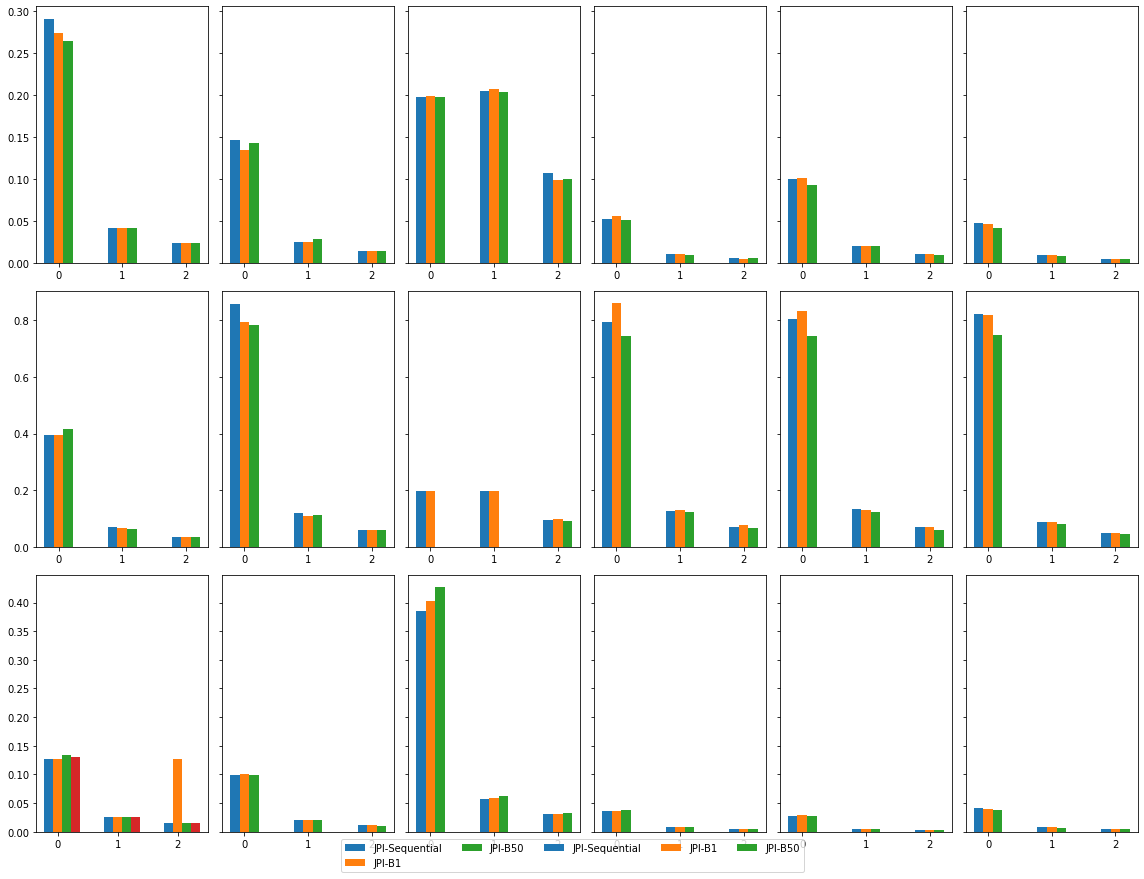

In [206]:
freqs = ['800', '1000']
for freq, df in zip(freqs,dataframes):
    print(f'\n\n\n----------------- {freq} -----------------')
    gen_graph(df, bars=True, arch=freq.title())

In [207]:
def aux2_tput(df, ax, mTput, legend=False, title=False, ylabels=False, ds='', bar=False, share_y=False, log_y=False, norm=False, hide=True):
    if norm:
        df = my_norm(df, x=norm)
    global rate
    width = 0.15
    alg_order = ['Sequential', 'B1', 'B50', 'B250', 'B500']
    labels = ['10%', '50%', '90%']
    line_format = ['-', '--', ':', '-.', (0, (3, 5, 1, 5, 1, 5))]
    linfo = '--'
    x = np.arange(len(labels))
    lns_l = []
    versions = len(alg_order)

    for i in range(versions):
        try:
            adf = df.iloc[i]
            values = [adf.tput_10, adf.tput_50, adf.tput_90]
            if bar:
                lns_l += ax.bar(x - ((1 - i) * width), values, width, label=f'Tput-{alg_order[i]}')
            else:
                lns_l += ax.plot(x, values, label=f'Tput-{alg_order[i]}')
        except IndexError:
            return None

    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    if log_y:
        ax.set_yscale('log')
    if title:
        alg_title = re.sub('Sequential', '', df.algorithm.iloc[0])
        ax.set_title(f'{alg_title}')
    if ylabels:
        ax.set_ylabel(ds)
    if last:
        ax.set_ymargin(2)
    labs = [l.get_label() for l in lns_l]
    if legend:
        ax.legend(lns_l, labs, loc=0)
    if share_y == 'row':
        ax.set_ylim(bottom=0, top=mTput)

In [208]:
def aux_tput(ds, axis, id_ds, df, bar=False, share_y='row', log_y=False, norm=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    global title
    global labels
    hide_axis = True
#     get max value from delay for all rates on all algorithms for this dataset
    mLstTput = []
    if share_y == 'row':
        for rt in rates:
            rtDF = df[df.PERC == rt]
            mLstTput.append(rtDF.tput.max())
        mTput = max(mLstTput)*1.05
    else:
        mTput = 0
    for alg in algs:
        dsalgdf = filter_by_substring_algorithm(df, alg).sort_values(['algorithm','batch_size','cores'])
        for rt in rates:
            print(rt)
            if rt == '10':
                showdf = rename_columns_by_rate(dsalgdf[dsalgdf.PERC == rt])
            else:
                to_join = dsalgdf[dsalgdf.PERC == rt]
                showdf = showdf.merge(rename_columns_by_rate(to_join),
                                  on=['algorithm', 'dataset', 'batch_size', 'cores']).sort_values(['batch_size','cores'])
        # debug print, if it shows it is wrong
        if len(showdf) != 5:
            display(showdf)   
        display(showdf[['algorithm','dataset','batch_size','cores','tput_10', 'tput_50', 'tput_90']])
        if 'Ada' in alg:
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, ylabels=True, ds=ds, bar=bar, share_y=share_y, log_y=log_y, norm=norm)
        else:
            if algs[-1] == alg:
                hide_axis = False
            aux2_tput(showdf, axis[id_ds][algs.index(alg)], mTput, title=title, bar=bar, share_y=share_y, log_y=log_y, norm=norm, hide=hide_axis)

In [209]:
def show_tput(df, share_y='row', bars=False, log_y=False, norm=False, arch='Vostro'):
    print(f'{arch}\nshare_y: {share_y}\nlog_y: {log_y}\nnorm: {norm}')
    #datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm', 'kyoto_binary']
    datasets = ['GMSC', 'elecNormNew', 'covtypeNorm']
    fig, axis = plt.subplots(len(datasets), 6, figsize=(16,12), tight_layout=True, sharey=share_y)
    global title
    global labels
    global last
    global twin
    leg = False
    labls = True
    title = True
    last = False
    twin = axis[0][0]
#     for ds in ['airlines']:
    for ds in datasets:
        if datasets.index(ds) == (len(datasets) - 1):
            last = True

        dsdf = df[df.dataset == ds]               
        aux_tput(ds, axis, datasets.index(ds), dsdf, bar=bars, share_y=share_y, log_y=log_y, norm=norm)
        title = False
    lines, labels = axis[0][0].get_legend_handles_labels()
    lgd = fig.legend(lines, labels, loc=8, ncol=5, bbox_to_anchor=(0.5, -0.02))
    lgd.set_in_layout(True)
    fig.subplots_adjust(bottom=-0.5)
    filename = 'all-Tput'
    if bars:
        filename = f'bars-{filename}'
    if share_y:
        filename = f'sharey-{filename}'
    if log_y:
        filename = f'logy-{filename}'
    plt.savefig(f'../figures/{arch}-{filename}.eps', pad_inches=0.2, bbox_inches='tight')
    plt.savefig(f'../figures/{arch}-{filename}.png', pad_inches=0.2, bbox_inches='tight')
    plt.show()




----------------- 800 -----------------
800
share_y: row
log_y: False
norm: False
10
50
90


algorithm dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
49  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
50  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
51  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
52  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
53  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
54  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
55  AdaptiveRandomForestExecutorMAXChunk    GMSC      4

algorithm dataset  batch_size  cores  tput_10  \
0   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
1   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
2   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
3   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
4   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
5   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
6   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
7   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
8   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
9   AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
10  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
11  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
12  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
13  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
14  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
15  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   284.76   
16  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
17  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
18  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
19  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
20  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
21  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
22  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
23  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
24  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
25  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
26  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
27  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
28  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
29  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
30  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
31  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4   159.91   
32  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
33  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
34  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
35  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
36  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
37  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
38  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
39  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
40  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
41  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
42  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
43  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
44  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
45  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
46  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
47  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
48  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
49  AdaptiveRandomForestExecuto

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
1   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
2   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
3   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
4   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
5   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
6   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
7   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
8   LBagExecutorMAXChunk    GMSC      4          50         369       364.64   
9   LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
10  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
11  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
12  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
13  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
14  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
15  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
16  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
17  LBagExecutorMAXChunk    GMSC      4          50         205       204.86   
18  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
19  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
20  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
21  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
22  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
23  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
24  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
25  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
26  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
27  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
28  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
29  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
30  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
31  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
32  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
33  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
34  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
35  LBagExecutorMAXChunk    GMSC      4         500         378       374.74   
36  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
37  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
38  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
39  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
40  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
41  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
42  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
43  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
44  LBagExecutorMAXChunk    GMSC      4         500         210       209.94   
45  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
46  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
47  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
48  LBagExecutorMAXChunk    GMSC      4         500          42        40.01   
49  LBagExecuto

algorithm dataset  batch_size  cores  tput_10  tput_50  tput_90
0   LBagExecutorMAXChunk    GMSC          50      4   364.64   364.64   364.64
1   LBagExecutorMAXChunk    GMSC          50      4   364.64   364.64   204.86
2   LBagExecutorMAXChunk    GMSC          50      4   364.64   364.64    39.99
3   LBagExecutorMAXChunk    GMSC          50      4   364.64   204.86   364.64
4   LBagExecutorMAXChunk    GMSC          50      4   364.64   204.86   204.86
5   LBagExecutorMAXChunk    GMSC          50      4   364.64   204.86    39.99
6   LBagExecutorMAXChunk    GMSC          50      4   364.64    39.99   364.64
7   LBagExecutorMAXChunk    GMSC          50      4   364.64    39.99   204.86
8   LBagExecutorMAXChunk    GMSC          50      4   364.64    39.99    39.99
9   LBagExecutorMAXChunk    GMSC          50      4   204.86   364.64   364.64
10  LBagExecutorMAXChunk    GMSC          50      4   204.86   364.64   204.86
11  LBagExecutorMAXChunk    GMSC          50      4   204.86   364.64    39.99
12  LBagExecutorMAXChunk    GMSC          50      4   204.86   204.86   364.64
13  LBagExecutorMAXChunk    GMSC          50      4   204.86   204.86   204.86
14  LBagExecutorMAXChunk    GMSC          50      4   204.86   204.86    39.99
15  LBagExecutorMAXChunk    GMSC          50      4   204.86    39.99   364.64
16  LBagExecutorMAXChunk    GMSC          50      4   204.86    39.99   204.86
17  LBagExecutorMAXChunk    GMSC          50      4   204.86    39.99    39.99
18  LBagExecutorMAXChunk    GMSC          50      4    39.99   364.64   364.64
19  LBagExecutorMAXChunk    GMSC          50      4    39.99   364.64   204.86
20  LBagExecutorMAXChunk    GMSC          50      4    39.99   364.64    39.99
21  LBagExecutorMAXChunk    GMSC          50      4    39.99   204.86   364.64
22  LBagExecutorMAXChunk    GMSC          50      4    39.99   204.86   204.86
23  LBagExecutorMAXChunk    GMSC          50      4    39.99   204.86    39.99
24  LBagExecutorMAXChunk    GMSC          50      4    39.99    39.99   364.64
25  LBagExecutorMAXChunk    GMSC          50      4    39.99    39.99   204.86
26  LBagExecutorMAXChunk    GMSC          50      4    39.99    39.99    39.99
27  LBagExecutorMAXChunk    GMSC         500      4   374.74   374.74   374.74
28  LBagExecutorMAXChunk    GMSC         500      4   374.74   374.74   209.94
29  LBagExecutorMAXChunk    GMSC         500      4   374.74   374.74    40.01
30  LBagExecutorMAXChunk    GMSC         500      4   374.74   209.94   374.74
31  LBagExecutorMAXChunk    GMSC         500      4   374.74   209.94   209.94
32  LBagExecutorMAXChunk    GMSC         500      4   374.74   209.94    40.01
33  LBagExecutorMAXChunk    GMSC         500      4   374.74    40.01   374.74
34  LBagExecutorMAXChunk    GMSC         500      4   374.74    40.01   209.94
35  LBagExecutorMAXChunk    GMSC         500      4   374.74    40.01    40.01
36  LBagExecutorMAXChunk    GMSC         500      4   209.94   374.74   374.74
37  LBagExecutorMAXChunk    GMSC         500      4   209.94   374.74   209.94
38  LBagExecutorMAXChunk    GMSC         500      4   209.94   374.74    40.01
39  LBagExecutorMAXChunk    GMSC         500      4   209.94   209.94   374.74
40  LBagExecutorMAXChunk    GMSC         500      4   209.94   209.94   209.94
41  LBagExecutorMAXChunk    GMSC         500      4   209.94   209.94    40.01
42  LBagExecutorMAXChunk    GMSC         500      4   209.94    40.01   374.74
43  LBagExecutorMAXChunk    GMSC         500      4   209.94    40.01   209.94
44  LBagExecutorMAXChunk    GMSC         500      4   209.94    40.01    40.01
45  LBagExecutorMAXChunk    GMSC         500      4    40.01   374.74   374.74
46  LBagExecutorMAXChunk    GMSC         500      4    40.01   374.74   209.94
47  LBagExecutorMAXChunk    GMSC         500      4    40.01   374.74    40.01
48  LBagExecutorMAXChunk    GMSC         500      4    40.01   209.94   374.74
49  LBagExecutorMAXChunk    GMSC         500      4    40.01   20

10
50
90


algorithm dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          171       169.86     20,366.00  119.90    187.00         124  ...   
1          171       169.86     20,366.00  119.90    187.00         124  ...   
2           19        15.00      1,800.00  120.01  1,775.00         123  ...   
3           19        15.00      1,800.00  120.01  1,775.00         123  ...   
4          171       169.98     20,366.00  119.81  2,015.00         124  ...   
5          171       169.98     20,366.00  119.81  2,015.00         124  ...   
6          171       169.98     20,366.00  119.81  2,015.00         124  ...   
7          171       169.98     20,366.00  119.81  2,015.00         124  ...   
8           19        15.01      1,800.00  119.95 17,600.00         125  ...   
9           19        15.01      1,800.00  119.95 17,600.00         125  ...   
10          19        15.01      1,800.00  119.95 17,600.00         125  ...   
11          19        15.01      1,800.00  119.95 17,600.00         125  ...   
12         162       159.99     19,168.00  119.81  8,609.00         125 

algorithm dataset  batch_size  cores  \
0   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
1   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
2   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
3   StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4   
4   StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
5   StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
6   StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
7   StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
8   StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
9   StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
10  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
11  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4   
12  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
13  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
14  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
15  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
16  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
17  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
18  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
19  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
20  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
21  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
22  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
23  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
24  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
25  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
26  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
27  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
28  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
29  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
30  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
31  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
32  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
33  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
34  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
35  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
36  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
37  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   
38  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4   

    tput_10  tput_50  tput_90  
0    169.86   169.86    94.84  
1    169.86    15.00    94.84  
2     15.00   169.86    94.84  
3     15.00    15.00    94.84  
4    169.98   169.98    94.85  
5    169.98   169.98    15.01  
6    169.98    94.85    94.85  
7    169.98    94.85    15.01  
8     15.01   169.98    94.85  
9     15.01   169.98    15.01  
10    15.01    94.85    94.85  
11    15.01    94.85    15.01  
12   159.99   159.99   159.99  
13   159.99   159.99    89.86  
14   159.99   159.99    15.01  
15   159.99    89.86   159.99  
16   159.99    89.86    89.86  
17   159.99    89.86    15.01  
18   159.99    15.01   159.99  
19   159.99    15.01    89.86  
20   159.99    15.01    15.01  
21    89.86   159.99   159.99  
22    89.86   159.99    89.86  
23    89.86   159.99    15.01  
24    89.86    89.86   159.99  
25    89.86    89.86    89.86  
26    89.86    89.86    15.01  
27    89.86    15.01   159.99  
28    89.86    15.01    89.86  
29    89.86    15.01    15.01  
30    15.01   159.99   159.99  
31    15.01   159.99    89.86  
32    15.01   159.99    15.01  
33    15.01    89.86   1

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
1   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
2   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
3   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         619   
4   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
5   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
6   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
7   OzaBagAdwinExecutorMAXChunk    GMSC      4          50         123   
8   OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
9   OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
10  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
11  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
12  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
13  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
14  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
15  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
16  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         968   
17  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
18  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
19  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
20  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
21  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
22  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
23  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
24  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
25  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         537   
26  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
27  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
28  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
29  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
30  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
31  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
32  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
33  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
34  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         107   
35  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
36  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
37  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
38  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         449   
39  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
40  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
41  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   
42  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000          89   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        614.10     73,677.00  119.98     48.00         126  ...     29.00   
1        614.10     73,677.00  119.98     48.00         126  ...     48.00   
2        614.10     73,677.00  119.98     48.00         126  ...     29.00   
3        614.10     73,677.00  119.98     48.00         126  ...     48.00   
4        119.98     14,376.00  119.82    215.00         125  ...     29.00   
5        119.98     14,376.00  119.82    215.00         125  ...     48.00   
6        119.98     14,376.00  119.82    215.00         125  ...     29.00   
7        119.98     14,376.00  119.82    215.00         125  ...     48.00   
8        963.13    115,414.00  119.83    338.00         125  ..

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   614.10 1,107.31   
1   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   614.10 1,107.31   
2   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   614.10   119.98   
3   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   614.10   119.98   
4   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   119.98 1,107.31   
5   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   119.98 1,107.31   
6   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   119.98   119.98   
7   OzaBagAdwinExecutorMAXChunk    GMSC          50      4   119.98   119.98   
8   OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   963.13   
9   OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   963.13   
10  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   963.13   
11  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   533.30   
12  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   533.30   
13  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   533.30   
14  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   104.83   
15  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   104.83   
16  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   963.13   104.83   
17  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   963.13   
18  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   963.13   
19  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   963.13   
20  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   533.30   
21  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   533.30   
22  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   533.30   
23  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   104.83   
24  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   104.83   
25  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   533.30   104.83   
26  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   963.13   
27  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   963.13   
28  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   963.13   
29  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   533.30   
30  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   533.30   
31  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   533.30   
32  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   104.83   
33  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   104.83   
34  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   104.83   104.83   
35  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   444.64   803.78   
36  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   444.64   803.78   
37  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   444.64    84.90   
38  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   444.64    84.90   
39  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4    84.90   803.78   
40  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4    84.90   803.78   
41  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4    84.90    84.90   
42  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4    84.90    84.90   

    tput_90  
0  1,107.31  
1    614.10  
2  1,107.31  
3    614.10  
4  1,107.31  
5    614.10  
6  1,107.31  
7    614.10  
8    963.13  
9    533.30  
10   104.83  
11   963.13  
12   533.30  
13   104.83  
14   963.13  
15   533.30  
16   104.83  
17   963.13  
18   533.30  
19   104.83  
20   963.13  
21   533.30  
22   104.83  
23   963.13  
24   533.30  
25   104.83  
26   963.13  
27   533.30  
28   104.83  
29   963.13  
30   533.30  
31   104.83  
32   963.13  
33   533.30  
34   104.83

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
1   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
2   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
3   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
4   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
5   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
6   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
7   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
8   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
9   OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
10  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
11  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
12  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
13  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
14  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
15  OzaBagASHTExecutorMAXChunk    GMSC      4          50        1530   
16  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
17  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
18  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
19  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
20  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
21  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
22  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
23  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
24  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
25  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
26  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
27  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
28  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
29  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
30  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
31  OzaBagASHTExecutorMAXChunk    GMSC      4          50         850   
32  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
33  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
34  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
35  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
36  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
37  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
38  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
39  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
40  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
41  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
42  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
43  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
44  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
45  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
46  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
47  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
48  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
49  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
50  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
51  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
52  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
53  OzaBagASHTExecutorMAXChunk    GMSC      4          50         170   
54  Oz

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13 1,525.13   
1   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13 1,525.13   
2   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13 1,525.13   
3   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13 1,525.13   
4   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
5   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
6   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
7   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
8   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
9   OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
10  OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
11  OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   847.15   
12  OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   169.96   
13  OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   169.96   
14  OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   169.96   
15  OzaBagASHTExecutorMAXChunk    GMSC          50      4 1,525.13   169.96   
16  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15 1,525.13   
17  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15 1,525.13   
18  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15 1,525.13   
19  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15 1,525.13   
20  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
21  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
22  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
23  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
24  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
25  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
26  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
27  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   847.15   
28  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   169.96   
29  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   169.96   
30  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   169.96   
31  OzaBagASHTExecutorMAXChunk    GMSC          50      4   847.15   169.96   
32  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96 1,525.13   
33  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96 1,525.13   
34  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96 1,525.13   
35  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96 1,525.13   
36  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
37  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
38  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
39  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
40  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
41  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
42  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
43  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   847.15   
44  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   169.96   
45  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   169.96   
46  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   169.96   
47  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96   169.96   
48  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96 1,525.13   
49  OzaBagASHTExecutorMAXChunk    GMSC          50      4   169.96 1,52

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk    GMSC      4          50         522   
1   OzaBagExecutorMAXChunk    GMSC      4          50         522   
2   OzaBagExecutorMAXChunk    GMSC      4          50         522   
3   OzaBagExecutorMAXChunk    GMSC      4          50         522   
4   OzaBagExecutorMAXChunk    GMSC      4          50         104   
5   OzaBagExecutorMAXChunk    GMSC      4          50         104   
6   OzaBagExecutorMAXChunk    GMSC      4          50         104   
7   OzaBagExecutorMAXChunk    GMSC      4          50         104   
8   OzaBagExecutorMAXChunk    GMSC      4         500         551   
9   OzaBagExecutorMAXChunk    GMSC      4         500         551   
10  OzaBagExecutorMAXChunk    GMSC      4         500         551   
11  OzaBagExecutorMAXChunk    GMSC      4         500         551   
12  OzaBagExecutorMAXChunk    GMSC      4         500         110   
13  OzaBagExecutorMAXChunk    GMSC      4         500         110   
14  OzaBagExecutorMAXChunk    GMSC      4         500         110   
15  OzaBagExecutorMAXChunk    GMSC      4         500         110   
16  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
17  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
18  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
19  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
20  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
21  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
22  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
23  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
24  OzaBagExecutorMAXChunk    GMSC      4        2000         977   
25  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
26  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
27  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
28  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
29  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
30  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
31  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
32  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
33  OzaBagExecutorMAXChunk    GMSC      4        2000         543   
34  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
35  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
36  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
37  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
38  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
39  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
40  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
41  OzaBagExecutorMAXChunk    GMSC      4        2000         108   
42  OzaBagExecutorMAXChunk    GMSC      4        2000         108   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        519.45     62,296.00  119.93     54.00         125  ...     33.00   
1        519.45     62,296.00  119.93     54.00         125  ...     54.00   
2        519.45     62,296.00  119.93     54.00         125  ...     33.00   
3        519.45     62,296.00  119.93     54.00         125  ...     54.00   
4         99.98     11,980.00  119.82    219.00         126  ...     33.00   
5         99.98     11,980.00  119.82    219.00         126  ...     54.00   
6         99.98     11,980.00  119.82    219.00         126  ...     33.00   
7         99.98     11,980.00  119.82    219.00         126  ...     54.00   
8        549.50     65,890.00  119.91    532.00         125  ...    330.00   
9        549.50     65,890.00  119.91    532.00         125  ...    532.00   
10       549.50     65,890.00  119.91    532.00         125  ...    330.00   
11       549.50     65,890.00  119.91    532

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagExecutorMAXChunk    GMSC          50      4   519.45   937.74   
1   OzaBagExecutorMAXChunk    GMSC          50      4   519.45   937.74   
2   OzaBagExecutorMAXChunk    GMSC          50      4   519.45    99.98   
3   OzaBagExecutorMAXChunk    GMSC          50      4   519.45    99.98   
4   OzaBagExecutorMAXChunk    GMSC          50      4    99.98   937.74   
5   OzaBagExecutorMAXChunk    GMSC          50      4    99.98   937.74   
6   OzaBagExecutorMAXChunk    GMSC          50      4    99.98    99.98   
7   OzaBagExecutorMAXChunk    GMSC          50      4    99.98    99.98   
8   OzaBagExecutorMAXChunk    GMSC         500      4   549.50   988.03   
9   OzaBagExecutorMAXChunk    GMSC         500      4   549.50   988.03   
10  OzaBagExecutorMAXChunk    GMSC         500      4   549.50   109.82   
11  OzaBagExecutorMAXChunk    GMSC         500      4   549.50   109.82   
12  OzaBagExecutorMAXChunk    GMSC         500      4   109.82   988.03   
13  OzaBagExecutorMAXChunk    GMSC         500      4   109.82   988.03   
14  OzaBagExecutorMAXChunk    GMSC         500      4   109.82   109.82   
15  OzaBagExecutorMAXChunk    GMSC         500      4   109.82   109.82   
16  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   973.14   
17  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   973.14   
18  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   973.14   
19  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   539.47   
20  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   539.47   
21  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   539.47   
22  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   104.83   
23  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   104.83   
24  OzaBagExecutorMAXChunk    GMSC        2000      4   973.14   104.83   
25  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   973.14   
26  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   973.14   
27  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   973.14   
28  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   539.47   
29  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   539.47   
30  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   539.47   
31  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   104.83   
32  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   104.83   
33  OzaBagExecutorMAXChunk    GMSC        2000      4   539.47   104.83   
34  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   973.14   
35  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   973.14   
36  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   973.14   
37  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   539.47   
38  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   539.47   
39  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   539.47   
40  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   104.83   
41  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   104.83   
42  OzaBagExecutorMAXChunk    GMSC        2000      4   104.83   104.83   

    tput_90  
0    937.74  
1    519.45  
2    937.74  
3    519.45  
4    937.74  
5    519.45  
6    937.74  
7    519.45  
8    988.03  
9    549.50  
10   988.03  
11   549.50  
12   988.03  
13   549.50  
14   988.03  
15   549.50  
16   973.14  
17   539.47  
18   104.83  
19   973.14  
20   539.47  
21   104.83  
22   973.14  
23   539.47  
24   104.83  
25   973.14  
26   539.47  
27   104.83  
28   973.14  
29   539.47  
30   104.83  
31   973.14  
32   539.47  
33   104.83  
34   973.14  
35   539.47  
36   104.83  
37   973.14  
38   539.47  
39   104.83  
40   973.14  
41   539.47  
42   104.83

10
50
90


algorithm      dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
2   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
3   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
4   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
5   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
6   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
7   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
8   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
9   AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
10  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
11  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
12  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
13  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
14  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
15  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
16  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
17  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
18  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
19  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
20  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
21  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
22  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
23  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
24  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
25  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
26  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   
27  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           85        84.86     10,184.00  120.01    362.00         123  ...   
1           85        84.86     10,184.00  120.01    362.00         123  ...   
2           85        84.86     10,184.00  120.01    362.00         123  ...   
3           85        84.86     10,184.00  120.01    362.00         123  ...   
4           85        84.86     10,184.00  120.01    362.00         123  ...   
5           85        84.86     10,184.00  120.01    362.00         123  ...   
6           17        15.00      1,800.00  120.01  1,785.00         124  ...   
7           17        15.00      1,800.00  120.01  1,785.00         124  ...   
8           17        15.00      1,800.00  120.01  1,785.00         124  ...   
9           17        15.00      1,800.00  120.01  1,785.00         124  ...   
10          17        15.00      1,800.00  120.01  1,785.00         124  ...   
11          17        15.00      1,800.00  120.01  1,785.00         124  ...   
12         102        99.99     11,980.00  119.81  3,103.00         125  ...   
13         102        99.99     11,980.00  119.81  3,103.00         125  ...   
14         102        99.99     11,980.00  119.81  3,103.00         125  ...   
15         102        99.99     11,980.00  119.81  3,103.00         125  ...   
16          20        20.01      2,400.00  119.96 14,294.00         124  ...   
17          20        20.01      2,400.00  119.96 14,294.00         124  ...   
18          20        20.01      2,400.00  119.96 14,294.00         124  ...   
19          20        20.01      2,400.00  119.96 14,294.00         124  ...   
20          99        94.99     11,381.00  119.81 13,273.00         125  ...   
21          99        94.99     11,381.00  119.81 13,273.00       

algorithm      dataset  batch_size  cores  \
0   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
1   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
2   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
3   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
4   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
5   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
6   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
7   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
8   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
9   AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
10  AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
11  AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
12  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
13  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
14  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
15  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
16  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
17  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
18  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
19  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
20  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   
21  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   
22  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   
23  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   
24  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   
25  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   
26  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   
27  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   

    tput_10  tput_50  tput_90  
0     84.86    84.86   149.90  
1     84.86    84.86    84.86  
2     84.86    84.86    15.00  
3     84.86    15.00   149.90  
4     84.86    15.00    84.86  
5     84.86    15.00    15.00  
6     15.00    84.86   149.90  
7     15.00    84.86    84.86  
8     15.00    84.86    15.00  
9     15.00    15.00   149.90  
10    15.00    15.00    84.86  
11    15.00    15.00    15.00  
12    99.99   184.94   184.94  
13    99.99   184.94    99.99  
14    99.99    20.01   184.94  
15    99.99    20.01    99.99  
16    20.01   184.94   184.94  
17    20.01   184.94    99.99  
18    20.01    20.01   184.94  
19    20.01    20.01    99.99  
20    94.99   174.96   174.96  
21    94.99   174.96    94.99  
22    94.99    15.01   174.96  
23    94.99    15.01    94.99  
24    15.01   174.96   174.96  
25    15.01   174.96    94.99  
26    15.01    15.01   174.96  
27    15.01    15.01    94.99

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  elecNormNew      4          50         294   
1   LBagExecutorMAXChunk  elecNormNew      4          50         294   
2   LBagExecutorMAXChunk  elecNormNew      4          50         294   
3   LBagExecutorMAXChunk  elecNormNew      4          50         294   
4   LBagExecutorMAXChunk  elecNormNew      4          50         294   
5   LBagExecutorMAXChunk  elecNormNew      4          50         294   
6   LBagExecutorMAXChunk  elecNormNew      4          50         294   
7   LBagExecutorMAXChunk  elecNormNew      4          50         294   
8   LBagExecutorMAXChunk  elecNormNew      4          50         294   
9   LBagExecutorMAXChunk  elecNormNew      4          50         163   
10  LBagExecutorMAXChunk  elecNormNew      4          50         163   
11  LBagExecutorMAXChunk  elecNormNew      4          50         163   
12  LBagExecutorMAXChunk  elecNormNew      4          50         163   
13  LBagExecutorMAXChunk  elecNormNew      4          50         163   
14  LBagExecutorMAXChunk  elecNormNew      4          50         163   
15  LBagExecutorMAXChunk  elecNormNew      4          50         163   
16  LBagExecutorMAXChunk  elecNormNew      4          50         163   
17  LBagExecutorMAXChunk  elecNormNew      4          50         163   
18  LBagExecutorMAXChunk  elecNormNew      4          50          32   
19  LBagExecutorMAXChunk  elecNormNew      4          50          32   
20  LBagExecutorMAXChunk  elecNormNew      4          50          32   
21  LBagExecutorMAXChunk  elecNormNew      4          50          32   
22  LBagExecutorMAXChunk  elecNormNew      4          50          32   
23  LBagExecutorMAXChunk  elecNormNew      4          50          32   
24  LBagExecutorMAXChunk  elecNormNew      4          50          32   
25  LBagExecutorMAXChunk  elecNormNew      4          50          32   
26  LBagExecutorMAXChunk  elecNormNew      4          50          32   
27  LBagExecutorMAXChunk  elecNormNew      4         500         168   
28  LBagExecutorMAXChunk  elecNormNew      4         500         168   
29  LBagExecutorMAXChunk  elecNormNew      4         500         168   
30  LBagExecutorMAXChunk  elecNormNew      4         500         168   
31  LBagExecutorMAXChunk  elecNormNew      4         500          33   
32  LBagExecutorMAXChunk  elecNormNew      4         500          33   
33  LBagExecutorMAXChunk  elecNormNew      4         500          33   
34  LBagExecutorMAXChunk  elecNormNew      4         500          33   
35  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
36  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
37  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
38  LBagExecutorMAXChunk  elecNormNew      4        2000         152   
39  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
40  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
41  LBagExecutorMAXChunk  elecNormNew      4        2000          30   
42  LBagExecutorMAXChunk  elecNormNew      4        2000          30   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        289.74     34,742.00  119.91    108.00         126  ...    108.00   
1        289.74     34,742.00  119.91    108.00         126  ...    182.00   
2        289.74     34,742.00  119.91    108.00         126  ...    876.00   
3        289.74     34,742.00  119.91    108.00         126  ...    108.00   
4        289.74     34,742.00  119.91    108.00         126  ...    182.00   
5        289.74     34,742.00  119.91    108.00         126  ...    876.00   
6        289.74     34,742.00  119.91    108.00         126  ...    108.00   
7        289.74     34,742.00  119.91    108.00         126  ...    182.00   
8        289.74     34,742.00  119.91    108.00         126  ...    876.00   
9        159.90     19,168.00  119.87    182.00         125  ...  

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0   LBagExecutorMAXChunk  elecNormNew          50      4   289.74   289.74   
1   LBagExecutorMAXChunk  elecNormNew          50      4   289.74   289.74   
2   LBagExecutorMAXChunk  elecNormNew          50      4   289.74   289.74   
3   LBagExecutorMAXChunk  elecNormNew          50      4   289.74   159.90   
4   LBagExecutorMAXChunk  elecNormNew          50      4   289.74   159.90   
5   LBagExecutorMAXChunk  elecNormNew          50      4   289.74   159.90   
6   LBagExecutorMAXChunk  elecNormNew          50      4   289.74    30.00   
7   LBagExecutorMAXChunk  elecNormNew          50      4   289.74    30.00   
8   LBagExecutorMAXChunk  elecNormNew          50      4   289.74    30.00   
9   LBagExecutorMAXChunk  elecNormNew          50      4   159.90   289.74   
10  LBagExecutorMAXChunk  elecNormNew          50      4   159.90   289.74   
11  LBagExecutorMAXChunk  elecNormNew          50      4   159.90   289.74   
12  LBagExecutorMAXChunk  elecNormNew          50      4   159.90   159.90   
13  LBagExecutorMAXChunk  elecNormNew          50      4   159.90   159.90   
14  LBagExecutorMAXChunk  elecNormNew          50      4   159.90   159.90   
15  LBagExecutorMAXChunk  elecNormNew          50      4   159.90    30.00   
16  LBagExecutorMAXChunk  elecNormNew          50      4   159.90    30.00   
17  LBagExecutorMAXChunk  elecNormNew          50      4   159.90    30.00   
18  LBagExecutorMAXChunk  elecNormNew          50      4    30.00   289.74   
19  LBagExecutorMAXChunk  elecNormNew          50      4    30.00   289.74   
20  LBagExecutorMAXChunk  elecNormNew          50      4    30.00   289.74   
21  LBagExecutorMAXChunk  elecNormNew          50      4    30.00   159.90   
22  LBagExecutorMAXChunk  elecNormNew          50      4    30.00   159.90   
23  LBagExecutorMAXChunk  elecNormNew          50      4    30.00   159.90   
24  LBagExecutorMAXChunk  elecNormNew          50      4    30.00    30.00   
25  LBagExecutorMAXChunk  elecNormNew          50      4    30.00    30.00   
26  LBagExecutorMAXChunk  elecNormNew          50      4    30.00    30.00   
27  LBagExecutorMAXChunk  elecNormNew         500      4   164.96   299.82   
28  LBagExecutorMAXChunk  elecNormNew         500      4   164.96   299.82   
29  LBagExecutorMAXChunk  elecNormNew         500      4   164.96    30.01   
30  LBagExecutorMAXChunk  elecNormNew         500      4   164.96    30.01   
31  LBagExecutorMAXChunk  elecNormNew         500      4    30.01   299.82   
32  LBagExecutorMAXChunk  elecNormNew         500      4    30.01   299.82   
33  LBagExecutorMAXChunk  elecNormNew         500      4    30.01    30.01   
34  LBagExecutorMAXChunk  elecNormNew         500      4    30.01    30.01   
35  LBagExecutorMAXChunk  elecNormNew        2000      4   149.97   269.85   
36  LBagExecutorMAXChunk  elecNormNew        2000      4   149.97   269.85   
37  LBagExecutorMAXChunk  elecNormNew        2000      4   149.97    30.01   
38  LBagExecutorMAXChunk  elecNormNew        2000      4   149.97    30.01   
39  LBagExecutorMAXChunk  elecNormNew        2000      4    30.01   269.85   
40  LBagExecutorMAXChunk  elecNormNew        2000      4    30.01   269.85   
41  LBagExecutorMAXChunk  elecNormNew        2000      4    30.01    30.01   
42  LBagExecutorMAXChunk  elecNormNew        2000      4    30.01    30.01   

    tput_90  
0    289.74  
1    159.90  
2     30.00  
3    289.74  
4    159.90  
5     30.00  
6    289.74  
7    159.90  
8     30.00  
9    289.74  
10   159.90  
11    30.00  
12   289.74  
13   159.90  
14    30.00  
15   289.74  
16   159.90  
17    30.00  
18   289.74  
19   159.90  
20    30.00  
21   289.74  
22   159.90  
23    30.00  
24   289.74  
25   159.90  
26    30.00  
27   299.82  
28   164.96  
29   299.82  
30   164.96  
31   299.82  
32   164.96  
33   299.82  
34   164.96  
35   269.85  
36   149.97  
37   269.85  
38   149.97  
39   269.85  
40   149

10
50
90


algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
5   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
6   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
7   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
8   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
9   StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
10  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
11  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
12  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
13  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
14  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
15  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
16  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
17  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
18  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   
19  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           55        54.96      6,600.00  120.10    557.00         125  ...   
1           55        54.96      6,600.00  120.10    557.00         125  ...   
2           55        54.96      6,600.00  120.10    557.00         125  ...   
3           55        54.96      6,600.00  120.10    557.00         125  ...   
4           56        55.00      6,600.00  119.99  5,618.00         125  ...   
5           56        55.00      6,600.00  119.99  5,618.00         125  ...   
6           56        55.00      6,600.00  119.99  5,618.00         125  ...   
7           56        55.00      6,600.00  119.99  5,618.00         125  ...   
8           11        10.00      1,200.00  119.95 25,640.00         125  ...   
9           11        10.00      1,200.00  119.95 25,640.00         125  ...   
10          11        10.00      1,200.00  119.95 25,640.00         125  ...   
11          11        10.00      1,200.00  119.95 25,640.00         125  ...   
12          54        48.66      6,000.00  123.30 25,432.00         129  ...   
13          54        48.66      6,000.00  123.30 25,432.00         129  ...   
14          54        48.66      6,000.00  123.30 25,432.00         129  ...   
15          54        48.66      6,000.00  123.30 25,432.00         129  ...   
16          10        10.00      1,200.00  119.94 74,642.00         134  ...   
17          10        10.00      1,200.00  119.94 74,642.00         134  ...   
18          10        10.00      1,200.00  119.94 74,642.00         134  ...   
19          10        10.00      1,200.00  119.94 74,642.00         134  ...   

    delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0     307.00       124         4.15     1,036.40      99.84     12,000.00   
1   2,651.00       123         4.34     1,076.70       9.99      1,200.00   
2     307.00       124         4.15     1,036.40      99.84     12,000.00   
3   2,651.00       123         4.34     1,076.70       9.99      1,200.00   
4   3,384.00       125         4.51     1,135.50      99.84     12,000.00   
5   5,618.00       125         4.16     1,047.10      54.91      6,600.00   
6   3,384.00       125         4.51     1,135.50      99.84     12,000.00   
7   5,618.00       125         4.16     1,047.10      54.91      6,600.00   
8   3,384.00       1

algorithm      dataset  batch_size  cores  \
0   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
1   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
2   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
3   StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
4   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
5   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
6   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
7   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
8   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
9   StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
10  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
11  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
12  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   
13  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   
14  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   
15  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   
16  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   
17  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   
18  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   
19  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   

    tput_10  tput_50  tput_90  
0     54.96    99.99    99.99  
1     54.96    99.99     9.99  
2     54.96     9.99    99.99  
3     54.96     9.99     9.99  
4     55.00    99.98    99.98  
5     55.00    99.98    55.00  
6     55.00    10.00    99.98  
7     55.00    10.00    55.00  
8     10.00    99.98    99.98  
9     10.00    99.98    55.00  
10    10.00    10.00    99.98  
11    10.00    10.00    55.00  
12    48.66    94.99    94.99  
13    48.66    94.99    48.66  
14    48.66    10.00    94.99  
15    48.66    10.00    48.66  
16    10.00    94.99    94.99  
17    10.00    94.99    48.66  
18    10.00    10.00    94.99  
19    10.00    10.00    48.66

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
1   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
2   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
3   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50         409   
4   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
5   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
6   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
7   OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          81   
8   OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
9   OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
10  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
11  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500         429   
12  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
13  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
14  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
15  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          85   
16  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
17  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
18  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
19  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
20  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
21  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
22  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
23  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
24  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         717   
25  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
26  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
27  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
28  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
29  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
30  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
31  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
32  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
33  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000         398   
34  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
35  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
36  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
37  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
38  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
39  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
40  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
41  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   
42  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        404.17     45,312.00  112.11     73.00         118  ...     45.00   
1        404.17     45,312.00  112.11     73.00         118  ...     73.00   
2        404.17     45,312.00  112.11     73.00         118  ...     45.00   
3        404.17     45,312.00  112.11     73.00         118  ...     73.00   
4         79.99      9,584.00  119.81    326.00         125  ...     45.00   
5         79.99      9,584.00  119.81    326.00         125  ...     73.00   

algorithm      dataset  batch_size  cores  tput_10  \
0   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   404.17   
1   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   404.17   
2   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   404.17   
3   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4   404.17   
4   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    79.99   
5   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    79.99   
6   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    79.99   
7   OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    79.99   
8   OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4   423.96   
9   OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4   423.96   
10  OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4   423.96   
11  OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4   423.96   
12  OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4    84.87   
13  OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4    84.87   
14  OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4    84.87   
15  OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4    84.87   
16  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
17  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
18  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
19  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
20  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
21  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
22  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
23  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
24  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   711.30   
25  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
26  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
27  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
28  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
29  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
30  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
31  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
32  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
33  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4   394.37   
34  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
35  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
36  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
37  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
38  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
39  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
40  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
41  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   
42  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   

    tput_50  tput_90  
0    733.01   733.01  
1    733.01   404.17  
2     79.99   733.01  
3     79.99   404.17  
4    733.01   733.01  
5    733.01   404.17  
6     79.99   733.01  
7     79.99   404.17  
8    768.14   768.14  
9    768.14   423.96  
10    84.87   768.14  
11    84.87   423.96  
12   768.14   768.14  
13   768.14   423.96  
14    84.87   768.14  
15    84.87   423.96  
16   711.30   711.30  
17   711.30   394.37  
18   711.30    74.88  
19   394.37   711.30  
20   394.37   394.37  
21   394.37    74.88  
22    74.88   711.30  
23    74.88   394.37  
24    74.88    74.88  
25   711.30   711.30  
26   711.30   394.37  
27   711.30    74.88  
28   394.3

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
1   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
2   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
3   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50         442   
4   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
5   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
6   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
7   OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          88   
8   OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
9   OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
10  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
11  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500         470   
12  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
13  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
14  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
15  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          94   
16  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
17  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
18  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
19  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000         410   
20  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
21  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
22  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   
23  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          82   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        439.45     45,312.00  103.11     65.00         109  ...     40.00   
1        439.45     45,312.00  103.11     65.00         109  ...     65.00   
2        439.45     45,312.00  103.11     65.00         109  ...     40.00   
3        439.45     45,312.00  103.11     65.00         109  ...     65.00   
4         85.00     10,200.00  120.00    309.00         126  ...     40.00   
5         85.00     10,200.00  120.00    309.00         126  ...     65.00   
6         85.00     10,200.00  120.00    309.00         126  ...     40.00   
7         85.00     10,200.00  120.00    309.00         126  ...     65.00   
8        468.78     45,312.00   96.66    663.00         103  ...    413.00   
9        468.78     45,312.00   96.66    663.00         103  ...    663.00   
10       468.78     45,312.00   96.66    663.00         103  ...    413.00   
11       468.78     45,312.00   96.66    663.00         103  ...    663.00   
12        89.99     10,782.00  119.82  2,953.00         125  ...    413.00   
13        89.99     10,782.00  119.82  2,953.00         125  ...    663.00   
14        89.99     10,782.00  119.82  2,953.00         125  ...    413.00   
15        89.99     10,782.00  119.82  2,953.00         125  ...    663.00   
16       409.32     45,312.00  110.70  2,945.00         117  ...  1,988.00   
17       409.32     45,312.00  110.70  2,945.00         117  ...  2,945.00   
18       409.32     45,312.00  110.70  2,945.00         117  ...  1,988.00   
19       409.32     45,312.00  110.70  2,945.00         117  ...  2,945.00   
20        79.87      9,585.00  120.00 13,127.00         125  ...  1,988.00   
21        79.87      9,585.00  120.00 13,127.00         125  ...  2,945.00   
22        79.87      9,585.00  120.00 13,127.00         125  ...  1,988.00   
23        79.87      9,585.00  120.00 13,127.00         125  ...  2,945.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0         62         4.01       505.70    

algorithm      dataset  batch_size  cores  tput_10  \
0   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   439.45   
1   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   439.45   
2   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   439.45   
3   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4   439.45   
4   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    85.00   
5   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    85.00   
6   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    85.00   
7   OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    85.00   
8   OzaBagASHTExecutorMAXChunk  elecNormNew         500      4   468.78   
9   OzaBagASHTExecutorMAXChunk  elecNormNew         500      4   468.78   
10  OzaBagASHTExecutorMAXChunk  elecNormNew         500      4   468.78   
11  OzaBagASHTExecutorMAXChunk  elecNormNew         500      4   468.78   
12  OzaBagASHTExecutorMAXChunk  elecNormNew         500      4    89.99   
13  OzaBagASHTExecutorMAXChunk  elecNormNew         500      4    89.99   
14  OzaBagASHTExecutorMAXChunk  elecNormNew         500      4    89.99   
15  OzaBagASHTExecutorMAXChunk  elecNormNew         500      4    89.99   
16  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4   409.32   
17  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4   409.32   
18  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4   409.32   
19  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4   409.32   
20  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4    79.87   
21  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4    79.87   
22  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4    79.87   
23  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4    79.87   

    tput_50  tput_90  
0    794.32   794.32  
1    794.32   439.45  
2     85.00   794.32  
3     85.00   439.45  
4    794.32   794.32  
5    794.32   439.45  
6     85.00   794.32  
7     85.00   439.45  
8    842.12   842.12  
9    842.12   468.78  
10    89.99   842.12  
11    89.99   468.78  
12   842.12   842.12  
13   842.12   468.78  
14    89.99   842.12  
15    89.99   468.78  
16   721.43   721.43  
17   721.43   409.32  
18    79.87   721.43  
19    79.87   409.32  
20   721.43   721.43  
21   721.43   409.32  
22    79.87   721.43  
23    79.87   409.32

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
1   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
2   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
3   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
4   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
5   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
6   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
7   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
8   OzaBagExecutorMAXChunk  elecNormNew      4          50         862   
9   OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
10  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
11  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
12  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
13  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
14  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
15  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
16  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
17  OzaBagExecutorMAXChunk  elecNormNew      4          50         479   
18  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
19  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
20  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
21  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
22  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
23  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
24  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
25  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
26  OzaBagExecutorMAXChunk  elecNormNew      4          50          95   
27  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
28  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
29  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
30  OzaBagExecutorMAXChunk  elecNormNew      4         500         471   
31  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
32  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
33  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
34  OzaBagExecutorMAXChunk  elecNormNew      4         500          94   
35  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
36  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
37  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
38  OzaBagExecutorMAXChunk  elecNormNew      4        2000         857   
39  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
40  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
41  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
42  OzaBagExecutorMAXChunk  elecNormNew      4        2000         476   
43  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
44  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
45  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   
46  OzaBagExecutorMAXChunk  elecNormNew      4        2000          95   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        857.81     45,312.00   52.82     38.00          59  ...     38.00   
1        857.81     45,312.00   52.82     38.00          59  ...     57.00   
2        857.81     45,312.00   52.82     38.00          59  ...    277.00   
3        857.81     45,312.00   52.82     38.00          59  ...     38.00   
4        857.81     45,312.00   52.82     38.00          59  ...     57.00

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81   857.81   
1   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81   857.81   
2   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81   857.81   
3   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81   474.64   
4   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81   474.64   
5   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81   474.64   
6   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81    94.99   
7   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81    94.99   
8   OzaBagExecutorMAXChunk  elecNormNew          50      4   857.81    94.99   
9   OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64   857.81   
10  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64   857.81   
11  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64   857.81   
12  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64   474.64   
13  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64   474.64   
14  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64   474.64   
15  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64    94.99   
16  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64    94.99   
17  OzaBagExecutorMAXChunk  elecNormNew          50      4   474.64    94.99   
18  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99   857.81   
19  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99   857.81   
20  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99   857.81   
21  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99   474.64   
22  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99   474.64   
23  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99   474.64   
24  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99    94.99   
25  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99    94.99   
26  OzaBagExecutorMAXChunk  elecNormNew          50      4    94.99    94.99   
27  OzaBagExecutorMAXChunk  elecNormNew         500      4   468.78   842.20   
28  OzaBagExecutorMAXChunk  elecNormNew         500      4   468.78   842.20   
29  OzaBagExecutorMAXChunk  elecNormNew         500      4   468.78    89.99   
30  OzaBagExecutorMAXChunk  elecNormNew         500      4   468.78    89.99   
31  OzaBagExecutorMAXChunk  elecNormNew         500      4    89.99   842.20   
32  OzaBagExecutorMAXChunk  elecNormNew         500      4    89.99   842.20   
33  OzaBagExecutorMAXChunk  elecNormNew         500      4    89.99    89.99   
34  OzaBagExecutorMAXChunk  elecNormNew         500      4    89.99    89.99   
35  OzaBagExecutorMAXChunk  elecNormNew        2000      4   844.63   474.71   
36  OzaBagExecutorMAXChunk  elecNormNew        2000      4   844.63   474.71   
37  OzaBagExecutorMAXChunk  elecNormNew        2000      4   844.63    94.85   
38  OzaBagExecutorMAXChunk  elecNormNew        2000      4   844.63    94.85   
39  OzaBagExecutorMAXChunk  elecNormNew        2000      4   474.71   474.71   
40  OzaBagExecutorMAXChunk  elecNormNew        2000      4   474.71   474.71   
41  OzaBagExecutorMAXChunk  elecNormNew        2000      4   474.71    94.85   
42  OzaBagExecutorMAXChunk  elecNormNew        2000      4   474.71    94.85   
43  OzaBagExecutorMAXChunk  elecNormNew        2000      4    94.85   474.71   
44  OzaBagExecutorMAXChunk  elecNormNew        2000      4    94.85   474.71   
45  OzaBagExecutorMAXChunk  elecNormNew        2000      4    94.85    94.85   
46  OzaBagExecutorMAXChunk  elecNormNew        2000      4    94.85    94.85   

    tput_90  
0    857.81  
1    474.64  
2     94.99  
3    857.81  
4    474.64  
5     94.99  
6    857.81  
7    474.64  
8     94.99  
9    857.81  
10   474.64  
11    94

10
50
90


algorithm      dataset  cores  batch_size  \
0   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
2   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
3   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
4   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
5   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
6   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
7   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
8   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
9   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
10  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
11  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
12  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
13  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
14  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
15  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
16  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
17  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
18  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
19  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
20  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
21  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
22  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   
23  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

    inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          143       139.86     16,772.00  119.92    259.00         124  ...   
1          143       139.86     16,772.00  119.92    259.00         124  ...   
2           15        14.99      1,800.00  120.08  1,827.00         124  ...   
3           15        14.99      1,800.00  120.08  1,827.00         124  ...   
4          104        99.99     11,980.00  119.81  3,451.00         125  ...   
5          104        99.99     11,980.00  119.81  3,451.00         125  ...   
6          104        99.99     11,980.00  119.81  3,451.00         125  ...   
7          104        99.99     11,980.00  119.81  3,451.00         125  ...   
8          104        99.99     11,980.00  119.81  3,451.00         125  ...   
9          104        99.99     11,980.00  119.81  3,451.00         125  ...   
10          11        10.00      1,200.00  119.94 26,279.00         125  ...   
11          11        10.00      1,200.00  119.94 26,279.00         125  ...   
12          11        10.00      1,200.00  119.94 26,279.00         125  ...   
13          11        10.00      1,200.00  119.94 26,279.00         125  ...   
14          11        10.00      1,200.00  119.94 26,279.00         125  ...   
15          11        10.00      1,200.00  119.94 26,279.00         125  ...   
16         132       124.64     14,934.00  119.81 11,182.00         127  ...   
17         132       124.64     14,934.00  119.81 11,182.00         127  ...   
18         132       124.64     14,934.00  119.81 11,182.00         127  ...   
19         132       124.64     14,934.00  119.81 11,182.00         127  ...   
20          14        10.00      1,200.00  119.95 69,780.00         138  ...   
21          14        10.00      1,200.00  119.95 69,780.00         138  ...   
22          14        10.00      1,200.00  119.95 69,780.00         138  ...   
23          14        10.00      1,200.00  119.95 69,780.00         138  ...   

    delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0     396.00       125         3.92       988.90    

algorithm      dataset  batch_size  cores  \
0   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
1   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
2   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
3   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
4   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
5   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
6   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
7   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
8   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
9   AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
10  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
11  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
12  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
13  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
14  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
15  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
16  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   
17  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   
18  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   
19  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   
20  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   
21  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   
22  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   
23  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   

    tput_10  tput_50  tput_90  
0    139.86    74.93    74.93  
1    139.86    74.93    14.99  
2     14.99    74.93    74.93  
3     14.99    74.93    14.99  
4     99.99    99.99    55.00  
5     99.99    99.99    10.00  
6     99.99    55.00    55.00  
7     99.99    55.00    10.00  
8     99.99    10.00    55.00  
9     99.99    10.00    10.00  
10    10.00    99.99    55.00  
11    10.00    99.99    10.00  
12    10.00    55.00    55.00  
13    10.00    55.00    10.00  
14    10.00    10.00    55.00  
15    10.00    10.00    10.00  
16   124.64   124.64    70.00  
17   124.64   124.64    10.00  
18   124.64    70.00    70.00  
19   124.64    70.00    10.00  
20    10.00   124.64    70.00  
21    10.00   124.64    10.00  
22    10.00    70.00    70.00  
23    10.00    70.00    10.00

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
1   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
2   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
3   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
4   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
5   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
6   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
7   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
8   LBagExecutorMAXChunk  covtypeNorm      4          50          68   
9   LBagExecutorMAXChunk  covtypeNorm      4          50          38   
10  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
11  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
12  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
13  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
14  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
15  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
16  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
17  LBagExecutorMAXChunk  covtypeNorm      4          50          38   
18  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
19  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
20  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
21  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
22  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
23  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
24  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
25  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
26  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
27  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
28  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
29  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
30  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
31  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
32  LBagExecutorMAXChunk  covtypeNorm      4         500          39   
33  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
34  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
35  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
36  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
37  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
38  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
39  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
40  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
41  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
42  LBagExecutorMAXChunk  covtypeNorm      4        2000          41   
43  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
44  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
45  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   
46  LBagExecutorMAXChunk  covtypeNorm      4        2000           8   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         64.93      7,800.00  120.13    530.00         125  ...    530.00   
1         64.93      7,800.00  120.13    530.00         125  ...    863.00   
2         64.93      7,800.00  120.13    530.00         125  ...  5,206.00   
3         64.93      7,800.00  120.13    530.00         125  ...    530.00   
4         64.93      7,800.00  120.13    530.00         125  ...    863.00   
5         64.93      7,800.00  120.13    530.00         125  ...  5,206.00   
6         64

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93    64.93   
1   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93    64.93   
2   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93    64.93   
3   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93    34.96   
4   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93    34.96   
5   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93    34.96   
6   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93     5.00   
7   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93     5.00   
8   LBagExecutorMAXChunk  covtypeNorm          50      4    64.93     5.00   
9   LBagExecutorMAXChunk  covtypeNorm          50      4    34.96    64.93   
10  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96    64.93   
11  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96    64.93   
12  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96    34.96   
13  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96    34.96   
14  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96    34.96   
15  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96     5.00   
16  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96     5.00   
17  LBagExecutorMAXChunk  covtypeNorm          50      4    34.96     5.00   
18  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00    64.93   
19  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00    64.93   
20  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00    64.93   
21  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00    34.96   
22  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00    34.96   
23  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00    34.96   
24  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00     5.00   
25  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00     5.00   
26  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00     5.00   
27  LBagExecutorMAXChunk  covtypeNorm         500      4    35.01    70.00   
28  LBagExecutorMAXChunk  covtypeNorm         500      4    35.01    70.00   
29  LBagExecutorMAXChunk  covtypeNorm         500      4    35.01    70.00   
30  LBagExecutorMAXChunk  covtypeNorm         500      4    35.01     5.00   
31  LBagExecutorMAXChunk  covtypeNorm         500      4    35.01     5.00   
32  LBagExecutorMAXChunk  covtypeNorm         500      4    35.01     5.00   
33  LBagExecutorMAXChunk  covtypeNorm         500      4     5.00    70.00   
34  LBagExecutorMAXChunk  covtypeNorm         500      4     5.00    70.00   
35  LBagExecutorMAXChunk  covtypeNorm         500      4     5.00    70.00   
36  LBagExecutorMAXChunk  covtypeNorm         500      4     5.00     5.00   
37  LBagExecutorMAXChunk  covtypeNorm         500      4     5.00     5.00   
38  LBagExecutorMAXChunk  covtypeNorm         500      4     5.00     5.00   
39  LBagExecutorMAXChunk  covtypeNorm        2000      4    40.01    66.61   
40  LBagExecutorMAXChunk  covtypeNorm        2000      4    40.01    66.61   
41  LBagExecutorMAXChunk  covtypeNorm        2000      4    40.01     5.00   
42  LBagExecutorMAXChunk  covtypeNorm        2000      4    40.01     5.00   
43  LBagExecutorMAXChunk  covtypeNorm        2000      4     5.00    66.61   
44  LBagExecutorMAXChunk  covtypeNorm        2000      4     5.00    66.61   
45  LBagExecutorMAXChunk  covtypeNorm        2000      4     5.00     5.00   
46  LBagExecutorMAXChunk  covtypeNorm        2000      4     5.00     5.00   

    tput_90  
0     64.93  
1     34.96  
2      5.00  
3     64.93  
4     34.96  
5      5.00  
6     64.93  
7     34.96  
8      5.00  
9     64.93  
10    34.96  
11     5.00  
12    64.93  
13    34.96  
14     5.00  
15    64.93  
16    34.96  
17     5.00  
18  

10
50
90


algorithm      dataset  cores  batch_size  \
0   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
2   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
3   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
4   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
5   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
6   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
7   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
8   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
9   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
10  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
11  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
12  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
13  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
14  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
15  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
16  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
17  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
18  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
19  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
20  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
21  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
22  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
23  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
24  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
25  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
26  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
27  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
28  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
29  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
30  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
31  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
32  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
33  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
34  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
35  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
36  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
37  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
38  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
39  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
40  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
41  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
42  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
43  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
44  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
45  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
46  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
47  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
48  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
49  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   
50  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm

algorithm      dataset  batch_size  cores  \
0   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
1   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
2   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
3   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
4   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
5   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
6   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
7   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
8   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
9   StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
10  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
11  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
12  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
13  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
14  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
15  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
16  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
17  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
18  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
19  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
20  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
21  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
22  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
23  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
24  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
25  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
26  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
27  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
28  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
29  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
30  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
31  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
32  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
33  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
34  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
35  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
36  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
37  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
38  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
39  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
40  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
41  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
42  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
43  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
44  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
45  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        2000      4   
46  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        2000      4   
47  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        2000      4   
48  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        2000      4   
49  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        2000      4   
50  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
1   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
2   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
3   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
4   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
5   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          59   
6   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
7   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
8   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
9   OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
10  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
11  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50          32   
12  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
13  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
14  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
15  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
16  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
17  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
18  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
19  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
20  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
21  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
22  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
23  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
24  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
25  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
26  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          58   
27  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
28  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
29  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
30  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
31  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
32  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
33  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
34  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
35  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500          32   
36  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
37  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
38  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
39  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
40  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
41  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
42  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
43  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
44  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
45  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000          40   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         54.91      6,600.00  120.20    610.00         125  ...    926.00   
1         54.91      6,600.00  120.20    610.00         125  ...  5,141.00   
2         54.91      6,600.00  120.20    610.00         125  ...    926.00

algorithm      dataset  batch_size  cores  tput_10  \
0   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    54.91   
1   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    54.91   
2   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    54.91   
3   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    54.91   
4   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    54.91   
5   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    54.91   
6   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    29.97   
7   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    29.97   
8   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    29.97   
9   OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    29.97   
10  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    29.97   
11  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4    29.97   
12  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4     5.00   
13  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4     5.00   
14  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4     5.00   
15  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4     5.00   
16  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4     5.00   
17  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4     5.00   
18  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
19  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
20  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
21  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
22  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
23  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
24  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
25  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
26  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    55.00   
27  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
28  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
29  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
30  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
31  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
32  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
33  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
34  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
35  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4    30.01   
36  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
37  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
38  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
39  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
40  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
41  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
42  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
43  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
44  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
45  OzaBagAdwinExecutorMAXChunk  covtypeNorm        2000      4    40.01   

    tput_50  tput_90  
0     54.91    29.97  
1     54.91     5.00  
2     29.97    29.97  
3     29.97     5.00  
4      5.00    29.97  
5      5.00     5.00  
6     54.91    29.97  
7     54.91     5.00  
8     29.97    29.97  
9     29.97     5.00  
10     5.00    29.97  
11     5.00     5.00  
12    54.91    29.97  
13    54.91     5.00  
14    29.97    29.97  
15    29.97     5.00  
16     5.00    29.97  
17     5.00     5.00  
18    55.00 

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
1   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
2   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
3   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50          37   
4   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
5   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
6   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
7   OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           7   
8   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
9   OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
10  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
11  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500          46   
12  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
13  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
14  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
15  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           9   
16  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           8   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         34.96      4,200.00  120.14    843.00         125  ...    518.00   
1         34.96      4,200.00  120.14    843.00         125  ...    843.00   
2         34.96      4,200.00  120.14    843.00         125  ...    518.00   
3         34.96      4,200.00  120.14    843.00         125  ...    843.00   
4          5.00        600.00  120.04  5,142.00         126  ...    518.00   
5          5.00        600.00  120.04  5,142.00         126  ...    843.00   
6          5.00        600.00  120.04  5,142.00         126  ...    518.00   
7          5.00        600.00  120.04  5,142.00         126  ...    843.00   
8         45.01      5,400.00  119.98  6,542.00         126  ...  4,188.00   
9         45.01      5,400.00  119.98  6,542.00         126  ...  6,542.00   
10        45.01      5,400.00  119.98  6,542.00         126  ...  4,188.00   
11        45.01      5,400.00  119.98  6,542.00         126  ...  6,542.00   
12         5.00        600.00  119.93 45,496.00         126  ...  4,188.00   
13         5.00        600.00  119.93 45,496.00         126  ...  6,542.00   
14         5.00        600.00  119.93 45,496.00         126  ...  4,188.00   
15         5.00        600.00  119.93 45,496.00         126  ...  6,542.00   
16         5.00        600.00  119.94 63,009.00         129  ... 20,167.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        126         3.85       977.90      64.91      7,800.00    462.00   
1        125         3.91       984.10      34.95      4,200.00    469.17   
2        126         3.85       977.90      64.91      7,800.00    462.00   
3        125         3.91       984.10      34.95      4,200.00    469.17   
4        126         3.85       977.90      64.91      7,800.00    462.00   
5        125         3.91       984.10      34.95      4,200.00    469.17   
6        126         3.85       977.90      64.91      7,800.00    462.00   
7        125         3.91       984.10      34.95      4,200.00    469.17   
8        126         4.25     1,079.80      79.87      9,600.00    510.47   
9        126         4.08     1,036.60      44.94      5,400.00    489.64   
10       126         4.25     1,079.80      79.87      9,600.00    510.47   
11       126         4.08     1,036.60      44.94      5,400.00    489.64   
12       126         4.25     1,079.80      79.87      9,600.00    510.47   
13       126         4.08     1,036.60      44.94      5,400.00    489.64   
14       126         4.25     1,079.80      79.87      9

algorithm      dataset  batch_size  cores  tput_10  \
0   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    34.96   
1   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    34.96   
2   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    34.96   
3   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4    34.96   
4   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4     5.00   
5   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4     5.00   
6   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4     5.00   
7   OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4     5.00   
8   OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4    45.01   
9   OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4    45.01   
10  OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4    45.01   
11  OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4    45.01   
12  OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4     5.00   
13  OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4     5.00   
14  OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4     5.00   
15  OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4     5.00   
16  OzaBagASHTExecutorMAXChunk  covtypeNorm        2000      4     5.00   

    tput_50  tput_90  
0     64.90    64.90  
1     64.90    34.96  
2      5.00    64.90  
3      5.00    34.96  
4     64.90    64.90  
5     64.90    34.96  
6      5.00    64.90  
7      5.00    34.96  
8     79.12    79.12  
9     79.12    45.01  
10     5.00    79.12  
11     5.00    45.01  
12    79.12    79.12  
13    79.12    45.01  
14     5.00    79.12  
15     5.00    45.01  
16    40.01    65.75

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
1   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
2   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
3   OzaBagExecutorMAXChunk  covtypeNorm      4          50          68   
4   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
5   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
6   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
7   OzaBagExecutorMAXChunk  covtypeNorm      4          50           7   
8   OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
9   OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
10  OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
11  OzaBagExecutorMAXChunk  covtypeNorm      4         500          68   
12  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
13  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
14  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
15  OzaBagExecutorMAXChunk  covtypeNorm      4         500           7   
16  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
17  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
18  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
19  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          90   
20  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
21  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
22  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   
23  OzaBagExecutorMAXChunk  covtypeNorm      4        2000          10   

    out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         64.91      7,800.00  120.17    525.00         126  ...    813.00   
1         64.91      7,800.00  120.17    525.00         126  ...  5,120.00   
2         64.91      7,800.00  120.17    525.00         126  ...    813.00   
3         64.91      7,800.00  120.17    525.00         126  ...  5,120.00   
4          5.00        600.00  120.02  5,120.00         125  ...    813.00   
5          5.00        600.00  120.02  5,120.00         125  ...  5,120.00   
6          5.00        600.00  120.02  5,120.00         125  ...    813.00   
7          5.00        600.00  120.02  5,120.00         125  ...  5,120.00   
8         65.01      7,800.00  119.99  4,790.00         126  ...  8,036.00   
9         65.01      7,800.00  119.99  4,790.00         126  ... 45,547.00   
10        65.01      7,800.00  119.99  4,790.00         126  ...  8,036.00   
11        65.01      7,800.00  119.99  4,790.00         126  ... 45,547.00   
12         5.00        600.00  119.93 45,547.00         125  ...  8,036.00   
13         5.00        600.00  119.93 45,547.00         125  ... 45,547.00   
14         5.00        600.00  119.93 45,547.00         125  ...  8,036.00   
15         5.00        600.00  119.93 45,547.00         125  ... 45,547.00   
16        89.99     10,782.00  119.81 14,592.00         127  ... 24,135.00   
17        89.99     10,782.00  119.81 14,592.00         127  ... 65,425.00   
18        89.99     10,782.00  119.81 14,592.00         127  ... 24,135.00   
19        89.99     10,782.00  119.81 14,592.00         127  ... 65,425.00   
20        10.01      1,200.00  119.94 65,425.00         131  ... 24,135.00   
21        10.01      1,200.00  119.94 65,425.00         131  ... 65,425.00   
22        10.01      1,200.00  119.94 65,425.00         131  ... 24,135.00   
23        10.01      1,200.00  119.94 65,425.00         131  ... 65,425.00   

    duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        126         3.80       965.20      34.96      4,200.00    456.39   
1        125         3.94       992.00       4.99        600.

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0   OzaBagExecutorMAXChunk  covtypeNorm          50      4    64.91    64.91   
1   OzaBagExecutorMAXChunk  covtypeNorm          50      4    64.91    64.91   
2   OzaBagExecutorMAXChunk  covtypeNorm          50      4    64.91    34.97   
3   OzaBagExecutorMAXChunk  covtypeNorm          50      4    64.91    34.97   
4   OzaBagExecutorMAXChunk  covtypeNorm          50      4     5.00    64.91   
5   OzaBagExecutorMAXChunk  covtypeNorm          50      4     5.00    64.91   
6   OzaBagExecutorMAXChunk  covtypeNorm          50      4     5.00    34.97   
7   OzaBagExecutorMAXChunk  covtypeNorm          50      4     5.00    34.97   
8   OzaBagExecutorMAXChunk  covtypeNorm         500      4    65.01    65.01   
9   OzaBagExecutorMAXChunk  covtypeNorm         500      4    65.01    65.01   
10  OzaBagExecutorMAXChunk  covtypeNorm         500      4    65.01    35.01   
11  OzaBagExecutorMAXChunk  covtypeNorm         500      4    65.01    35.01   
12  OzaBagExecutorMAXChunk  covtypeNorm         500      4     5.00    65.01   
13  OzaBagExecutorMAXChunk  covtypeNorm         500      4     5.00    65.01   
14  OzaBagExecutorMAXChunk  covtypeNorm         500      4     5.00    35.01   
15  OzaBagExecutorMAXChunk  covtypeNorm         500      4     5.00    35.01   
16  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    89.99    89.99   
17  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    89.99    89.99   
18  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    89.99    48.15   
19  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    89.99    48.15   
20  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    10.01    89.99   
21  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    10.01    89.99   
22  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    10.01    48.15   
23  OzaBagExecutorMAXChunk  covtypeNorm        2000      4    10.01    48.15   

    tput_90  
0     34.97  
1      5.00  
2     34.97  
3      5.00  
4     34.97  
5      5.00  
6     34.97  
7      5.00  
8     35.01  
9      5.00  
10    35.01  
11     5.00  
12    35.01  
13     5.00  
14    35.01  
15     5.00  
16    48.15  
17    10.01  
18    48.15  
19    10.01  
20    48.15  
21    10.01  
22    48.15  
23    10.01

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


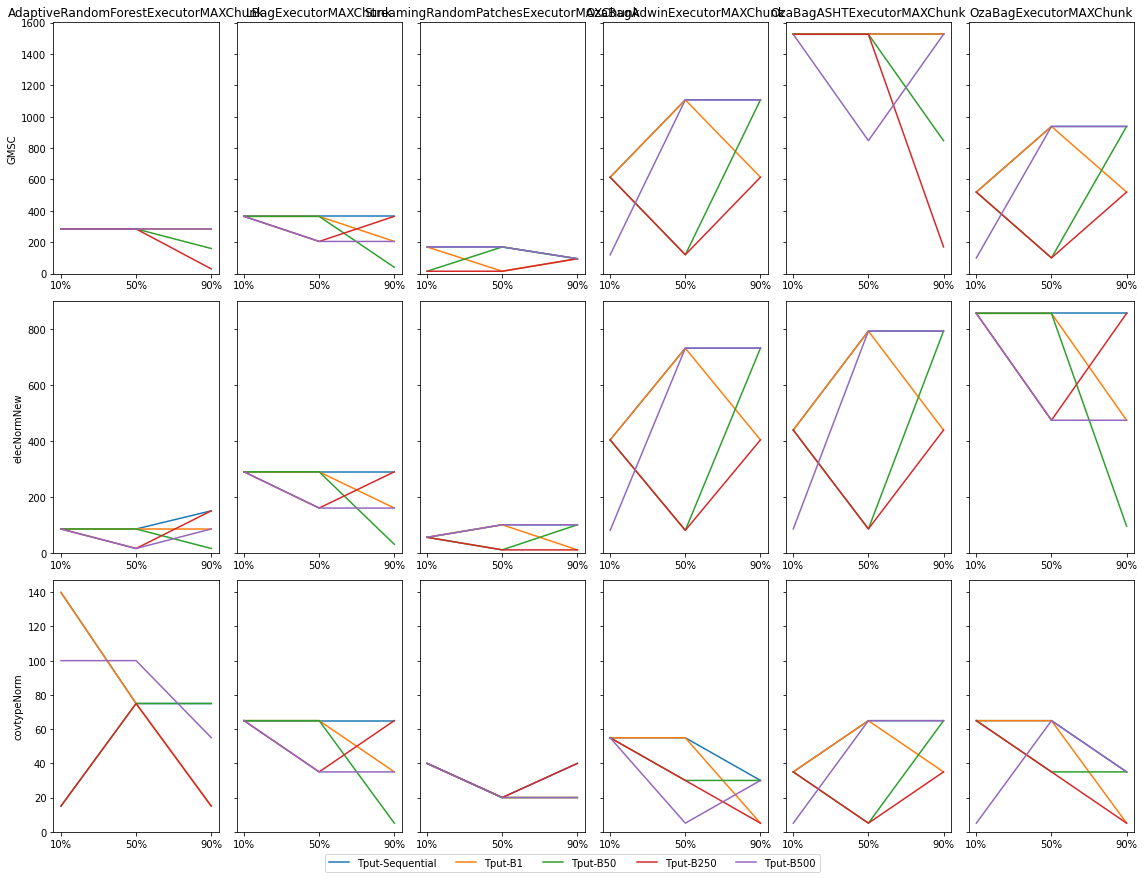




----------------- 1000 -----------------
1000
share_y: row
log_y: False
norm: False
10
50
90


algorithm dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
1  AdaptiveRandomForestExecutorMAXChunk    GMSC      4          50   
2  AdaptiveRandomForestExecutorMAXChunk    GMSC      4         500   
3  AdaptiveRandomForestExecutorMAXChunk    GMSC      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          32        30.00      3,600.00  120.00    870.00         140  ...   
1          32        30.00      3,600.00  120.00    870.00         140  ...   
2          32        30.01      3,600.00  119.97  9,074.00         125  ...   
3          32        30.01      3,600.00  119.97 35,813.00         126  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    105.00       124         4.29     1,073.00     289.37     34,742.00   
1    870.00       140         3.82     1,076.30      29.96      3,600.00   
2  1,213.00       124         4.36     1,091.20     289.39     34,742.00   
3  4,796.00       124         4.22     1,055.30     289.40     34,742.00   

  joules_90  JPI_90  PERC  tput_90  
0    514.62    0.01    90   289.75  
1    458.01    0.13    90    30.00  
2    523.19    0.02    90   289.84  
3    505.96    0.01    90   289.85  

[4 rows x 46 columns]

algorithm dataset  batch_size  cores  tput_10  \
0  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
1  AdaptiveRandomForestExecutorMAXChunk    GMSC          50      4    30.00   
2  AdaptiveRandomForestExecutorMAXChunk    GMSC         500      4    30.01   
3  AdaptiveRandomForestExecutorMAXChunk    GMSC        2000      4    30.01   

   tput_50  tput_90  
0   159.94   289.75  
1   159.94    30.00  
2   159.98   289.84  
3   159.99   289.85

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  LBagExecutorMAXChunk    GMSC      4          50          41        39.99   
1  LBagExecutorMAXChunk    GMSC      4         500          41        40.01   
2  LBagExecutorMAXChunk    GMSC      4        2000          41        40.01   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0      4,800.00  120.02    650.00         125  ...     86.00       125   
1      4,800.00  119.98  6,721.00         126  ...    927.00       126   
2      4,800.00  119.98 25,312.00         126  ...  3,724.00       126   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.11     1,034.50     369.15     44,326.00    492.26    0.01    90   
1         4.10     1,041.10     369.15     44,326.00    491.40    0.01    90   
2         3.90       990.30     369.17     44,326.00    468.09    0.01    90   

   tput_90  
0   369.65  
1   369.73  
2   366.48  

[3 rows x 46 columns]

algorithm dataset  batch_size  cores  tput_10  tput_50  tput_90
0  LBagExecutorMAXChunk    GMSC          50      4    39.99   204.91   369.65
1  LBagExecutorMAXChunk    GMSC         500      4    40.01   204.84   369.73
2  LBagExecutorMAXChunk    GMSC        2000      4    40.01   204.94   366.48

10
50
90


algorithm dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk    GMSC      4          50   
1  StreamingRandomPatchesExecutorMAXChunk    GMSC      4         500   
2  StreamingRandomPatchesExecutorMAXChunk    GMSC      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          14        10.00      1,200.00  120.03  2,598.00         124  ...   
1          14        10.00      1,200.00  119.94 25,462.00         124  ...   
2          14        10.00      1,200.00  119.95 68,421.00         132  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    197.00       123         3.97       984.80      69.89      8,400.00   
1  2,580.00       125         3.95       996.40     124.79     14,975.00   
2 10,794.00       125         4.03     1,015.50     124.79     15,000.00   

  joules_90  JPI_90  PERC  tput_90  
0    475.79    0.03    90   124.98  
1    473.74    0.03    90   124.99  
2    483.60    0.03    90   124.79  

[3 rows x 46 columns]

algorithm dataset  batch_size  cores  tput_10  \
0  StreamingRandomPatchesExecutorMAXChunk    GMSC          50      4    10.00   
1  StreamingRandomPatchesExecutorMAXChunk    GMSC         500      4    10.00   
2  StreamingRandomPatchesExecutorMAXChunk    GMSC        2000      4    10.00   

   tput_50  tput_90  
0    69.93   124.98  
1    70.00   124.99  
2    69.89   124.79

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk    GMSC      4          50         110   
1  OzaBagAdwinExecutorMAXChunk    GMSC      4         500         110   
2  OzaBagAdwinExecutorMAXChunk    GMSC      4        2000         110   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       109.99     13,178.00  119.82    235.00         126  ...     32.00   
1       109.82     13,179.00  120.01  2,432.00         125  ...    338.00   
2       109.82     13,179.00  120.01  9,624.00         125  ...  1,372.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         3.96       996.70     991.30    119,002.00    474.22   
1       126         4.12     1,047.60     991.42    119,002.00    494.58   
2       126         3.99     1,012.60     991.44    119,002.00    477.75   

   JPI_90  PERC  tput_90  
0    0.00    90   992.51  
1    0.00    90   992.38  
2    0.00    90   993.02  

[3 rows x 46 columns]

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagAdwinExecutorMAXChunk    GMSC          50      4   109.99   549.37   
1  OzaBagAdwinExecutorMAXChunk    GMSC         500      4   109.82   549.44   
2  OzaBagAdwinExecutorMAXChunk    GMSC        2000      4   109.82   549.47   

   tput_90  
0   992.51  
1   992.38  
2   993.02

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk    GMSC      4          50         153   
1  OzaBagASHTExecutorMAXChunk    GMSC      4         500         153   
2  OzaBagASHTExecutorMAXChunk    GMSC      4        2000         153   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0       149.97     17,970.00  119.82    147.00         126  ...     24.00   
1       149.98     17,970.00  119.81  1,793.00         125  ...    246.00   
2       149.97     17,970.00  119.82  7,321.00         126  ...  1,039.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       115         4.02       933.60   1,372.71    150,000.00    439.14   
1       115         4.10       950.10   1,372.85    150,000.00    447.02   
2       114         3.99       917.80   1,372.70    150,000.00    436.62   

   JPI_90  PERC  tput_90  
0    0.00    90 1,374.55  
1    0.00    90 1,374.18  
2    0.00    90 1,370.91  

[3 rows x 46 columns]

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagASHTExecutorMAXChunk    GMSC          50      4   149.97   762.90   
1  OzaBagASHTExecutorMAXChunk    GMSC         500      4   149.98   762.21   
2  OzaBagASHTExecutorMAXChunk    GMSC        2000      4   149.97   763.88   

   tput_90  
0 1,374.55  
1 1,374.18  
2 1,370.91

10
50
90


algorithm dataset  cores  batch_size  inc_rate_x  out_rate_10  \
0  OzaBagExecutorMAXChunk    GMSC      4          50         109       104.83   
1  OzaBagExecutorMAXChunk    GMSC      4         500         109       105.00   
2  OzaBagExecutorMAXChunk    GMSC      4        2000         109       105.00   

   instances_10  time_x  delay_10  duration_x  ...  delay_90  duration  \
0     12,580.00  120.01    248.00         126  ...     32.00       126   
1     12,600.00  120.00  2,544.00         126  ...    330.00       126   
2     12,600.00  120.00 10,054.00         126  ...  1,367.00       125   

   avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  JPI_90  PERC  \
0         4.12     1,046.80     981.39    117,806.00    494.10    0.00    90   
1         4.01     1,017.70     981.54    117,806.00    480.15    0.00    90   
2         4.02     1,014.20     981.56    117,806.00    482.26    0.00    90   

   tput_90  
0   982.62  
1   983.06  
2   983.13  

[3 rows x 46 columns]

algorithm dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagExecutorMAXChunk    GMSC          50      4   104.83   544.34   
1  OzaBagExecutorMAXChunk    GMSC         500      4   105.00   544.45   
2  OzaBagExecutorMAXChunk    GMSC        2000      4   105.00   544.46   

   tput_90  
0   982.62  
1   983.06  
2   983.13

10
50
90


algorithm      dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  elecNormNew      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          19        15.00      1,800.00  120.01  1,786.00         123  ...   
1          19        15.01      1,800.00  119.96 18,269.00         124  ...   
2          19        15.01      1,800.00  119.95 76,649.00         141  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    179.00       124         4.12     1,029.40     174.67     20,965.00   
1  2,018.00       125         4.17     1,050.90     174.67     20,965.00   
2  8,056.00       125         4.10     1,032.30     174.67     20,965.00   

  joules_90  JPI_90  PERC  tput_90  
0    493.61    0.02    90   174.88  
1    499.76    0.02    90   174.94  
2    490.90    0.02    90   174.70  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  \
0  AdaptiveRandomForestExecutorMAXChunk  elecNormNew          50      4   
1  AdaptiveRandomForestExecutorMAXChunk  elecNormNew         500      4   
2  AdaptiveRandomForestExecutorMAXChunk  elecNormNew        2000      4   

   tput_10  tput_50  tput_90  
0    15.00    94.99   174.88  
1    15.01    94.84   174.94  
2    15.01    94.99   174.70

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  LBagExecutorMAXChunk  elecNormNew      4          50          31   
1  LBagExecutorMAXChunk  elecNormNew      4         500          31   
2  LBagExecutorMAXChunk  elecNormNew      4        2000          31   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        30.00      3,600.00  120.00    876.00         126  ...    109.00   
1        30.01      3,600.00  119.97  9,158.00         126  ...  1,192.00   
2        30.01      3,600.00  119.97 35,801.00         127  ...  4,753.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         4.03     1,022.90     284.36     34,143.00    482.95   
1       125         3.97     1,001.50     284.36     34,143.00    476.43   
2       127         3.97     1,017.00     284.39     34,143.00    476.20   

   JPI_90  PERC  tput_90  
0    0.01    90   284.71  
1    0.01    90   284.81  
2    0.01    90   282.54  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0  LBagExecutorMAXChunk  elecNormNew          50      4    30.00   154.93   
1  LBagExecutorMAXChunk  elecNormNew         500      4    30.01   154.96   
2  LBagExecutorMAXChunk  elecNormNew        2000      4    30.01   154.97   

   tput_90  
0   284.71  
1   284.81  
2   282.54

10
50
90


algorithm      dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  elecNormNew      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           4        19.99      2,400.00  120.09  1,382.00         125  ...   
1           4        20.01      2,400.00  119.96 14,320.00         125  ...   
2           4        20.01      2,400.00  119.96 54,993.00         126  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    734.00       124         4.27     1,066.80      39.94      4,800.00   
1  7,425.00       124         3.94       985.30      39.94      4,800.00   
2 29,240.00       126         3.98     1,011.50      39.94      4,800.00   

  joules_90  JPI_90  PERC  tput_90  
0    512.43    0.11    90    39.97  
1    472.89    0.10    90    40.00  
2    477.81    0.10    90    40.01  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  \
0  StreamingRandomPatchesExecutorMAXChunk  elecNormNew          50      4   
1  StreamingRandomPatchesExecutorMAXChunk  elecNormNew         500      4   
2  StreamingRandomPatchesExecutorMAXChunk  elecNormNew        2000      4   

   tput_10  tput_50  tput_90  
0    19.99    19.98    39.97  
1    20.01    20.01    40.00  
2    20.01    20.01    40.01

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  elecNormNew      4          50          79   
1  OzaBagAdwinExecutorMAXChunk  elecNormNew      4         500          79   
2  OzaBagAdwinExecutorMAXChunk  elecNormNew      4        2000          79   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        74.88      8,986.00  120.01    330.00         125  ...     48.00   
1        74.88      8,986.00  120.00  3,567.00         126  ...    493.00   
2        74.88      8,986.00  120.00 13,821.00         126  ...  1,993.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        69         3.99       558.20     712.52     45,312.00    253.00   
1        68         3.74       516.30     712.51     45,312.00    237.22   
2        68         3.73       514.60     712.50     45,312.00    236.45   

   JPI_90  PERC  tput_90  
0    0.01    90   714.09  
1    0.01    90   714.62  
2    0.01    90   708.93  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  \
0  OzaBagAdwinExecutorMAXChunk  elecNormNew          50      4    74.88   
1  OzaBagAdwinExecutorMAXChunk  elecNormNew         500      4    74.88   
2  OzaBagAdwinExecutorMAXChunk  elecNormNew        2000      4    74.88   

   tput_50  tput_90  
0   394.29   714.09  
1   394.39   714.62  
2   394.39   708.93

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  elecNormNew      4          50          41   
1  OzaBagASHTExecutorMAXChunk  elecNormNew      4         500          41   
2  OzaBagASHTExecutorMAXChunk  elecNormNew      4        2000          41   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        40.00      4,800.00  120.00    632.00         125  ...     50.00   
1        40.01      4,800.00  119.99  6,411.00         126  ...    775.00   
2        40.01      4,800.00  119.98 24,383.00         126  ...  3,193.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         3.89       981.40     374.07     44,925.00    467.03   
1       126         4.09     1,039.10     374.08     44,925.00    490.53   
2       125         3.73       938.90     374.11     44,925.00    446.72   

   JPI_90  PERC  tput_90  
0    0.01    90   374.62  
1    0.01    90   374.67  
2    0.01    90   374.69  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  \
0  OzaBagASHTExecutorMAXChunk  elecNormNew          50      4    40.00   
1  OzaBagASHTExecutorMAXChunk  elecNormNew         500      4    40.01   
2  OzaBagASHTExecutorMAXChunk  elecNormNew        2000      4    40.01   

   tput_50  tput_90  
0   204.89   374.62  
1   204.92   374.67  
2   204.92   374.69

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  elecNormNew      4          50          92   
1  OzaBagExecutorMAXChunk  elecNormNew      4         500          92   
2  OzaBagExecutorMAXChunk  elecNormNew      4        2000          92   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0        89.99     10,782.00  119.82    286.00         126  ...     40.00   
1        89.99     10,782.00  119.81  2,947.00         126  ...    389.00   
2        89.99     10,782.00  119.81 11,682.00         126  ...  1,655.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0        60         3.98       485.30     830.06     45,312.00    216.45   
1        60         3.74       456.50     829.91     45,312.00    203.60   
2        59         3.73       447.00     830.21     45,312.00    202.62   

   JPI_90  PERC  tput_90  
0    0.00    90   832.73  
1    0.00    90   832.77  
2    0.00    90   824.21  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagExecutorMAXChunk  elecNormNew          50      4    89.99   459.16   
1  OzaBagExecutorMAXChunk  elecNormNew         500      4    89.99   459.24   
2  OzaBagExecutorMAXChunk  elecNormNew        2000      4    89.99   459.20   

   tput_90  
0   832.73  
1   832.77  
2   824.21

10
50
90


algorithm      dataset  cores  batch_size  \
0  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4          50   
1  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4         500   
2  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0          12        10.00      1,200.00  120.04  2,627.00         124  ...   
1          12        10.00      1,200.00  119.94 26,232.00         125  ...   
2          12        10.00      1,200.00  119.94 71,651.00         136  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    316.00       124         4.00       999.50     109.81     13,178.00   
1  3,213.00       125         3.84       966.90     109.81     13,178.00   
2 13,173.00       126         3.88       986.30     109.81     13,178.00   

  joules_90  JPI_90  PERC  tput_90  
0    479.05    0.04    90   109.98  
1    459.72    0.03    90   109.99  
2    465.25    0.04    90   109.99  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  \
0  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm          50      4   
1  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm         500      4   
2  AdaptiveRandomForestExecutorMAXChunk  covtypeNorm        2000      4   

   tput_10  tput_50  tput_90  
0    10.00    59.97   109.98  
1    10.00    60.00   109.99  
2    10.00    60.00   109.99

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  LBagExecutorMAXChunk  covtypeNorm      4          50           7   
1  LBagExecutorMAXChunk  covtypeNorm      4         500           7   
2  LBagExecutorMAXChunk  covtypeNorm      4        2000           7   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.01  5,183.00         126  ...    545.00   
1         5.00        600.00  119.94 47,589.00         126  ...  5,279.00   
2         5.00        600.00  119.94 65,191.00         130  ... 22,060.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         3.88       986.20      64.90      7,800.00    466.50   
1       127         3.87       989.60      64.90      7,800.00    463.88   
2       132         3.98     1,057.40      64.90      7,800.00    477.01   

   JPI_90  PERC  tput_90  
0    0.06    90    64.92  
1    0.06    90    65.00  
2    0.06    90    65.00  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0  LBagExecutorMAXChunk  covtypeNorm          50      4     5.00    34.97   
1  LBagExecutorMAXChunk  covtypeNorm         500      4     5.00    35.01   
2  LBagExecutorMAXChunk  covtypeNorm        2000      4     5.00    33.32   

   tput_90  
0    64.92  
1    65.00  
2    65.00

10
50
90


algorithm      dataset  cores  batch_size  \
0  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4          50   
1  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4         500   
2  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm      4        2000   

   inc_rate_x  out_rate_10  instances_10  time_x  delay_10  duration_x  ...  \
0           4        19.97      2,400.00  120.20  1,519.00         125  ...   
1           4        20.01      2,400.00  119.95 16,125.00         126  ...   
2           4          NaN           NaN     NaN       NaN         618  ...   

   delay_90  duration  avg_measure  sum_measure  prod_rate  tt_inst_prod  \
0    872.00       125         3.87       975.50      39.95      4,800.00   
1  8,792.00       125         4.04     1,018.40      39.94      4,800.00   
2 34,001.00       128         3.72       960.70      39.95      4,800.00   

  joules_90  JPI_90  PERC  tput_90  
0    465.35    0.10    90    39.93  
1    484.86    0.10    90    40.01  
2    446.74    0.09    90    40.01  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  \
0  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm          50      4   
1  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm         500      4   
2  StreamingRandomPatchesExecutorMAXChunk  covtypeNorm        2000      4   

   tput_10  tput_50  tput_90  
0    19.97    19.97    39.93  
1    20.01    20.01    40.01  
2      NaN      NaN    40.01

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4          50           6   
1  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4         500           6   
2  OzaBagAdwinExecutorMAXChunk  covtypeNorm      4        2000           6   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.06  5,235.00         125  ...    571.00   
1         5.00        600.00  119.94 46,542.00         126  ...  6,160.00   
2         5.00        600.00  119.94 63,390.00         128  ... 21,764.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       126         3.93       999.00      54.91      6,600.00    472.48   
1       125         4.19     1,055.30      54.92      6,600.00    502.74   
2       127         3.72       952.40      54.92      6,600.00    446.40   

   JPI_90  PERC  tput_90  
0    0.07    90    54.94  
1    0.08    90    54.14  
2    0.07    90    55.00  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  \
0  OzaBagAdwinExecutorMAXChunk  covtypeNorm          50      4     5.00   
1  OzaBagAdwinExecutorMAXChunk  covtypeNorm         500      4     5.00   
2  OzaBagAdwinExecutorMAXChunk  covtypeNorm        2000      4     5.00   

   tput_50  tput_90  
0    29.98    54.94  
1    30.01    54.14  
2    30.01    55.00

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagASHTExecutorMAXChunk  covtypeNorm      4          50           6   
1  OzaBagASHTExecutorMAXChunk  covtypeNorm      4         500           6   
2  OzaBagASHTExecutorMAXChunk  covtypeNorm      4        2000           6   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.04  5,143.00         125  ...    547.00   
1         5.00        600.00  119.94 45,524.00         126  ...  5,138.00   
2         5.00        600.00  119.94 63,144.00         128  ... 19,913.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         4.23     1,066.30      59.91      7,200.00    508.49   
1       125         4.18     1,054.10      59.91      7,200.00    501.95   
2       128         3.72       960.30      59.91      7,200.00    446.65   

   JPI_90  PERC  tput_90  
0    0.07    90    59.91  
1    0.07    90    60.00  
2    0.06    90    60.00  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  \
0  OzaBagASHTExecutorMAXChunk  covtypeNorm          50      4     5.00   
1  OzaBagASHTExecutorMAXChunk  covtypeNorm         500      4     5.00   
2  OzaBagASHTExecutorMAXChunk  covtypeNorm        2000      4     5.00   

   tput_50  tput_90  
0    29.97    59.91  
1    30.01    60.00  
2    30.01    60.00

10
50
90


algorithm      dataset  cores  batch_size  inc_rate_x  \
0  OzaBagExecutorMAXChunk  covtypeNorm      4          50           9   
1  OzaBagExecutorMAXChunk  covtypeNorm      4         500           9   
2  OzaBagExecutorMAXChunk  covtypeNorm      4        2000           9   

   out_rate_10  instances_10  time_x  delay_10  duration_x  ...  delay_90  \
0         5.00        600.00  120.02  5,121.00         125  ...    430.00   
1         5.00        600.00  119.93 45,555.00         126  ...  4,223.00   
2         5.00        600.00  119.93 63,174.00         129  ... 16,186.00   

   duration  avg_measure  sum_measure  prod_rate  tt_inst_prod joules_90  \
0       125         4.25     1,070.70      84.86     10,183.00    509.04   
1       125         4.32     1,088.50      84.86     10,200.00    518.34   
2       127         3.70        14.80      84.86     10,200.00    454.55   

   JPI_90  PERC  tput_90  
0    0.05    90    84.99  
1    0.05    90    84.87  
2    0.05    90    81.40  

[3 rows x 46 columns]

algorithm      dataset  batch_size  cores  tput_10  tput_50  \
0  OzaBagExecutorMAXChunk  covtypeNorm          50      4     5.00    44.95   
1  OzaBagExecutorMAXChunk  covtypeNorm         500      4     5.00    45.01   
2  OzaBagExecutorMAXChunk  covtypeNorm        2000      4     5.00    45.01   

   tput_90  
0    84.99  
1    84.87  
2    81.40

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


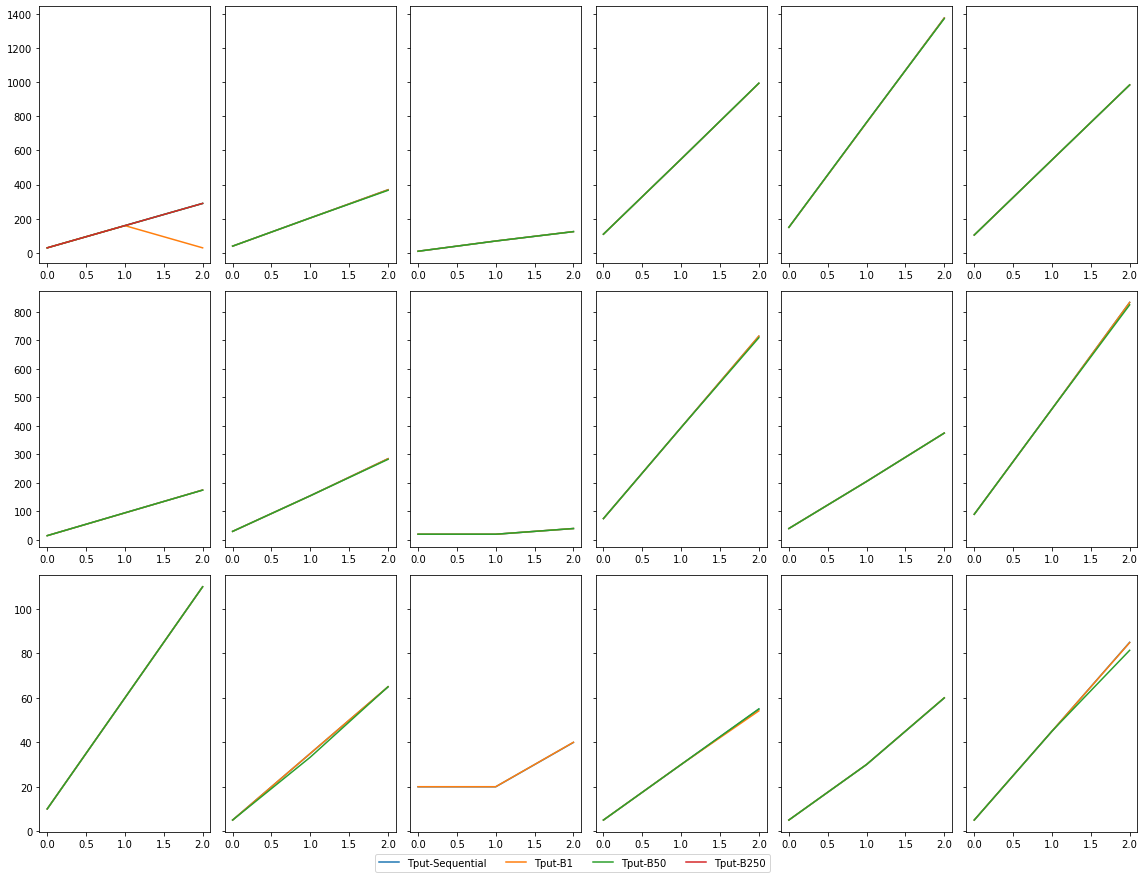

In [210]:
for freq,df in zip(freqs,dataframes):
    print(f'\n\n\n----------------- {freq} -----------------')
    show_tput(df, arch=freq.title())

In [ ]:
## Normalize Data Rasp Servidor Desicronizado

from datetime import datetime, timedelta

# Using readlines()
wm = open('Wm-800.log', 'r')
Lines = wm.readlines()

UltimaHoraOk = '2022/01/21 00:44:27' 
count = 0

current_line = Lines[0].split(',')
date_separated = current_line[0].split('/')
date = '20' + date_separated[2] + '/' + date_separated[1] + '/' + date_separated[0] + ' ' + current_line[1]

f = '%Y/%m/%d %H:%M:%S'
f2 = '%d/%m/%y,%H:%M:%S'

date_line = datetime.strptime(date, f)
dif = (datetime.strptime(UltimaHoraOk, f) - date_line).total_seconds()

new_date_line = date_line + timedelta(seconds=dif)

with open("Wm-800.log") as fp:
    while True:
        count += 1
        line = fp.readline()

        current_line_write = line.split(',')
 
        if not line:
            break
        
        if count == 1:
            continue

        new_date_line = new_date_line + timedelta(seconds=0.5)
        print(new_date_line.strftime(f2) + "," + current_line_write[2].replace("\n", ""))

d = {}
header_printed = False
moaDF = read_MOA(f"{PATH_TO_RESULTS}/Energy/vostro/socket", f"{PATH_TO_RESULTS}/Energy/vostro/inst-and-delay.csv")
moaDF = moaDF[["algorithm", "dataset", "cores", "batch_size", "inc_rate", "out_rate", "instances", "time", "delay"]]
measureDF = load_Wmeas(f'{PATH_TO_RESULTS}/Energy/vostro/Wm-vostro.log')
d = exper_order_to_dict(f'{PATH_TO_RESULTS}/Energy/vostro/exper_order-vostro.log', d)
d = populate_dict(d, measureDF)
mdf = append_dict_to_df(d)
sshDF = parse_SSH(f'{PATH_TO_RESULTS}/Energy/vostro/ssh-log-vostro')
sshDF['batch_size'] = sshDF['batch_size'].astype(int)

#join dfs
finaldf = moaDF.merge(mdf, on=['algorithm', 'dataset', 'cores', 'batch_size', 'inc_rate'])
finaldf = finaldf.merge(sshDF, 'left', on=['algorithm', 'dataset', 'batch_size', 'inc_rate'])
finaldf['joules'] = finaldf['avg_measure'] * finaldf['time']
finaldf['JPI'] = finaldf['joules'] / finaldf['instances']

### Add PERC column to identify if it used 90, 50 or 10% max rate

- Before merging rows with the same batch size, we need to differentiate the experiments with different work loads
- We use the **PERC**entage column for that

tdf = finaldf.sort_values(by=['dataset','algorithm','batch_size','inc_rate'], ascending=False)
tdf['PERC'] = 0
masks = {'90':[], '50': [], '10': []}
for k, v in zip(masks.keys(), [0, 1, 2]):
    for i in range(len(tdf)):
        masks[k].append(i % 3 == v)
tdf.loc[masks['90'],'PERC'] = '90'
tdf.loc[masks['50'],'PERC'] = '50'
tdf.loc[masks['10'],'PERC'] = '10'

Sharey = row

Linear scale

gen_graph(bars=True)

sharey = False

linear scale

gen_graph(bars=True, share_y=False)

sharey = false

log scale y

gen_graph(bars=True, share_y=False, log_y=True)

gen_graph(bars=True)

def table_delta_rates_vert(ratio=False):
    rates = ['10', '50', '90']
    algs = ['Ada', 'L', 'Patches', 'Adwin', 'ASHT', 'OzaBag']
    datasets = ['airlines', 'GMSC','elecNormNew','covtypeNorm','kyoto_binary']
    all_values = []
    # filtra algoritmo
    for alg in algs:
        line = '\hline\n\\multirow{3}{*}{' + alg + '} '
        algdf = filter_by_substring_algorithm(tdf, alg).sort_values(['algorithm','batch_size','cores'])
#         display(algdf)
        # filtra rate
        for rt in rates:
            if rt != '10':
                line += '\\\\\n'
            line += f' & {rt} '
            rtalgdf = rename_columns_by_rate(algdf[algdf.PERC == rt])
            # filtra dataset
            for ds in datasets:
#                 print(ds)
                dsrtalgdf = rtalgdf[rtalgdf.dataset == ds]
#                 display(dsrtalgdf)
                minoutro = min(dsrtalgdf[dsrtalgdf.batch_size == 1][f'JPI_{rt}'])
#                 print(f"JPI_{rt} minoutro {minoutro}")
                val = ((dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro)/minoutro)*100 if ratio else dsrtalgdf[dsrtalgdf.batch_size != 1][f'JPI_{rt}'].iloc[0] - minoutro 
                all_values.append(val)
                sval = f"{val:.2f} " if val < 0 else "\\textbf{ " + f"{val:.2f}" + "} "
                line += f"& {sval} "
        print(f"{line} \\\\")
    print(f'\n\nAverage reduction: {sum(all_values)/len(all_values)}')

table_delta_rates_vert()